<a href="https://colab.research.google.com/github/app850/unsupervised-ehr-prognosis/blob/main/Lung_Cancer_Phenotyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd

file_path = "/content/LungBrainMets-20241001DEIDENTIFIEDCOPYWITHLINKAGECODE.xlsx"
df = pd.read_excel(file_path)

##Demographics

In [ ]:
import pandas as pd
import numpy as np

# --- AGE CLEANING AND BINNING ---
df['Age at primary Diagnosis'] = pd.to_numeric(df['Age at primary Diagnosis'], errors='coerce')

# Optional: flag extreme values
df['Age_flag'] = df['Age at primary Diagnosis'].apply(lambda x: 'Check' if x < 20 or x > 100 else 'OK')

# Age bins for stratified analysis
df['Age_Group'] = pd.cut(
    df['Age at primary Diagnosis'],
    bins=[0, 49, 59, 69, 79, 89, 120],
    labels=['<50', '50–59', '60–69', '70–79', '80–89', '90+']
)


# --- GENDER CLEANING ---
df['Gender'] = df['Gender'].astype(str).str.strip().str.capitalize()
df['Gender'] = df['Gender'].replace({
    'M': 'Male', 'F': 'Female', '0': np.nan, 'Unknown': np.nan,
    '(Null)': np.nan, 'Nan': np.nan
})

valid_genders = ['Male', 'Female']
df['Gender'] = df['Gender'].where(df['Gender'].isin(valid_genders), 'Other/Unknown')


# --- COUNTRY OF BIRTH TO REGION MAPPING ---

# Clean raw values
df['Country of birth'] = df['Country of birth'].astype(str).str.strip().str.title()
df['Country of birth'] = df['Country of birth'].replace({'(Null)': np.nan, 'Null': np.nan, '0': np.nan})

# Define region mappings
pacific = ['New Zealand', 'Fiji', 'Papua New Guinea', 'Samoa', 'Tonga', 'Vanuatu', 'Cook Islands', 'Solomon Islands']
australia = ['Australia']
europe = [
    'Austria', 'Belgium', 'England', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
    'Italy', 'Netherlands', 'Poland', 'Portugal', 'Scotland', 'Spain', 'Sweden', 'Switzerland',
    'Wales', 'United Kingdom', 'United Kingdom, Channels Islands', 'United Kingdom, Channel Islands A'
]
asia = [
    'India', 'China', 'Vietnam', 'Philippines', 'Malaysia', 'Indonesia', 'Sri Lanka',
    'Pakistan', 'Bangladesh', 'Thailand', 'Singapore', 'Nepal', 'Japan', 'South Korea'
]
africa = ['South Africa', 'Egypt', 'Nigeria', 'Kenya', 'Zimbabwe', 'Sudan', 'Ethiopia']
americas = ['United States', 'Canada', 'Mexico', 'Brazil', 'Chile']

# Mapping function
def map_region(country):
    if pd.isnull(country):
        return 'Unknown'
    if country in australia:
        return 'Australia'
    elif country in pacific:
        return 'Pacific'
    elif country in europe:
        return 'Europe'
    elif country in asia:
        return 'Asia'
    elif country in africa:
        return 'Africa'
    elif country in americas:
        return 'Americas'
    else:
        return 'Other'

# Apply region mapping
df['Region of birth'] = df['Country of birth'].apply(map_region)


##Diagnosis

In [ ]:
import pandas as pd
import numpy as np
import re

# --- PRIMARY CANCER SITE (ICD-10) ---

# Extract valid ICD codes (C34.x) and map to labels
df['Primary cancer site'] = df['Primary cancer site'].astype(str).str.extract(r'(C\d{2}\.\d)').fillna('C34.9')
df['Primary cancer site'] = df['Primary cancer site'].str.upper()

icd_site_mapping = {
    'C34.0': 'Main bronchus',
    'C34.1': 'Upper lobe',
    'C34.2': 'Middle lobe',
    'C34.3': 'Lower lobe',
    'C34.8': 'Overlapping lesion',
    'C34.9': 'Unspecified lung'
}
df['Primary site label'] = df['Primary cancer site'].map(icd_site_mapping)


# --- DIAGNOSIS CLASS ---

df['Diagnosis_Class'] = df['Diagnosis_Class'].astype(str).str.strip().str.lower()
df['Diagnosis_Class'] = df['Diagnosis_Class'].replace({
    'primary': 'Primary',
    'recurrent': 'Recurrent',
    'restage': 'Restage',
    'related': 'Related'
})


# --- MORPHOLOGY ---

df['Morphology'] = df['Morphology'].astype(str).str.strip().str.upper()

morphology_map = {
    '8140/3': 'Adenocarcinoma',
    '8070/3': 'Squamous cell carcinoma',
    '8041/3': 'Small cell carcinoma',
    '8480/3': 'Mucinous adenocarcinoma',
    '8012/3': 'Large cell carcinoma'
}
df['Morphology_Grouped'] = df['Morphology'].map(morphology_map).fillna('Other')


# --- LATERALITY ---

df['Laterality'] = df['Laterality'].astype(str).str.strip().str.title()

def map_laterality(value):
    if pd.isnull(value) or value in ['(Null)', 'Na', 'Null', 'Nan', '', '9 - Unknown side']:
        return 'Unknown'

    value = value.lower()
    if 'left' in value and 'right' in value:
        return 'Bilateral'
    elif 'bilateral' in value or 'simultan' in value:
        return 'Bilateral'
    elif 'left' in value:
        return 'Left'
    elif 'right' in value:
        return 'Right'
    elif 'carina' in value or 'central' in value or 'medial' in value or 'apical' in value:
        return 'Central'
    else:
        return 'Unknown'

df['Laterality_Clean'] = df['Laterality'].apply(map_laterality)


# --- ECOG PERFORMANCE STATUS ---

# Clean ECOG field
df['ECOG_raw'] = df['ECOG'].astype(str).str.strip().str.lower()

# Define mapping from raw values to numeric scores
def parse_ecog(value):
    value = str(value).strip().lower()
    if value in ['(null)', 'null', '', 'nan', '9 - unknown', '9']:
        return np.nan
    elif value == '0' or value.startswith('0 -'):
        return 0
    elif value.startswith('1 -'):
        return 1
    elif value.startswith('2 -'):
        return 2
    elif value.startswith('3 -'):
        return 3
    elif value.startswith('4 -'):
        return 4
    else:
        return np.nan

# Apply mapping
df['ECOG_score'] = df['ECOG_raw'].apply(parse_ecog)

# Map numeric score to descriptive category
ecog_map = {
    0: 'Fully active',
    1: 'Ambulatory, light activity',
    2: 'Self-care, limited work',
    3: 'Limited self-care, mostly bedridden',
    4: 'Completely disabled'
}
df['ECOG_category'] = df['ECOG_score'].map(ecog_map)


##Staging

In [ ]:
import numpy as np
import pandas as pd
import re
from pandas.api.types import CategoricalDtype

# --- 1. Define valid values ---
valid_t = ['T0', 'T1', 'T1A', 'T1B', 'T2', 'T2A', 'T2B', 'T3', 'T4']
valid_n = ['N0', 'N1', 'N2', 'N3']
valid_m = ['M0', 'M1', 'M1A', 'M1B', 'M1C']

# --- 2. Clean all stage fields including NOS variants ---
def clean_stage(col):
    return (
        col.astype(str)
        .str.strip()
        .str.upper()
        .replace({
            'T2NOS': 'T2', 'T3NOS': 'T3', 'T1NOS': 'T1', 'T4NOS': 'T4',
            'N3NOS': 'N3',
            'M1NOS': 'M1B', 'M1': 'M1B',
            'ERROR': np.nan, 'NAN': np.nan, 'NULL': np.nan, '(NULL)': np.nan,
            'NONE': np.nan, '': np.nan
        })
    )

for col in [

    'T stage clinical', 'N stage clinical', 'M stage clinical',
    'T stage pathological', 'N stage pathological', 'M stage pathological',
    'TNM stage clinical', 'TNM stage pathological'
]:
    df[col] = clean_stage(df[col])

# --- 3. Extract T/N/M from TNM string (relaxed match) ---
def parse_tnm(tnm_str):
    if pd.isnull(tnm_str):
        return None, None, None
    tnm_str = tnm_str.replace(" ", "").upper()
    match = re.match(r'T(\d[A-B]?|NOS)?N(\d|NOS)?M(\d[A-C]?|NOS)?', tnm_str)
    if match:
        t = f"T{match.group(1)}" if match.group(1) and 'NOS' not in match.group(1) else None
        n = f"N{match.group(2)}" if match.group(2) and 'NOS' not in match.group(2) else None
        m_raw = match.group(3)
        if m_raw and 'NOS' in m_raw:
            m = 'M1B'  # Conservative assumption
        elif m_raw:
            m = f"M{m_raw}"
        else:
            m = None
        return t, n, m
    return None, None, None

# --- 4. Failsafe T/N/M derivation ---
def get_final_stage(row, stage_type):
    valid_set = valid_t if stage_type == 'T' else valid_n if stage_type == 'N' else valid_m
    # Corrected typo: 'T stage clinical' to 'T stage clincial'
    clinical = row.get(f"{stage_type} stage clinical")
    pathological = row.get(f"{stage_type} stage pathological")

    for val in [clinical, pathological]:
        if val in valid_set:
            return val

    t_c, n_c, m_c = parse_tnm(row.get('TNM stage clinical')) if pd.notnull(row.get('TNM stage clinical')) else (None, None, None)
    t_p, n_p, m_p = parse_tnm(row.get('TNM stage pathological')) if pd.notnull(row.get('TNM stage pathological')) else (None, None, None)

    parsed_map = {'T': [t_c, t_p], 'N': [n_c, n_p], 'M': [m_c, m_p]}
    for val in parsed_map[stage_type]:
        if val in valid_set:
            return val

    return np.nan

# --- 5. Apply stage derivation ---
df['T_stage_final'] = df.apply(lambda row: get_final_stage(row, 'T'), axis=1)
df['N_stage_final'] = df.apply(lambda row: get_final_stage(row, 'N'), axis=1)
df['M_stage_final'] = df.apply(lambda row: get_final_stage(row, 'M'), axis=1)

# --- 6. Derive grouped stage from final T/N/M ---
def derive_stage(t, n, m):
    if pd.isnull(t) or pd.isnull(n) or pd.isnull(m):
        return np.nan
    if m != 'M0':
        return 'Stage IV'
    if t in ['T1', 'T1A', 'T1B', 'T2', 'T2A'] and n == 'N0':
        return 'Stage I'
    if (t in ['T2B', 'T3'] and n == 'N0') or (t in ['T1', 'T2', 'T2A'] and n == 'N1'):
        return 'Stage II'
    if (t in ['T1', 'T2', 'T3'] and n == 'N2') or (t == 'T4' and n in ['N0', 'N1', 'N2']):
        return 'Stage III'
    return np.nan

df['Stage_Grouped_Final'] = df.apply(lambda row: derive_stage(
    row['T_stage_final'], row['N_stage_final'], row['M_stage_final']
), axis=1)

# --- 7. Extract grouped stage labels directly from TNM stage clinical ---
df['TNM_stage_label'] = df['TNM stage clinical'].str.extract(r'(STAGE\s*)?([IVX]{1,4}[A-C]?)', flags=re.IGNORECASE)[1]
df['TNM_stage_label'] = df['TNM_stage_label'].str.upper().str.replace(' ', '')

stage_map = {
    'I': 'Stage I', 'IA': 'Stage I', 'IB': 'Stage I', 'IA1': 'Stage I', 'IA2': 'Stage I', 'IA3': 'Stage I',
    'II': 'Stage II', 'IIA': 'Stage II', 'IIB': 'Stage II',
    'III': 'Stage III', 'IIIA': 'Stage III', 'IIIB': 'Stage III', 'IIIC': 'Stage III',
    'IV': 'Stage IV', 'IVA': 'Stage IV', 'IVB': 'Stage IV', 'IVC': 'Stage IV'
}

df['Stage_From_TNM_Label'] = df['TNM_stage_label'].map(stage_map)

# --- 8. Fill in final stage if still missing ---
df['Stage_Grouped_Final'] = df['Stage_Grouped_Final'].fillna(df['Stage_From_TNM_Label'])

# Treat T0 N0 M0 as Stage I (conservatively)
df.loc[
    df['Stage_Grouped_Final'].isna() &
    (df['T_stage_final'] == 'T0') &
    (df['N_stage_final'] == 'N0') &
    (df['M_stage_final'] == 'M0'),
    'Stage_Grouped_Final'
] = 'Stage I'

# Handle TNM stage clinical = '4' or 'IV'
df['TNM stage clinical'] = df['TNM stage clinical'].astype(str).str.strip().str.upper()
df.loc[
    df['Stage_Grouped_Final'].isna() &
    df['TNM stage clinical'].isin(['4', 'IV']),
    'Stage_Grouped_Final'
] = 'Stage IV'


# --- 9. Optional: Convert to ordered category for analysis/plotting ---
stage_order = CategoricalDtype(categories=['Stage I', 'Stage II', 'Stage III', 'Stage IV'], ordered=True)
df['Stage_Grouped_Final'] = df['Stage_Grouped_Final'].astype(stage_order)

##Timelines

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings

# Suppress parsing warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. CLEANING DATE FIELDS ---

date_cols = [
    'Primary diagnosis date', 'Diagnosis date',
    'Referral date', 'First consult date',
    'MDT date (recorded)', 'MDT date (actual)',
    'ECOG Date', 'Follow up status date', 'Sugery date',
    'Radiotherapy start date', 'Radiotherapy end date',
    'Ready for care date',
    'chemo episode start date', 'chemo episode end date',
    'Recurrence diagnosis date',
    'Metastasis diagnosis date 1', 'Metastasis diagnosis date 2', 'Metastasis diagnosis date 3',
    'Date of death',
    'TNM Staging Date clinical', 'TNM Staging Date pathological'
]

# Special fix for 'Diagnosis date' if it contains things like "2020-01-01 (Primary)"
if 'Diagnosis date' in df.columns:
    df['Diagnosis date'] = df['Diagnosis date'].astype(str).str.extract(r'(\d{4}-\d{2}-\d{2})')[0]

# Apply standard date conversion
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')

# --- 2. DERIVED TIMELINE FEATURES ---

# Diagnosis-to-care intervals
df['Days_to_Referral'] = (df['Referral date'] - df['Primary diagnosis date']).dt.days
df['Days_to_First_Consult'] = (df['First consult date'] - df['Primary diagnosis date']).dt.days
df['Days_to_MDT_Recorded'] = (df['MDT date (recorded)'] - df['Primary diagnosis date']).dt.days
df['Days_to_MDT_Actual'] = (df['MDT date (actual)'] - df['Primary diagnosis date']).dt.days
df['Days_to_Ready_for_Care'] = (df['Ready for care date'] - df['Primary diagnosis date']).dt.days

# Treatment timelines
df['Days_to_Chemo_Start'] = (df['chemo episode start date'] - df['Primary diagnosis date']).dt.days
df['Days_to_Chemo_End'] = (df['chemo episode end date'] - df['Primary diagnosis date']).dt.days
df['Chemo_duration'] = (df['chemo episode end date'] - df['chemo episode start date']).dt.days
df['Days_MDT_to_Chemo'] = (df['chemo episode start date'] - df['MDT date (actual)']).dt.days

df['Days_to_Radiotherapy_Start'] = (df['Radiotherapy start date'] - df['Primary diagnosis date']).dt.days
df['Days_to_Radiotherapy_End'] = (df['Radiotherapy end date'] - df['Primary diagnosis date']).dt.days
df['Radiotherapy_duration'] = (df['Radiotherapy end date'] - df['Radiotherapy start date']).dt.days

df['Days_to_Surgery'] = (df['Sugery date'] - df['Primary diagnosis date']).dt.days

# Outcome timelines
df['Days_to_Recurrence'] = (df['Recurrence diagnosis date'] - df['Primary diagnosis date']).dt.days
df['Days_to_Death'] = (df['Date of death'] - df['Primary diagnosis date']).dt.days
df['Days_to_Followup'] = (df['Follow up status date'] - df['Primary diagnosis date']).dt.days
df['Days_to_ECOG'] = (df['ECOG Date'] - df['Primary diagnosis date']).dt.days

# --- 3. PROGRESSION-FREE SURVIVAL (PFS) VARIABLES ---

# Earliest event among recurrence/metastasis
df['Progression_date'] = df[[
    'Recurrence diagnosis date',
    'Metastasis diagnosis date 1',
    'Metastasis diagnosis date 2',
    'Metastasis diagnosis date 3'
]].min(axis=1)

# Combine with death for PFS
df['PFS_event_date'] = df[['Progression_date', 'Date of death']].min(axis=1)
df['PFS_days'] = (df['PFS_event_date'] - df['Primary diagnosis date']).dt.days
df['PFS_event'] = np.where(df['PFS_event_date'].notnull(), 1, 0)


##Treatment

Surgery

In [ ]:
import numpy as np
import pandas as pd

# Step 1: Clean and replace nulls before mapping
df['Procedure name'] = df['Procedure name'].astype(str).str.strip().str.title()
df['Procedure name'] = df['Procedure name'].replace({
    '(Null)': np.nan, 'Null': np.nan, '': np.nan, 'Nan': np.nan, 'None': np.nan
})

# Step 2: Define surgery category mapping
def map_surgery(proc):
    if pd.isnull(proc):
        return 'No Surgery'
    proc = proc.lower()
    if 'lobectomy' in proc or 'excision' in proc:
        return 'Lung Surgery'
    elif 'craniotomy' in proc or 'spinal' in proc:
        return 'Non-lung Surgery'
    elif 'orthopaedic' in proc or 'fixation' in proc:
        return 'Supportive'
    else:
        return 'Other Surgery'

# Step 3: Apply mapping to get temporary category
df['Surgery_Category_Temp'] = df['Procedure name'].apply(map_surgery)

# Step 4: Assign numeric priority to surgery categories
priority_order = ['Lung Surgery', 'Non-lung Surgery', 'Supportive', 'Other Surgery', 'No Surgery']
priority_map = {cat: i for i, cat in enumerate(priority_order)}

df['Surgery_Priority'] = df['Surgery_Category_Temp'].map(priority_map)

# Step 5: Aggregate to one surgery category per patient (minimum = most critical)
df_surgery = (
    df.loc[df.groupby('LINKAGE CODE')['Surgery_Priority'].idxmin()]
    [['LINKAGE CODE', 'Surgery_Category_Temp']]
    .rename(columns={'Surgery_Category_Temp': 'Surgery_Category'})
)
df_surgery['Surgery_FLAG'] = np.where(df_surgery['Surgery_Category'] == 'No Surgery', 0, 1)

# Step 6: Merge to master patient-level table
df = df.drop(columns=['Surgery_Category', 'Surgery_FLAG', 'Surgery_Category_Temp', 'Surgery_Priority'], errors='ignore')
df = df.drop_duplicates(subset='LINKAGE CODE')
df = df.merge(df_surgery, on='LINKAGE CODE', how='left')



Radiotherapy

In [ ]:
import pandas as pd
import numpy as np

# Assume 'df' is your pre-existing DataFrame

# --- 1. Clean and Standardize Input Columns (Done Once) ---
print("--- Cleaning and standardizing input columns ---")
# Clean text field for radiotherapy site name
if 'Radiotherapy site name' in df.columns:
    df['Radiotherapy site name'] = df['Radiotherapy site name'].astype(str).str.strip().str.upper()

# Clean numeric fields for dose and fractions
dose_frac_cols = [
    'Prescribed radiation dose', 'Actual radiation dose',
    'prescribed number of fractions', 'actual number of fractions'
]
for col in dose_frac_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- 2. Define Helper Functions ---
def categorize_rt_site(site_name):
    """Categorizes the radiotherapy site based on keywords."""
    if pd.isnull(site_name) or site_name in ['(NULL)', 'NULL', '', '0']:
        return 'Unknown'

    site_name = site_name.lower() # Standardize to lower case for matching

    # Check for SABR keywords first
    if 'sabr' in site_name:
        return 'SABR_Lung' if 'lung' in site_name else 'SABR_Other'
    # Check for general lung/thoracic keywords
    elif any(kw in site_name for kw in ['lung', 'chest', 'thorax', 'mediastinum']):
        return 'RT_Lung'
    else:
        return 'RT_Other'

def flag_sabr_from_dose(row):
    """Applies a multi-rule clinical definition to flag SABR based on dose and fractions."""
    # Use .get() for safety in case a column is missing
    dose = row.get('Prescribed radiation dose')
    fracs = row.get('prescribed number of fractions')

    if pd.isnull(dose) or pd.isnull(fracs):
        return 0 # Cannot determine SABR status if either is missing

    # Rule 1: Common SABR regimen (e.g., 54 Gy in 3 fractions)
    if 54 <= dose <= 60 and 3 <= fracs <= 5:
        return 1

    # Rule 2: Higher dose for central tumors (e.g., 60 Gy in 8 fractions)
    if dose >= 60 and fracs <= 8:
        return 1

    # Rule 3: General lower-bound threshold for SABR
    if dose >= 48 and fracs <= 5:
        return 1

    return 0 # Does not meet any of the clinical SABR criteria

# --- 3. Apply Categorization and Flagging Logic ---
print("--- Applying categorization and flagging logic ---")
# Create a category based on the radiotherapy site name
if 'Radiotherapy site name' in df.columns:
    df['RT_Category'] = df['Radiotherapy site name'].apply(categorize_rt_site)
else:
    # If the site name column doesn't exist, create a default 'Unknown' category
    df['RT_Category'] = 'Unknown'

# Create a flag based on the dose/fraction rules
df['SABR_DoseBased_FLAG'] = df.apply(flag_sabr_from_dose, axis=1)

# --- 4. Create the Final Combined SABR Flag ---
print("--- Creating the final combined SABR_FLAG ---")
# A patient is flagged for SABR if their site name explicitly mentions "SABR_Lung"
# OR if their dose/fraction regimen meets the clinical criteria.
df['SABR_FLAG'] = np.where(
    (df['RT_Category'] == 'SABR_Lung') | (df['SABR_DoseBased_FLAG'] == 1),
    1, 0
)

print("\SABR flagging complete.")
print("Final SABR_FLAG distribution (1 = SABR, 0 = Not SABR):")
print(df['SABR_FLAG'].value_counts())

<>:82: SyntaxWarning: invalid escape sequence '\S'
<>:82: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-1357245482.py:82: SyntaxWarning: invalid escape sequence '\S'
  print("\SABR flagging complete.")


--- Cleaning and standardizing input columns ---
--- Applying categorization and flagging logic ---
--- Creating the final combined SABR_FLAG ---
\SABR flagging complete.
Final SABR_FLAG distribution (1 = SABR, 0 = Not SABR):
SABR_FLAG
0    1892
1     622
Name: count, dtype: int64


Chemotherapy

In [ ]:
# Build patient-level summary
df_chemo_flag = (
    df.assign(has_chemo=df['chemo episode start date'].notna())
      .groupby('LINKAGE CODE', as_index=False)
      .agg(n_chemo_rows=('has_chemo', 'sum'))
      .assign(Chemo_FLAG=lambda x: (x['n_chemo_rows'] > 0).astype(int))
      [['LINKAGE CODE', 'n_chemo_rows', 'Chemo_FLAG']]
)

# Remove any leftovers that could collide
df = df.drop(columns=['Chemo_FLAG', 'n_chemo_rows', 'Chemo_FLAG_x', 'Chemo_FLAG_y'], errors='ignore')

# Safe merge
df = df.merge(df_chemo_flag, on='LINKAGE CODE', how='left')

# Optional: fill missing (patients with no chemo rows at all)
df[['n_chemo_rows']] = df[['n_chemo_rows']].fillna(0)
df['Chemo_FLAG'] = df['Chemo_FLAG'].fillna(0).astype(int)


##Outcomes

In [ ]:
import numpy as np
import pandas as pd

# --- 1. CLEANING RECURRENCE CANCER SITE (ICD-10) ---
df['Recurrence Cancer Site'] = df['Recurrence Cancer Site'].astype(str).str.strip().str.upper().replace({'(NULL)': np.nan, 'NULL': np.nan, '': np.nan})

def group_recurrence_site(icd):
    if pd.isnull(icd):
        return np.nan
    icd = icd.strip()
    if icd in ['C34.1', 'C34.2', 'C34.3']:
        return 'Lobar Specific'
    elif icd == 'C34.0':
        return 'Central/Proximal'
    elif icd == 'C34.8':
        return 'Multifocal/Overlapping'
    elif icd in ['C34.9', 'C34']:
        return 'Unknown/Unspecified'
    else:
        return 'Other/Non-lung'

df['Recurrence_Site_Grouped'] = df['Recurrence Cancer Site'].apply(group_recurrence_site)

# --- 2. CLEANING & CATEGORIZING METASTASIS SITES ---
met_cols = ['Distant Metastasis site 1', 'Distant Metastasis site 2', 'Distant Metastasis site 3']
for col in met_cols:
    df[col] = df[col].astype(str).str.strip().str.title().replace({'(Null)': np.nan, 'Null': np.nan, '0': np.nan, '': np.nan})

df['Met_Sites_List'] = df[met_cols].apply(lambda row: [s for s in row if pd.notnull(s)], axis=1)

site_keywords = ['Brain', 'Pulmonary', 'Osseous', 'Hepatic', 'Pleura', 'Lymph Nodes',
                 'Peritoneum', 'Skin', 'Other Sites', 'Bone Marrow']

for site in site_keywords:
    df[f'Met_{site.replace(" ", "_")}'] = df['Met_Sites_List'].apply(lambda x: int(site in x))

df['Met_Site_Count'] = df['Met_Sites_List'].apply(len)
df['Metastasis_Sites'] = df['Met_Sites_List'].apply(lambda x: ', '.join(sorted(set(x))) if x else np.nan)
df['Met_Site_Group'] = df['Met_Sites_List'].apply(lambda x: ' + '.join(sorted(set(x))) if x else 'None')

# --- 3. COMBINE INTO PROGRESSION_SITES ---
df['Progression_Sites'] = df[['Recurrence_Site_Grouped', 'Metastasis_Sites']].agg(
    lambda x: ', '.join(x.dropna().unique()), axis=1
)

# --- 4. STATUS FLAGS (LOCAL / REGIONAL / DISTANT) ---
status_cols = ['Status - local', 'Status - regional', 'Status - distant']
for col in status_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().replace({'(null)': np.nan, 'null': np.nan})

def status_flag(val):
    if val == 'recurrent':
        return 1
    elif val in ['ned', '0']:
        return 0
    else:
        return np.nan

for col in status_cols:
    df[col + '_flag'] = df[col].apply(status_flag)

# --- 5. OVERALL PROGRESSION LEVEL ---
def get_progression_level(row):
    if row.get('Status - distant_flag') == 1:
        return 'Distant'
    elif row.get('Status - regional_flag') == 1:
        return 'Regional'
    elif row.get('Status - local_flag') == 1:
        return 'Local'
    else:
        return 'None/Unknown'

df['Progression_Level'] = df.apply(get_progression_level, axis=1)

# --- 6. OS EVENT & TIME ---
df['OS_event'] = np.where(df['Date of death'].notnull(), 1, 0)
df['OS_event_date'] = df[['Date of death', 'Follow up status date']].max(axis=1)
df['OS_days'] = (df['OS_event_date'] - df['Primary diagnosis date']).dt.days

# --- 7. CATEGORIZE PROGRESSION_SITES INTO ANATOMICAL GROUPS ---
def categorize_progression_sites(site_string):
    if pd.isna(site_string) or site_string.strip().lower() in ['nan', '0', '']:
        return set()
    site_list = [s.strip().lower() for s in site_string.split(',') if s.strip().lower() not in ['nan', '0']]
    categories = set()
    for site in site_list:
        if site in ['pulmonary', 'lobar specific', 'central/proximal']:
            categories.add('Pulmonary')
        elif site == 'pleura':
            categories.add('Pleural')
        elif site == 'lymph nodes':
            categories.add('Lymphatic')
        elif site in ['osseous', 'bone marrow']:
            categories.add('Skeletal')
        elif site == 'hepatic':
            categories.add('Hepatic')
        elif site == 'brain':
            categories.add('Neurological')
        elif site == 'peritoneum':
            categories.add('Peritoneal')
        elif site == 'skin':
            categories.add('Dermal')
        elif site in ['other sites', 'unknown/unspecified', 'multifocal/overlapping']:
            categories.add('Multifocal/Other')
    return categories

df['Progression_Categories'] = df['Progression_Sites'].apply(categorize_progression_sites)

# --- 8. BINARY FLAGS & LABELS ---
all_categories = ['Pulmonary', 'Pleural', 'Lymphatic', 'Skeletal', 'Hepatic', 'Neurological', 'Peritoneal', 'Dermal', 'Multifocal/Other']
for cat in all_categories:
    df[f'Progression_{cat}'] = df['Progression_Categories'].apply(lambda x: int(cat in x if isinstance(x, set) else False))

df['Progression_Category_Label'] = df['Progression_Categories'].apply(
    lambda x: ' + '.join(sorted(x)) if isinstance(x, set) and x else 'No Progression'
)

df.drop(columns=['Progression_Categories'], inplace=True)

##Master Table

In [ ]:
import numpy as np
import pandas as pd

# --- Add Chemo_FLAG based on presence of chemo start date ---
# Perform this before aggregation to ensure the flag is available.
df['Chemo_FLAG'] = np.where(df['chemo episode start date'].notnull(), 1, 0)

# --- Combine recurrence + metastasis before aggregation ---
# The Progression_Sites column is now created in the Outcomes cell.
# df['Progression_Sites'] = df[['Recurrence_Site_Grouped', 'Metastasis_Sites']].agg(
#     lambda x: ', '.join(x.dropna().unique()), axis=1
# )


# --- STEP 3: Define all cleaned columns across your dataset ---
columns_to_aggregate = [
    # Demographics
    'LINKAGE CODE', 'Age at primary Diagnosis', 'Gender', 'Region of birth',

    # Diagnosis & Staging
    'Primary cancer site', 'Diagnosis_Class', 'Morphology_Grouped',
    'T_stage_final', 'N_stage_final', 'M_stage_final', 'Stage_Grouped_Final',
    'ECOG_score', 'ECOG_category', 'Laterality_Clean',

    # Treatment Flags
    'SABR_FLAG', 'Chemo_FLAG', 'Surgery_FLAG',
    'RT_Category', 'SABR_DoseBased_FLAG',

    # Radiotherapy parameters
    'Prescribed radiation dose', 'Actual radiation dose',
    'prescribed number of fractions', 'actual number of fractions',

    # Timeline features
    'Days_to_Referral', 'Days_to_First_Consult', 'Days_to_MDT_Actual',
    'Days_to_Chemo_Start', 'Days_to_Chemo_End', 'Chemo_duration',
    'Days_to_Radiotherapy_Start', 'Days_to_Radiotherapy_End', 'Radiotherapy_duration',
    'Days_to_Surgery', 'Days_to_Ready_for_Care', 'Days_to_ECOG', 'Days_to_Followup',

    # Outcomes
    'PFS_event', 'PFS_days', 'OS_event', 'OS_days',
    'Recurrence_Site_Grouped', 'Metastasis_Sites', 'Progression_Sites',

    # Progression flags and levels
    'Status - local_flag', 'Status - regional_flag', 'Status - distant_flag',
    'Progression_Level'
]

# --- Step 4: Build improved aggregation rules ---
def clean_join_unique(values):
    cleaned = pd.Series(values).dropna().astype(str).str.strip().str.lower()
    cleaned = cleaned[~cleaned.isin(['nan', 'null', '', '0'])]
    return ', '.join(sorted(cleaned.unique())) if not cleaned.empty else np.nan

agg_dict = {}
for col in columns_to_aggregate:
    if col == 'LINKAGE CODE':
        continue
    elif 'FLAG' in col or 'event' in col.lower() or 'status' in col.lower():
        agg_dict[col] = 'max'
    elif 'Days_to' in col or 'duration' in col or 'PFS_days' in col or 'OS_days' in col:
        agg_dict[col] = 'min'
    elif col in ['Metastasis_Sites', 'Progression_Sites']:
        agg_dict[col] = clean_join_unique
    elif col in ['Recurrence_Site_Grouped', 'Progression_Level']:
        agg_dict[col] = lambda x: x.dropna().unique()[0] if x.dropna().any() else np.nan
    else:
        agg_dict[col] = 'first'

# --- STEP 5: Aggregate the patient-level table ---
df_patient = df.groupby('LINKAGE CODE').agg(agg_dict).reset_index()

# --- STEP 7: View and export ---
df_patient.head()

# Export to Excel and CSV
#df_patient.to_excel("Patient_Master_Table.xlsx", index=False)
df_patient.to_csv("Patient_Master_Table.csv", index=False)

#from google.colab import files
#files.download("Patient_Master_Table.xlsx")
#files.download("Patient_Master_Table.csv")

##Analysis


###Dendrogram - Baseline features

--- Font setup ---
Times New Roman enabled (or defaulted to serif).
Loaded: /content/Patient_Master_Table.csv  (n=2514)

--- Baseline-only features used ---
  1. Age at primary Diagnosis
  2. Gender
  3. Region of birth
  4. Primary cancer site
  5. Diagnosis_Class
  6. Morphology_Grouped
  7. Laterality_Clean
  8. T_stage_final
  9. N_stage_final
  10. M_stage_final
  11. Stage_Grouped_Final
  12. ECOG_score

Cohort size after complete-case on baseline features: 1479 (dropped 1035)
       'Region of birth_Australia', 'Region of birth_Europe',
       'Region of birth_Other', 'Region of birth_Pacific',
       'Primary cancer site_C34.1', 'Primary cancer site_C34.2',
       'Primary cancer site_C34.3', 'Primary cancer site_C34.8',
       'Primary cancer site_C34.9', 'Diagnosis_Class_Recurrent',
       'Diagnosis_Class_Related', 'Diagnosis_Class_Restage',
       'Morphology_Grouped_Large cell carcinoma',
       'Morphology_Grouped_Mucinous adenocarcinoma',
       'Morphology_Grouped_Other

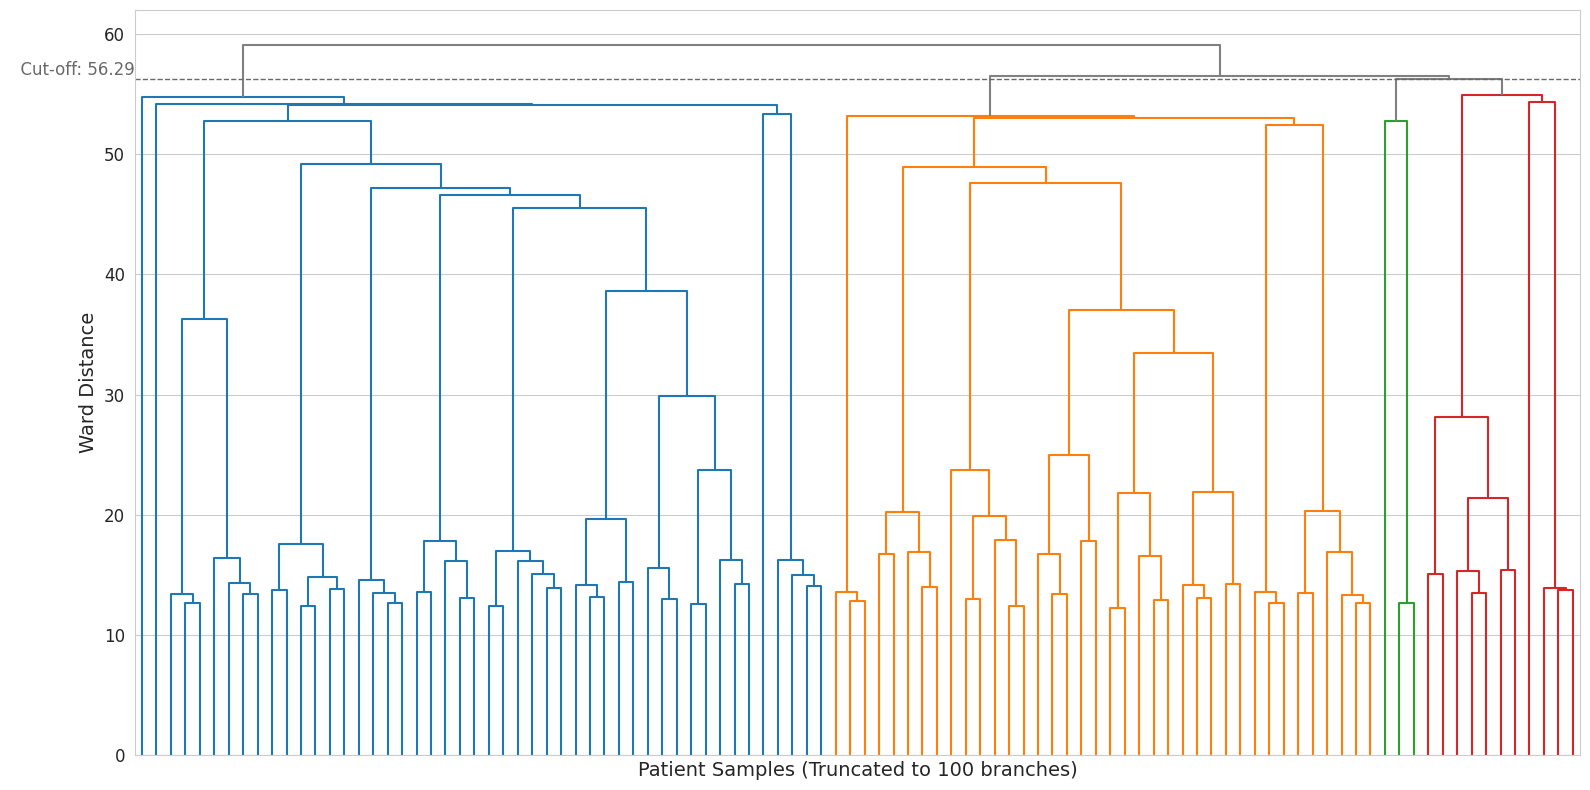


Done. Use `df_clusters` (with SUBTYPE) for KM/Cox/landmark analyses.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from cycler import cycler
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette

# ========== 0) VISUAL/FONT SETUP (robust across Colab/local) ==========
print("--- Font setup ---")
try:
    # Try to download Times New Roman only if running in Colab-like env
    if "COLAB_GPU" in os.environ or "KAGGLE_URL_BASE" in os.environ:
        import urllib.request
        url = "https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf"
        urllib.request.urlretrieve(url, "TimesNewRoman.ttf")
        fm.fontManager.addfont("TimesNewRoman.ttf")
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = "Times New Roman"
    plt.rcParams['mathtext.fontset'] = 'stix'
    print("Times New Roman enabled (or defaulted to serif).")
except Exception as e:
    print(f"Font setup skipped: {e}")

# ========== 1) DATA LOAD ==========
CSV_PATH = "/content/Patient_Master_Table.csv"  # <- change path if needed

try:
    df_master = pd.read_csv(CSV_PATH)
    print(f"Loaded: {CSV_PATH}  (n={len(df_master)})")
except FileNotFoundError:
    # Create a dummy dataset if the file isn't found, so the script can run
    print(f"Warning: Could not find data at {CSV_PATH}. Creating dummy data.")
    np.random.seed(42)
    N_SAMPLES = 1479
    data = {
        'Age at primary Diagnosis': np.random.normal(70, 8, N_SAMPLES),
        'Gender': np.random.choice(['Male', 'Female'], N_SAMPLES),
        'Region of birth': np.random.choice(['A', 'B', 'C'], N_SAMPLES),
        'Cancer site': np.random.choice(['Lung', 'Other'], N_SAMPLES),
        'Diagnosis_Class': np.random.choice(['Primary', 'Recurrent'], N_SAMPLES),
        'Morphology_Grouped': np.random.choice(['Adeno', 'Squamous', 'Other'], N_SAMPLES),
        'Laterality_Clean': np.random.choice(['Left', 'Right'], N_SAMPLES),
        'T_stage_final': np.random.choice(['T1', 'T2', 'T3', 'T4'], N_SAMPLES),
        'N_stage_final': np.random.choice(['N0', 'N1', 'N2'], N_SAMPLES),
        'M_stage_final': np.random.choice(['M0', 'M1'], N_SAMPLES),
        'Stage_Grouped_Final': np.random.choice(['I', 'II', 'III', 'IV'], N_SAMPLES),
        'ECOG_score': np.random.choice([0, 1, 2, 3], N_SAMPLES)
    }
    df_master = pd.DataFrame(data)
    # Introduce some random NaNs to simulate real data
    for col in df_master.columns:
        if np.random.rand() > 0.5 and col != 'Stage_Grouped_Final':
            df_master.loc[df_master.sample(frac=0.1).index, col] = np.nan

# ========== 2) BASELINE-ONLY WHITELIST ==========
BASELINE_WHITELIST = [
    'Age at primary Diagnosis',
    'Gender',
    'Region of birth',
    'Primary cancer site',      # if your file uses "Cancer site", we fix below
    'Diagnosis_Class',
    'Morphology_Grouped',
    'Laterality_Clean',
    'T_stage_final',
    'N_stage_final',
    'M_stage_final',
    'Stage_Grouped_Final',
    'ECOG_score'                # or 'ECOG_category' if you prefer
]

# Resolve site-column alias
if 'Primary cancer site' not in df_master.columns and 'Cancer site' in df_master.columns:
    BASELINE_WHITELIST = [c if c != 'Primary cancer site' else 'Cancer site' for c in BASELINE_WHITELIST]

# Keep only columns that actually exist
baseline_features = [c for c in BASELINE_WHITELIST if c in df_master.columns]
if not baseline_features:
    raise SystemExit("No baseline features from the whitelist were found in the CSV columns.")

print("\n--- Baseline-only features used ---")
for i, c in enumerate(baseline_features, 1):
    print(f"  {i}. {c}")

# Subset and complete-case on baseline features only
df_sub = df_master[baseline_features].copy()
n0 = len(df_sub)
df_sub = df_sub.dropna()
print(f"\nCohort size after complete-case on baseline features: {len(df_sub)} "
      f"(dropped {n0 - len(df_sub)})")

# Handle case where dummy data dropna removes too much
if len(df_sub) < 50:
    print("Warning: Very few samples after dropna. Re-using full dummy data for plotting demo.")
    df_sub = df_master[baseline_features].copy().fillna(method='ffill').fillna(method='bfill')
    if 'ECOG_score' in df_sub.columns:
        df_sub['ECOG_score'] = pd.to_numeric(df_sub['ECOG_score'], errors='coerce').fillna(0)
    if 'Age at primary Diagnosis' in df_sub.columns:
         df_sub['Age at primary Diagnosis'] = pd.to_numeric(df_sub['Age at primary Diagnosis'], errors='coerce').fillna(70)


# ========== 3) OPTIONAL: MAP STAGE FIELDS TO ORDINALS ==========
STAGE_MAP = {
    '0': 0, '0a': 0, '0is': 0,
    'I': 1, 'IA': 1, 'IA1': 1, 'IA2': 1, 'IA3': 1, 'IB': 1,
    'II': 2, 'IIA': 2, 'IIB': 2,
    'III': 3, 'IIIA': 3, 'IIIB': 3, 'IIIC': 3,
    'IV': 4, 'IVA': 4, 'IVB': 4, 'IVC': 4
}

def _map_stage_series(s):
    # Works if stage labels vary in case/spaces
    s2 = s.astype(str).str.upper().str.replace(r'\s+', '', regex=True)
    return s2.map(STAGE_MAP)

if 'Stage_Grouped_Final' in df_sub.columns:
    mapped = _map_stage_series(df_sub['Stage_Grouped_Final'])
    if mapped.notna().mean() > 0.5:
        df_sub['Stage_Grouped_Final_ORD'] = mapped
        use_stage_ordinal = True
    else:
        use_stage_ordinal = False
else:
    use_stage_ordinal = False

# ========== 4) ENCODING ==========
cat_cols = [c for c in df_sub.columns
            if df_sub[c].dtype == 'object' or str(df_sub[c].dtype).startswith('category')]

exclude_from_dummies = []
if use_stage_ordinal:
    exclude_from_dummies.append('Stage_Grouped_Final')

cat_cols = [c for c in cat_cols if c not in exclude_from_dummies]
df_enc = pd.get_dummies(df_sub, columns=cat_cols, drop_first=True)

# Ensure all data is numeric for scaling
non_numeric_cols = df_enc.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print(f"Warning: Non-numeric columns remain: {non_numeric_cols}. Forcing numeric.")
    for col in non_numeric_cols:
        df_enc[col] = pd.to_numeric(df_enc[col], errors='coerce').fillna(0)

# ========== 5) STANDARDIZE ==========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_enc)

# ========== 6) PCA TO ~90% VARIANCE ==========
pca_full = PCA().fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_comp = int(np.searchsorted(cum_var, 0.90) + 1)  # keep ~90% variance
n_comp = min(n_comp, X_scaled.shape[1])
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA components kept: {n_comp} (≈{cum_var[n_comp-1]*100:.1f}% variance)")

# ========== 7) WARD HIERARCHICAL CLUSTERING ==========
Z = linkage(X_pca, method='ward')
print("\n--- Clustering complete (baseline-only) ---")

# Choose k clusters
k = 4

# *** CHANGE 1: Corrected color_threshold indexing ***
# To get k clusters, you cut at the (k-1)th merge from the top
# For k=4, this is Z[-3, 2]. The general formula is Z[-(k-1), 2].
if Z.shape[0] < k:
     raise SystemExit(f"Error: Linkage matrix Z has only {Z.shape[0]} clusters. Cannot form k={k} clusters.")
color_threshold = Z[-(k-1), 2]

labels = fcluster(Z, t=color_threshold, criterion='distance')

# Attach labels for downstream survival analyses
df_clusters = df_sub.copy()
df_clusters["SUBTYPE"] = labels
print("\nCluster sizes (k=4):")
print(df_clusters["SUBTYPE"].value_counts().sort_index())

# Quick silhouette (on PCA space) for sanity
try:
    sil = silhouette_score(X_pca, labels, metric="euclidean")
    print(f"Silhouette (k={k}): {sil:.3f}")
except Exception as e:
    print(f"Silhouette skipped: {e}")

# ========== 8) DENDROGRAM PLOT ==========

# *** CHANGE 2: Removed 'viridis' palette to use distinct default colors ***
# Reset Matplotlib defaults to use the default 'tab10' color cycle.
# This provides distinct 'blue', 'orange', 'green', 'red' colors.
set_link_color_palette(['C0', 'C1', 'C2', 'C3'])
plt.rcdefaults()
sns.set_style("whitegrid")

plt.figure(figsize=(16, 8))
# *** CHANGE 3: Added Title and clarified X-axis label ***
#plt.title("Figure 1A: Dendrogram of Patient Archetypes (k=4)", fontsize=16, pad=10)
plt.ylabel("Ward Distance", fontsize=14)
plt.xlabel("Patient Samples (Truncated to 100 branches)", fontsize=14)

dendrogram(
    Z,
    truncate_mode='lastp',
    p=100,                     # show last p merged clusters' leaves
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=color_threshold,
    above_threshold_color='grey'
)

plt.xticks([])  # cleaner x-axis
for label in plt.gca().get_yticklabels():
    label.set_fontsize(12)

plt.axhline(y=color_threshold, c='dimgrey', lw=1, linestyle='--')
x_limit = plt.gca().get_xlim()[1] # Get the right-most x-limit
plt.text(
    x_limit * 0, # Position at 98% of the right side
    color_threshold,
    f'  Cut-off: {color_threshold:.2f}',
    ha='right',
    va='bottom', # Position text *above* the line
    fontsize=12,
    color='dimgrey'
)
plt.tight_layout()
plt.savefig("dendrogram_distinct_colors.png", dpi=300, bbox_inches='tight')
print(f"\n--- Plot saved as 'dendrogram_distinct_colors.png' ---")
plt.show()

# Reset mpl defaults again
plt.rcdefaults()

# ========== 9) OPTIONAL: MERGE BACK TO DOWNSTREAM ANALYSES ==========
print("\nDone. Use `df_clusters` (with SUBTYPE) for KM/Cox/landmark analyses.")


###Subtype Profiling

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import kruskal, chi2_contingency
from IPython.display import display

np.random.seed(42)

# ----------------------
# 1) LOAD DATA
# ----------------------
CSV_PATH = "/content/Patient_Master_Table.csv"  # <-- change if needed
if not os.path.exists(CSV_PATH):
    raise SystemExit(f"Could not find data at {CSV_PATH}")
df_master = pd.read_csv(CSV_PATH)
print(f"Loaded: {CSV_PATH} (n={len(df_master)})")

# ----------------------
# 2) BASELINE WHITELIST (EXACTLY AS SCRIPT 1)
# ----------------------
BASELINE_WHITELIST = [
    'Age at primary Diagnosis',
    'Gender',
    'Region of birth',
    'Primary cancer site',      # alias to 'Cancer site' if needed
    'Diagnosis_Class',
    'Morphology_Grouped',
    'Laterality_Clean',
    'T_stage_final',
    'N_stage_final',
    'M_stage_final',
    'Stage_Grouped_Final',
    'ECOG_score'                # NOTE: ECOG_score, not ECOG_category
]

# Alias: if file uses 'Cancer site' instead of 'Primary cancer site'
if 'Primary cancer site' not in df_master.columns and 'Cancer site' in df_master.columns:
    BASELINE_WHITELIST = [
        ('Cancer site' if c == 'Primary cancer site' else c) for c in BASELINE_WHITELIST
    ]

# Keep only columns that actually exist
baseline_features = [c for c in BASELINE_WHITELIST if c in df_master.columns]
if not baseline_features:
    raise SystemExit("None of the baseline whitelist columns are present in the CSV.")

print("\n--- Baseline-only features used (mirror of Script 1) ---")
for i, c in enumerate(baseline_features, 1):
    print(f"  {i}. {c}")

# Subset and complete-case on baseline features only (mirror of Script 1)
df_sub = df_master[baseline_features].copy()
n0 = len(df_sub)
df_sub = df_sub.dropna()
print(f"Cohort size after complete-case on baseline features: {len(df_sub)} "
      f"(dropped {n0 - len(df_sub)})")

# ----------------------
# 3) OPTIONAL: MAP STAGE GROUP TO ORDINAL (MIRROR OF SCRIPT 1)
# ----------------------
STAGE_MAP = {
    '0': 0, '0A': 0, '0IS': 0,
    'I': 1, 'IA': 1, 'IA1': 1, 'IA2': 1, 'IA3': 1, 'IB': 1,
    'II': 2, 'IIA': 2, 'IIB': 2,
    'III': 3, 'IIIA': 3, 'IIIB': 3, 'IIIC': 3,
    'IV': 4, 'IVA': 4, 'IVB': 4, 'IVC': 4
}

def _map_stage_series(s):
    s2 = s.astype(str).str.upper().str.replace(r'\s+', '', regex=True)
    return s2.map(STAGE_MAP)

use_stage_ordinal = False
if 'Stage_Grouped_Final' in df_sub.columns:
    mapped = _map_stage_series(df_sub['Stage_Grouped_Final'])
    if mapped.notna().mean() > 0.5:  # only replace if mapping is sensible
        df_sub['Stage_Grouped_Final_ORD'] = mapped
        use_stage_ordinal = True

# ----------------------
# 4) ENCODING (MIRROR OF SCRIPT 1)
# ----------------------
# Identify categorical columns (object/category)
cat_cols = [c for c in df_sub.columns
            if df_sub[c].dtype == 'object' or str(df_sub[c].dtype).startswith('category')]

# If we created an ordinal for stage, EXCLUDE the original stage string from one-hot
exclude_from_dummies = []
if use_stage_ordinal and 'Stage_Grouped_Final' in cat_cols:
    exclude_from_dummies.append('Stage_Grouped_Final')
cat_cols = [c for c in cat_cols if c not in exclude_from_dummies]

# One-hot encode remaining categoricals ONLY (drop_first to match Script 1)
df_enc = pd.get_dummies(df_sub, columns=cat_cols, drop_first=True)

# ----------------------
# 5) STANDARDIZE + PCA (~90% variance) (MIRROR OF SCRIPT 1)
# ----------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_enc)

pca_full = PCA().fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_comp = int(np.searchsorted(cum_var, 0.90) + 1)  # keep ~90% variance
n_comp = min(n_comp, X_scaled.shape[1])
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)
print(f"\n✅ PCA components kept: {n_comp} (≈{cum_var[n_comp-1]*100:.1f}% variance)")

# ----------------------
# 6) WARD HIERARCHICAL + DISTANCE CUT (MIRROR OF SCRIPT 1)
# ----------------------
Z = linkage(X_pca, method='ward')
k = 4
color_threshold = Z[-k, 2]
labels = fcluster(Z, t=color_threshold, criterion='distance')

df_profile = df_sub.copy()
df_profile['Subtype'] = labels

# Silhouette on PCA space (euclidean)
try:
    sil = silhouette_score(X_pca, labels, metric="euclidean")
    print(f"✅ Silhouette (k={k}): {sil:.3f}")
except Exception as e:
    print(f"ℹ️ Silhouette skipped: {e}")

print("\nSubtype sizes:")
print(df_profile['Subtype'].value_counts().sort_index())

# ----------------------
# 7) SUBTYPE PROFILING TABLE (unchanged)
# ----------------------
variables_to_summarize = {
    'Age at primary Diagnosis': 'continuous',
    'Gender': 'categorical',
    'Stage_Grouped_Final': 'categorical',
    'Morphology_Grouped': 'categorical',
    'Diagnosis_Class': 'categorical',
    # NOTE: ECOG_score is continuous; if you prefer categorical ECOG, supply ECOG_category in data and adjust above.
}

def summarize_continuous(df_in, variable):
    s = df_in[variable]
    overall = f"{s.median():.1f} [{s.quantile(0.25):.1f}–{s.quantile(0.75):.1f}]"
    groups = [df_in.loc[df_in['Subtype'] == g, variable].dropna() for g in sorted(df_in['Subtype'].unique())]
    _, p_val = kruskal(*[g for g in groups if len(g) > 0])
    by_grp = (
        df_in.groupby('Subtype')[variable]
        .apply(lambda x: f"{x.median():.1f} [{x.quantile(0.25):.1f}–{x.quantile(0.75):.1f}]")
        .to_dict()
    )
    return {"overall": overall, "by_group": by_grp, "pval": p_val}

def summarize_categorical(df_in, variable):
    counts = df_in[variable].value_counts()
    perc = df_in[variable].value_counts(normalize=True) * 100
    overall = {k: f"{counts[k]} ({perc[k]:.1f}%)" for k in counts.index}
    ct = pd.crosstab(df_in['Subtype'], df_in[variable])
    ct_rowp = ct.div(ct.sum(axis=1), axis=0) * 100
    by_grp = {g: {col: f"{int(ct.loc[g, col])} ({ct_rowp.loc[g, col]:.1f}%)" for col in ct.columns} for g in ct.index}
    _, p_val, _, _ = chi2_contingency(ct)
    return {"overall": overall, "by_group": by_grp, "pval": p_val, "levels": ct.columns}

subtypes = sorted(df_profile['Subtype'].unique())
rows = []
header = ["Characteristic", f"Overall (n={len(df_profile)})"] + [
    f"Subtype {s} (n={df_profile['Subtype'].value_counts()[s]})" for s in subtypes
] + ["P-value"]
rows.append(header)

for var, vtype in variables_to_summarize.items():
    if var not in df_profile.columns:
        continue
    if vtype == "continuous":
        res = summarize_continuous(df_profile, var)
        row = [f"{var} (median [IQR])", res["overall"]] + [res["by_group"].get(s, "") for s in subtypes] + [f"{res['pval']:.3g}"]
        rows.append(row)
    else:
        res = summarize_categorical(df_profile, var)
        rows.append([f"{var}, n (%)", "", *["" for _ in subtypes], f"{res['pval']:.3g}"])
        for lvl in res["levels"]:
            row = [f"  {lvl}", res["overall"].get(lvl, "0 (0.0%)")] + [
                res["by_group"].get(s, {}).get(lvl, "0 (0.0%)") for s in subtypes
            ] + [""]
            rows.append(row)

profile_table = pd.DataFrame(rows[1:], columns=rows[0])
print("\n--- Subtype Profiling Table (preview) ---")
try:
    display(profile_table.head(20))
except Exception:
    print(profile_table.head(20).to_string(index=False))

# # ----------------------
# # 8) EXPORTS
# # ----------------------
# df_profile.to_csv("Baseline_Subtype_Profile_FINAL.csv", index=False)
profile_table.to_csv("Subtype_Profile_Table_FINAL.csv", index=False)
# print("\n✅ Exported:")
# print(" - Baseline_Subtype_Profile_FINAL.csv")
# print(" - Subtype_Profile_Table_FINAL.csv")


Loaded: /content/Patient_Master_Table.csv (n=2514)

--- Baseline-only features used (mirror of Script 1) ---
  1. Age at primary Diagnosis
  2. Gender
  3. Region of birth
  4. Primary cancer site
  5. Diagnosis_Class
  6. Morphology_Grouped
  7. Laterality_Clean
  8. T_stage_final
  9. N_stage_final
  10. M_stage_final
  11. Stage_Grouped_Final
  12. ECOG_score
Cohort size after complete-case on baseline features: 1479 (dropped 1035)

✅ PCA components kept: 31 (≈90.8% variance)
✅ Silhouette (k=4): 0.053

Subtype sizes:
Subtype
1    602
2    702
3     34
4    141
Name: count, dtype: int64

--- Subtype Profiling Table (preview) ---


,Characteristic,Overall (n=1479),Subtype 1 (n=602),Subtype 2 (n=702),Subtype 3 (n=34),Subtype 4 (n=141),P-value
0,Age at primary Diagnosis (median [IQR]),71.0 [63.0–77.0],70.0 [62.2–76.0],71.0 [64.0–77.0],69.0 [64.0–72.8],72.0 [63.0–78.0],0.0941
1,"Gender, n (%)",,,,,,0.000615
2,Female,663 (44.8%),236 (39.2%),348 (49.6%),20 (58.8%),59 (41.8%),
3,Male,816 (55.2%),366 (60.8%),354 (50.4%),14 (41.2%),82 (58.2%),
4,"Stage_Grouped_Final, n (%)",,,,,,1.05e-276
5,Stage I,295 (19.9%),30 (5.0%),245 (34.9%),11 (32.4%),9 (6.4%),
6,Stage II,125 (8.5%),8 (1.3%),9 (1.3%),3 (8.8%),105 (74.5%),
7,Stage III,368 (24.9%),84 (14.0%),269 (38.3%),5 (14.7%),10 (7.1%),
8,Stage IV,691 (46.7%),480 (79.7%),179 (25.5%),15 (44.1%),17 (12.1%),
9,"Morphology_Grouped, n (%)",,,,,,1.74e-55


In [ ]:
# 0) make column names safe (in case of stray spaces/case)
df_master.columns = df_master.columns.str.strip()
df_profile.columns = df_profile.columns.str.strip()

# 1) add the ID into df_profile by index alignment (df_profile came from df_master.dropna(...))
df_profile = df_profile.copy()
df_profile['LINKAGE CODE'] = df_master.loc[df_profile.index, 'LINKAGE CODE'].values
print("Added LINKAGE CODE to df_profile:", 'LINKAGE CODE' in df_profile.columns)

# 2) pick treatment/outcome columns that REALLY exist in your master table
wanted = [
    'LINKAGE CODE',
    'SABR_FLAG', 'Chemo_FLAG', 'Surgery_FLAG',
    'RT_Category',            # you have this (not RT_FLAG)
    'SABR_DoseBased_FLAG',    # optional, if present
    'OS_event', 'PFS_event', 'OS_days', 'PFS_days'
]
avail = [c for c in wanted if c in df_master.columns]
skip  = [c for c in wanted if c not in df_master.columns]
print("Will merge:", avail)
if skip: print("Not found (skipped):", skip)

# 3) merge onto the clustered cohort (n=1479)
df_profile = df_profile.merge(df_master[avail], on='LINKAGE CODE', how='left')
print("Merged shape:", df_profile.shape)

# 4) optional: create a simple RT_FLAG and clean 0/1 ints
if 'RT_Category' in df_profile.columns and 'RT_FLAG' not in df_profile.columns:
    df_profile['RT_FLAG'] = df_profile['RT_Category'].notna().astype(int)

for c in ['SABR_FLAG','Chemo_FLAG','Surgery_FLAG','RT_FLAG','SABR_DoseBased_FLAG','OS_event','PFS_event']:
    if c in df_profile.columns:
        df_profile[c] = (df_profile[c].astype(float).fillna(0) > 0).astype(int)

# 5) quick sanity checks
print("\nSubtype counts:")
print(df_profile['Subtype'].value_counts().sort_index())

need_show = [c for c in ['Subtype','SABR_FLAG','Chemo_FLAG','Surgery_FLAG','RT_FLAG','OS_event','OS_days'] if c in df_profile.columns]
print("\nPreview of key columns:")
print(df_profile[need_show].head(10))


Added LINKAGE CODE to df_profile: True
Will merge: ['LINKAGE CODE', 'SABR_FLAG', 'Chemo_FLAG', 'Surgery_FLAG', 'RT_Category', 'SABR_DoseBased_FLAG', 'OS_event', 'PFS_event', 'OS_days', 'PFS_days']
Merged shape: (1479, 23)

Subtype counts:
Subtype
1    602
2    702
3     34
4    141
Name: count, dtype: int64

Preview of key columns:
   Subtype  SABR_FLAG  Chemo_FLAG  Surgery_FLAG  RT_FLAG  OS_event  OS_days
0        2          0           1             0        1         0      NaN
1        2          0           0             0        1         0   1969.0
2        1          0           1             0        1         1    222.0
3        2          0           0             0        1         1    950.0
4        1          1           1             0        1         1    623.0
5        4          0           1             0        1         1   3195.0
6        1          0           1             0        1         1    108.0
7        1          1           1             0        1  

### Treatment Stratification

In [ ]:
# ============================================================
# BLOCK A (clean): Subtype × Treatment × Outcome in CLUSTERED COHORT
# Uses df_profile (n=1,479) with Subtype + treatment + outcomes
# ============================================================

import numpy as np
import pandas as pd
import re
from scipy.stats import chi2_contingency, kruskal
import statsmodels.formula.api as smf
from IPython.display import display

# ---------- 0) INPUT ----------
if 'df_profile' not in globals():
    raise RuntimeError("df_profile not found. Make sure you merged IDs + treatment/outcome first.")
if 'Subtype' not in df_profile.columns:
    raise RuntimeError("Subtype column missing in df_profile.")

dfA = df_profile.copy()
dfA['Subtype'] = dfA['Subtype'].astype('category')

# ---------- 1) REFERENCE SUBTYPE (largest group) ----------
ref_subtype = dfA['Subtype'].value_counts().idxmax()
cats_sorted = sorted(dfA['Subtype'].cat.categories)
dfA['Subtype'] = dfA['Subtype'].cat.set_categories(
    [ref_subtype] + [c for c in cats_sorted if c != ref_subtype], ordered=True
)
ref_literal = int(ref_subtype)
print(f"Dataset: n={len(dfA)}  |  Reference Subtype: {ref_subtype}")

# ---------- 2) TREATMENT VARIABLES PRESENT ----------
possible_treat_cols = [
    'SABR_FLAG', 'Chemo_FLAG', 'Surgery_FLAG',
    'RT_FLAG',              # created from RT_Category if you followed earlier step
    'SABR_DoseBased_FLAG'   # optional
]
treatment_vars = [c for c in possible_treat_cols if c in dfA.columns and dfA[c].nunique() >= 2]
print("Treatments found:", treatment_vars)

# clean flags to 0/1 ints
for c in treatment_vars + ['OS_event','PFS_event']:
    if c in dfA.columns:
        dfA[c] = (dfA[c].astype(float).fillna(0) > 0).astype(int)

# ---------- helpers ----------
def qname(col: str) -> str:
    return f"Q('{col}')" if re.search(r'[^A-Za-z0-9_]', col) else col

def fit_logit(formula, data):
    try:
        return smf.logit(formula, data=data).fit(disp=0)
    except Exception as e:
        print(f"   (logit failed: {e})")
        return None

def OR_table(model, label):
    import numpy as np
    ci = np.exp(model.conf_int())
    ci.columns = ["2.5%", "97.5%"]
    out = pd.DataFrame({
        "OR": np.exp(model.params),
        "2.5%": ci["2.5%"],
        "97.5%": ci["97.5%"],
        "p-value": model.pvalues
    }).drop(index="Intercept", errors="ignore")
    out.insert(0, "Model", label)
    return out.round(3)

# optional adjusters
adj_terms = []
if "Age at primary Diagnosis" in dfA.columns: adj_terms.append(qname("Age at primary Diagnosis"))
if "Gender" in dfA.columns:                   adj_terms.append("C(Gender)")
if "Stage_Grouped_Final" in dfA.columns:      adj_terms.append("C(Stage_Grouped_Final)")
ADJ_STR = (" + " + " + ".join(adj_terms)) if adj_terms else ""

# ---------- 3) DISTRIBUTION: χ² ----------
print("\n==============================")
print(" TREATMENT DISTRIBUTION BY SUBTYPE (χ² + row %)")
print("==============================")
for var in treatment_vars:
    tab = pd.crosstab(dfA['Subtype'], dfA[var])
    chi2, p, _, _ = chi2_contingency(tab)
    row_pct = (tab.div(tab.sum(axis=1), axis=0) * 100).round(1)
    print(f"\n{var}: χ² p = {p:.3g}")
    display(pd.concat({'n': tab, '%': row_pct}, axis=1))

# ---------- 4) LOGISTIC: treatment ~ Subtype (+ optional adjust) ----------
print("\n==============================")
print(" LOGISTIC REGRESSIONS: treatment ~ Subtype (+/- adjust)")
print("==============================")
for var in treatment_vars:
    print(f"\n--- {var} ---")
    dep = qname(var)
    f_unadj = f"{dep} ~ C(Subtype, Treatment(reference={ref_literal}))"
    m_unadj = fit_logit(f_unadj, dfA.dropna(subset=[var, 'Subtype']))

    m_adj = None
    if ADJ_STR:
        need = [var, 'Subtype']
        if "Age at primary Diagnosis" in dfA.columns: need.append("Age at primary Diagnosis")
        if "Gender" in dfA.columns:                   need.append("Gender")
        if "Stage_Grouped_Final" in dfA.columns:      need.append("Stage_Grouped_Final")
        f_adj = f_unadj + ADJ_STR
        m_adj = fit_logit(f_adj, dfA.dropna(subset=need))

    if m_unadj is not None: display(OR_table(m_unadj, "Unadjusted"))
    if m_adj   is not None: display(OR_table(m_adj,   "Adjusted"))

    # χ² context again for clarity
    tab = pd.crosstab(dfA['Subtype'], dfA[var])
    chi2, p, _, _ = chi2_contingency(tab)
    print(f"χ² p = {p:.3g}")

# ---------- 5) OUTCOMES (crude)
print("\n==============================")
print(" OUTCOME RATES & CRUDE MEDIANS BY SUBTYPE")
print("==============================")

for ev in ["OS_event","PFS_event"]:
    if ev in dfA.columns:
        rates = (dfA.groupby("Subtype", observed=False)[ev].mean() * 100).round(1).astype(str) + "%"
        print(f"\n{ev} (event rate):")
        display(rates)

for tcol in ["OS_days","PFS_days"]:
    if tcol in dfA.columns and dfA[tcol].notna().any():
        med = dfA.groupby("Subtype", observed=False)[tcol].median().round(1).rename("Median (days)")
        try:
            groups = [dfA.loc[dfA['Subtype']==s, tcol].dropna() for s in dfA['Subtype'].cat.categories]
            groups = [g for g in groups if len(g)]
            if len(groups) > 1:
                _, p = kruskal(*groups)
                print(f"\n{tcol}: Kruskal p = {p:.3g}")
        except Exception:
            pass
        display(med)

print("\n--- Block A complete ---")


Dataset: n=1479  |  Reference Subtype: 2
Treatments found: ['SABR_FLAG', 'Chemo_FLAG', 'Surgery_FLAG', 'SABR_DoseBased_FLAG']

 TREATMENT DISTRIBUTION BY SUBTYPE (χ² + row %)

SABR_FLAG: χ² p = 1.07e-05


n          %      
SABR_FLAG    0    1     0     1
Subtype                        
2          511  191  72.8  27.2
1          399  203  66.3  33.7
3           24   10  70.6  29.4
4          123   18  87.2  12.8


Chemo_FLAG: χ² p = 6.2e-08


n          %      
Chemo_FLAG    0    1     0     1
Subtype                         
2           332  370  47.3  52.7
1           189  413  31.4  68.6
3            12   22  35.3  64.7
4            65   76  46.1  53.9


Surgery_FLAG: χ² p = 0.12


n        %     
Surgery_FLAG    0  1     0    1
Subtype                        
2             700  2  99.7  0.3
1             598  4  99.3  0.7
3              33  1  97.1  2.9
4             139  2  98.6  1.4


SABR_DoseBased_FLAG: χ² p = 8.3e-06


n          %      
SABR_DoseBased_FLAG    0    1     0     1
Subtype                                  
2                    514  188  73.2  26.8
1                    399  203  66.3  33.7
3                     24   10  70.6  29.4
4                    123   18  87.2  12.8


 LOGISTIC REGRESSIONS: treatment ~ Subtype (+/- adjust)

--- SABR_FLAG ---


,Model,OR,2.5%,97.5%,p-value
"C(Subtype, Treatment(reference=2))[T.1]",Unadjusted,1.361,1.074,1.725,0.011
"C(Subtype, Treatment(reference=2))[T.3]",Unadjusted,1.115,0.523,2.375,0.778
"C(Subtype, Treatment(reference=2))[T.4]",Unadjusted,0.392,0.232,0.660,0.000


,Model,OR,2.5%,97.5%,p-value
"C(Subtype, Treatment(reference=2))[T.1]",Adjusted,0.735,0.544,0.993,0.045
"C(Subtype, Treatment(reference=2))[T.3]",Adjusted,0.829,0.374,1.839,0.644
"C(Subtype, Treatment(reference=2))[T.4]",Adjusted,0.793,0.384,1.635,0.530
C(Gender)[T.Male],Adjusted,0.928,0.727,1.184,0.547
C(Stage_Grouped_Final)[T.Stage II],Adjusted,0.203,0.081,0.513,0.001
C(Stage_Grouped_Final)[T.Stage III],Adjusted,0.222,0.143,0.343,0.000
C(Stage_Grouped_Final)[T.Stage IV],Adjusted,1.888,1.339,2.662,0.000
Q('Age at primary Diagnosis'),Adjusted,1.015,1.002,1.027,0.018


χ² p = 1.07e-05

--- Chemo_FLAG ---


,Model,OR,2.5%,97.5%,p-value
"C(Subtype, Treatment(reference=2))[T.1]",Unadjusted,1.961,1.562,2.461,0.000
"C(Subtype, Treatment(reference=2))[T.3]",Unadjusted,1.645,0.802,3.376,0.175
"C(Subtype, Treatment(reference=2))[T.4]",Unadjusted,1.049,0.730,1.508,0.795


,Model,OR,2.5%,97.5%,p-value
"C(Subtype, Treatment(reference=2))[T.1]",Adjusted,1.187,0.875,1.609,0.271
"C(Subtype, Treatment(reference=2))[T.3]",Adjusted,1.812,0.767,4.284,0.176
"C(Subtype, Treatment(reference=2))[T.4]",Adjusted,0.905,0.482,1.699,0.756
C(Gender)[T.Male],Adjusted,1.008,0.789,1.289,0.948
C(Stage_Grouped_Final)[T.Stage II],Adjusted,6.102,3.023,12.317,0.000
C(Stage_Grouped_Final)[T.Stage III],Adjusted,14.200,9.528,21.163,0.000
C(Stage_Grouped_Final)[T.Stage IV],Adjusted,9.136,6.168,13.532,0.000
Q('Age at primary Diagnosis'),Adjusted,0.932,0.919,0.944,0.000


χ² p = 6.2e-08

--- Surgery_FLAG ---


,Model,OR,2.5%,97.5%,p-value
"C(Subtype, Treatment(reference=2))[T.1]",Unadjusted,2.341,0.427,12.827,0.327
"C(Subtype, Treatment(reference=2))[T.3]",Unadjusted,10.606,0.938,119.958,0.056
"C(Subtype, Treatment(reference=2))[T.4]",Unadjusted,5.036,0.703,36.053,0.107


,Model,OR,2.5%,97.5%,p-value
"C(Subtype, Treatment(reference=2))[T.1]",Adjusted,2.239,0.336,14.919,0.405
"C(Subtype, Treatment(reference=2))[T.3]",Adjusted,10.433,0.862,126.243,0.065
"C(Subtype, Treatment(reference=2))[T.4]",Adjusted,10.918,1.026,116.194,0.048
C(Gender)[T.Male],Adjusted,0.412,0.100,1.695,0.219
C(Stage_Grouped_Final)[T.Stage II],Adjusted,0.472,0.019,11.689,0.647
C(Stage_Grouped_Final)[T.Stage III],Adjusted,1.931,0.165,22.531,0.600
C(Stage_Grouped_Final)[T.Stage IV],Adjusted,1.722,0.168,17.648,0.647
Q('Age at primary Diagnosis'),Adjusted,0.974,0.917,1.034,0.382


χ² p = 0.12

--- SABR_DoseBased_FLAG ---


,Model,OR,2.5%,97.5%,p-value
"C(Subtype, Treatment(reference=2))[T.1]",Unadjusted,1.391,1.097,1.764,0.006
"C(Subtype, Treatment(reference=2))[T.3]",Unadjusted,1.139,0.535,2.427,0.736
"C(Subtype, Treatment(reference=2))[T.4]",Unadjusted,0.400,0.237,0.674,0.001


,Model,OR,2.5%,97.5%,p-value
"C(Subtype, Treatment(reference=2))[T.1]",Adjusted,0.741,0.548,1.001,0.051
"C(Subtype, Treatment(reference=2))[T.3]",Adjusted,0.847,0.382,1.881,0.684
"C(Subtype, Treatment(reference=2))[T.4]",Adjusted,0.805,0.390,1.663,0.558
C(Gender)[T.Male],Adjusted,0.934,0.732,1.192,0.582
C(Stage_Grouped_Final)[T.Stage II],Adjusted,0.210,0.083,0.532,0.001
C(Stage_Grouped_Final)[T.Stage III],Adjusted,0.232,0.150,0.360,0.000
C(Stage_Grouped_Final)[T.Stage IV],Adjusted,1.969,1.394,2.781,0.000
Q('Age at primary Diagnosis'),Adjusted,1.015,1.002,1.027,0.019


χ² p = 8.3e-06

 OUTCOME RATES & CRUDE MEDIANS BY SUBTYPE

OS_event (event rate):


,OS_event
Subtype,
2,65.1%
1,78.4%
3,55.9%
4,53.9%



PFS_event (event rate):


,PFS_event
Subtype,
2,68.5%
1,84.4%
3,64.7%
4,61.7%



OS_days: Kruskal p = 3.2e-06


,Median (days)
Subtype,
2,474.0
1,348.0
3,593.0
4,535.0



PFS_days: Kruskal p = 5.64e-05


,Median (days)
Subtype,
2,358.0
1,274.5
3,339.5
4,343.0



--- Block A complete ---


### Survival / Prognostic

[Landmark 6m] kept=932; subtypes: [2, 1, 3, 4]
[Landmark 12m] kept=693; subtypes: [2, 1, 3, 4]
[Landmark 24m] kept=391; subtypes: [2, 1, 3, 4]
[Landmark 6m] kept=761; subtypes: [2, 1, 3, 4]
[Landmark 12m] kept=477; subtypes: [2, 1, 3, 4]
[Landmark 24m] kept=212; subtypes: [2, 1, 3, 4]
⚠️  PFS check (L=6m): all rows are events (no censoring). Verify PFS_days.
⚠️  PFS check (L=12m): all rows are events (no censoring). Verify PFS_days.
⚠️  PFS check (L=24m): all rows are events (no censoring). Verify PFS_days.


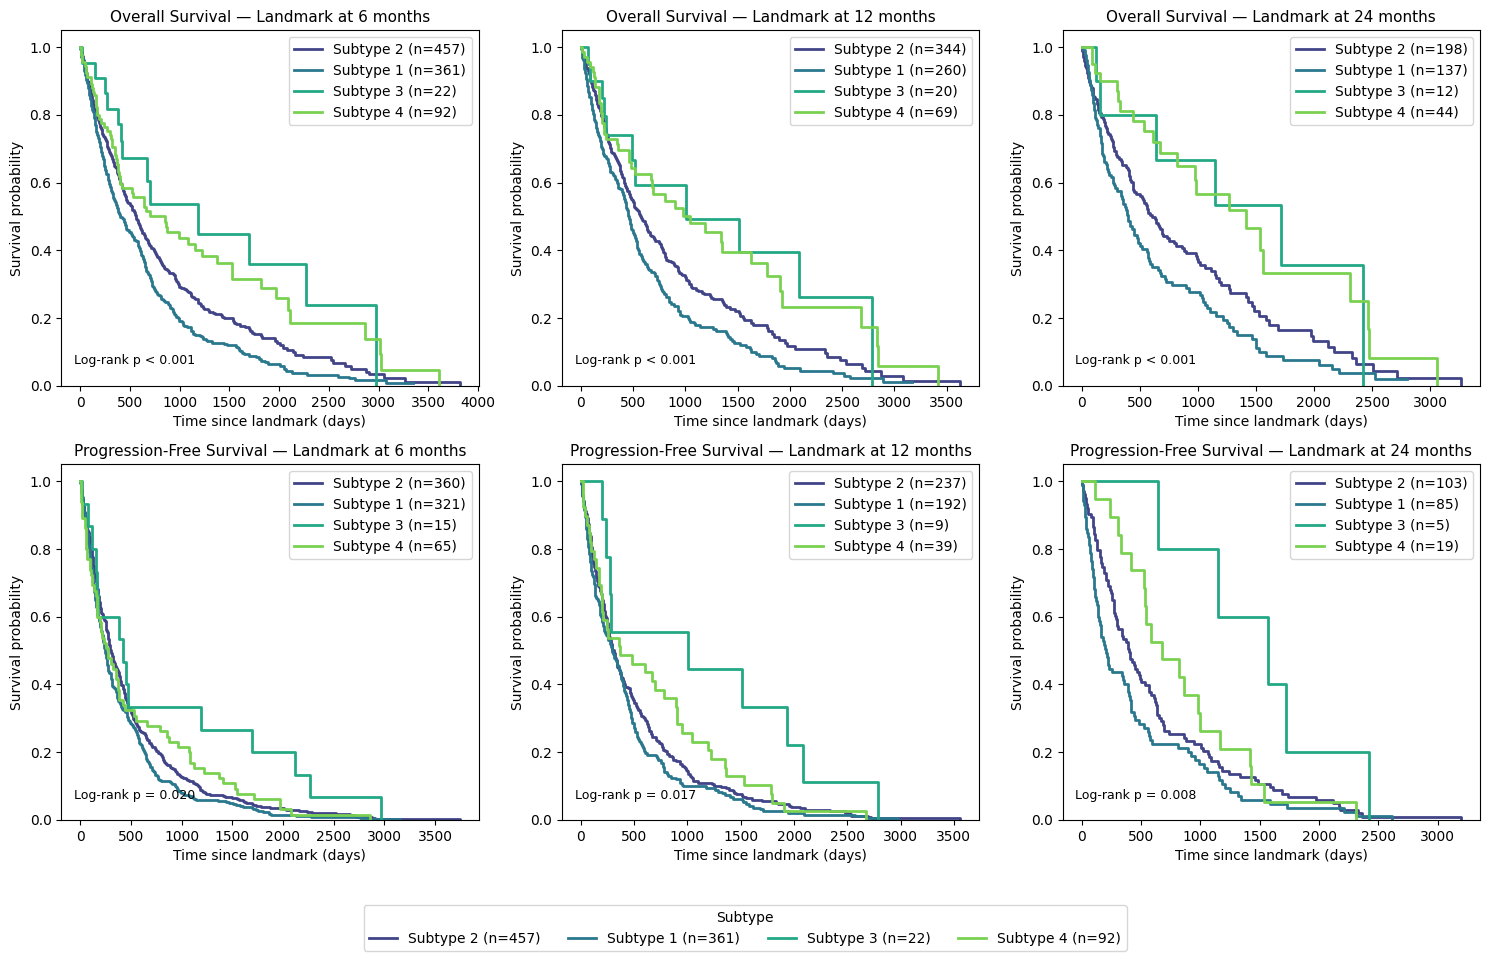

Saved combined figure -> Figure_S5A_Landmarks_OS_PFS.png


In [ ]:
# ============================================================
# Appendix S5 — Combined Landmark KM (OS & PFS × 6/12/24 mo)
# Produces one PNG: Figure_S5A_Landmarks_OS_PFS.png
# ============================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

# ---------- 0) Input check ----------
if 'df_profile' not in globals():
    raise RuntimeError("df_profile not found. Build it first (clusters + outcomes merged).")
dfB = df_profile.copy()
if 'Subtype' not in dfB.columns:
    raise RuntimeError("Subtype missing in df_profile.")

# ---------- 1) Light cleaning ----------
dfB.columns = dfB.columns.str.strip()
for c in ["OS_event","PFS_event"]:
    if c in dfB.columns:
        dfB[c] = (dfB[c].astype(float).fillna(0) > 0).astype(int)

# Ensure Subtype is ordered categorical (largest group first)
dfB['Subtype'] = dfB['Subtype'].astype('category')
largest = dfB['Subtype'].value_counts().idxmax()
cats = list(dfB['Subtype'].cat.categories)
dfB['Subtype'] = dfB['Subtype'].cat.set_categories([largest] + [c for c in sorted(cats) if c != largest],
                                                   ordered=True)

# ---------- 2) Landmark helpers ----------
def landmark_subset(df, time_col, event_col, L_months):
    """Return dataset restricted to survivors at landmark L, with _LM columns."""
    L_days = int(round(L_months * 30.4375))
    req = [time_col, event_col, 'Subtype']
    d = df.dropna(subset=req).copy()
    if d.empty:
        return d
    keep = (d[time_col] > L_days) | (d[event_col] == 0)
    cols = ['Subtype', time_col, event_col]
    if "Age at primary Diagnosis" in d.columns: cols.append("Age at primary Diagnosis")
    if "Gender" in d.columns:                   cols.append("Gender")
    d = d.loc[keep, cols].copy()
    if d.empty:
        return d
    d[f"{time_col}_LM"]  = (d[time_col] - L_days).clip(lower=0)
    d[f"{event_col}_LM"] = (d[event_col] * (d[time_col] > L_days)).astype(int)
    d = d[d[f"{time_col}_LM"] > 0].copy()
    d['Subtype'] = d['Subtype'].astype('category').cat.remove_unused_categories()
    print(f"[Landmark {L_months}m] kept={len(d)}; subtypes: {list(d['Subtype'].cat.categories)}")
    return d

# ---------- 3) Plotting on a provided Axes ----------
def _km_on_ax(data, time_col, event_col, title, L, ax):
    """Plot KM by Subtype on provided Axes; annotate log-rank p."""
    if data is None or data.empty or data['Subtype'].nunique() < 2:
        ax.set_axis_off()
        ax.text(0.5, 0.5, f"No data for {title} (L={L}m)", ha='center', va='center')
        return
    lm_t, lm_e = f"{time_col}_LM", f"{event_col}_LM"
    data = data.dropna(subset=[lm_t, lm_e, 'Subtype']).copy()
    data['Subtype'] = data['Subtype'].cat.remove_unused_categories()
    subs = list(data['Subtype'].cat.categories)

    palette = sns.color_palette("viridis", len(subs))
    kmf = KaplanMeierFitter()
    for i, s in enumerate(subs):
        ds = data[data['Subtype'] == s]
        kmf.fit(ds[lm_t], event_observed=ds[lm_e], label=f"Subtype {s} (n={len(ds)})")
        kmf.plot(ax=ax, ci_show=False, color=palette[i], lw=2)

    # log-rank p-value
    res = multivariate_logrank_test(data[lm_t], data['Subtype'], data[lm_e])
    p_text = "p < 0.001" if res.p_value < 1e-3 else f"p = {res.p_value:.3f}"

    ax.set_title(f"{title} — Landmark at {L} months", fontsize=11)
    ax.set_xlabel("Time since landmark (days)")
    ax.set_ylabel("Survival probability")
    ax.set_ylim(0, 1.05)
    ax.text(0.03, 0.06, f"Log-rank {p_text}", transform=ax.transAxes, fontsize=9)

# ---------- 4) Combined figure ----------
def combined_landmark_km(df, L_list=(6,12,24), save_path="Figure_S5A_Landmarks_OS_PFS.png"):
    have_os  = {"OS_days","OS_event"}.issubset(df.columns)
    have_pfs = {"PFS_days","PFS_event"}.issubset(df.columns)

    osL  = {L: (landmark_subset(df, "OS_days", "OS_event", L) if have_os else None) for L in L_list}
    pfsL = {L: (landmark_subset(df, "PFS_days", "PFS_event", L) if have_pfs else None) for L in L_list}

    n_rows = 1 if not have_pfs else 2
    fig, axes = plt.subplots(n_rows, len(L_list),
                             figsize=(15, 4.8 if n_rows==1 else 9.6),
                             sharex=False, sharey=False)
    if n_rows == 1:
        axes = np.atleast_2d(axes)

    # Row 1: OS
    if have_os:
        for j, L in enumerate(L_list):
            _km_on_ax(osL[L], "OS_days", "OS_event", "Overall Survival", L, axes[0, j])
    else:
        for j in range(len(L_list)):
            axes[0, j].set_axis_off()
            axes[0, j].text(0.5, 0.5, "No OS columns", ha='center', va='center')

    # Row 2: PFS
    if have_pfs:
        for j, L in enumerate(L_list):
            _km_on_ax(pfsL[L], "PFS_days", "PFS_event", "Progression-Free Survival", L, axes[1, j])
        # warn if no censoring
        for L in L_list:
            d = pfsL[L]
            if d is not None and not d.empty and d["PFS_event_LM"].sum() == len(d):
                print(f"⚠️  PFS check (L={L}m): all rows are events (no censoring). Verify PFS_days.")

    # Build a single shared legend from any axes with lines
    handles, labels = None, None
    for ax in fig.axes:
        lines = [l for l in ax.get_lines() if l.get_label() and not l.get_label().startswith("_")]
        if lines:
            handles = lines
            labels = [l.get_label() for l in lines]
            break
    if handles and labels:
        fig.legend(handles, labels, loc="lower center",
                   ncol=min(4, len(labels)), title="Subtype", frameon=True)

    plt.tight_layout(rect=[0, 0.08, 1, 1])  # space for legend
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved combined figure ->", save_path)

# ---------- 5) Run ----------
combined_landmark_km(dfB, L_list=(6,12,24), save_path="Figure_S5A_Landmarks_OS_PFS.png")


In [ ]:
# ============================================================
# OS: ΔC-index for adding Subtype beyond TNM/ECOG (robust)
# ============================================================

import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.utils import resample
from scipy.stats import chi2

# 0) Source: clustered cohort only
if 'df_profile' not in globals():
    raise RuntimeError("df_profile not found.")
df = df_profile.copy()

# 1) Clean basics
need_time_event = ["OS_days", "OS_event", "Subtype", "Stage_Grouped_Final"]
missing = [c for c in need_time_event if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns: {missing}")

df["OS_event"] = (df["OS_event"].astype(float).fillna(0) > 0).astype(int)
df["Subtype"]  = df["Subtype"].astype("category")

# 2) Pick available covariates safely
cov_base_raw = []
if "Age at primary Diagnosis" in df.columns:
    cov_base_raw.append("Age at primary Diagnosis")
if "Gender" in df.columns:
    cov_base_raw.append("Gender")

cov_tnm_raw  = ["Stage_Grouped_Final"]  # required
cov_ecog_raw = []
if "ECOG_score" in df.columns:
    cov_ecog_raw = ["ECOG_score"]
elif "ECOG_category" in df.columns:
    cov_ecog_raw = ["ECOG_category"]

# 3) Build the actual analysis set (drop rows missing in required cols)
use_cols = ["OS_days","OS_event","Subtype"] + cov_base_raw + cov_tnm_raw + cov_ecog_raw
d = df.dropna(subset=use_cols).copy()
d["Subtype"] = d["Subtype"].cat.remove_unused_categories()
print(f"OS comparison sample n={len(d)}; subtypes={list(d['Subtype'].cat.categories)}")
print("Covariates used:")
print("  Base:", cov_base_raw if cov_base_raw else "(none)")
print("  TNM :", cov_tnm_raw)
print("  ECOG:", cov_ecog_raw if cov_ecog_raw else "(none)")

# 4) Build Patsy formulas from the *raw* column names
def q(col):  # quote if spaces
    return f"Q('{col}')" if any(ch in col for ch in " -+/()[]") else col

cov_base = [q(c) if c != "Gender" else "C(Gender)" for c in cov_base_raw]
cov_tnm  = ["C(Stage_Grouped_Final)"]
cov_ecog = [q("ECOG_score")] if "ECOG_score" in cov_ecog_raw else (["C(ECOG_category)"] if "ECOG_category" in cov_ecog_raw else [])

formula_null = " + ".join(cov_base + cov_tnm + cov_ecog) if (cov_base or cov_tnm or cov_ecog) else "1"
formula_full = formula_null + " + C(Subtype)"

# 5) Fit penalized Cox models (ridge to stabilize)
m_null = CoxPHFitter(penalizer=0.01).fit(d, duration_col="OS_days", event_col="OS_event", formula=formula_null)
m_full = CoxPHFitter(penalizer=0.01).fit(d, duration_col="OS_days", event_col="OS_event", formula=formula_full)

print("\n--- OS Cox (TNM/ECOG without Subtype) ---")
m_null.print_summary(decimals=3)
print(f"Concordance (apparent): {m_null.concordance_index_:.3f}")

print("\n--- OS Cox (TNM/ECOG + Subtype) ---")
m_full.print_summary(decimals=3)
print(f"Concordance (apparent): {m_full.concordance_index_:.3f}")

# 6) Likelihood-ratio test for the added Subtype term(s)
lr_stat = 2 * (m_full.log_likelihood_ - m_null.log_likelihood_)
df_diff = m_full.params_.shape[0] - m_null.params_.shape[0]
p_lr = 1 - chi2.cdf(lr_stat, df_diff)
print(f"\nLikelihood-ratio test (Subtype added): χ²={lr_stat:.3f} on {df_diff} df, p={p_lr:.4g}")

# 7) Bootstrap C-index (and ΔC-index) with refit per resample
def cindex(model, data):
    ph = model.predict_partial_hazard(data)
    return model._concordance_index(data["OS_days"].values, -ph.values, data["OS_event"].values)

rng = np.random.RandomState(42)
B = 100  # reduce to 100 for speed, increase to 1000 for final
C0, C1, dC = [], [], []
for _ in range(B):
    dd = d.sample(len(d), replace=True, random_state=rng.randint(0, 10**9))
    try:
        m0 = CoxPHFitter(penalizer=0.01).fit(dd, duration_col="OS_days", event_col="OS_event", formula=formula_null)
        m1 = CoxPHFitter(penalizer=0.01).fit(dd, duration_col="OS_days", event_col="OS_event", formula=formula_full)
        c0 = cindex(m0, dd); c1 = cindex(m1, dd)
        C0.append(c0); C1.append(c1); dC.append(c1 - c0)
    except Exception:
        pass

def ci(a):
    a = np.array(a)
    return a.mean(), np.percentile(a, 2.5), np.percentile(a, 97.5)

if len(C0) and len(C1) and len(dC):
    m0, lo0, hi0 = ci(C0)
    m1, lo1, hi1 = ci(C1)
    md, lod, hid = ci(dC)
    print(f"\nC-index (TNM/ECOG): {m0:.3f} [{lo0:.3f}, {hi0:.3f}]")
    print(f"C-index (TNM/ECOG + Subtype): {m1:.3f} [{lo1:.3f}, {hi1:.3f}]")
    print(f"ΔC-index: {md:.3f} [{lod:.3f}, {hid:.3f}]")
else:
    print("Bootstrap CIs unavailable (all resamples failed).")


OS comparison sample n=1255; subtypes=[1, 2, 3, 4]
Covariates used:
  Base: ['Age at primary Diagnosis', 'Gender']
  TNM : ['Stage_Grouped_Final']
  ECOG: ['ECOG_score']

--- OS Cox (TNM/ECOG without Subtype) ---


<lifelines.CoxPHFitter: fitted with 1255 total observations, 231 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1255
number of events observed = 1024
   partial log-likelihood = -6268.977
         time fit was run = 2025-11-08 01:32:56 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
Q('Age at primary Diagnosis')       0.010     1.010     0.003           0.004           0.016               1.004               1.017
C(Gender)[T.Male]                   0.198     1.219     0.064           0.072           0.324               1.075               1.383
C(Stage_Grouped_Final)[T.Stage II]  0.303     1.355     0.150           0.009           0.597               1.010               1.817
C(Stage_Grouped_Final)[T.Stage III] 0.701     2.016     0.106           0.494           0.908               1.640               2.480
C(Stage_Grouped_Final)[T.Stage IV]  1.128     3.090     0.096           0.940           1.316               2.561               3.729
ECOG_score                          0.175     1.191     0.038           0.101           0.249               1.106               1.282

                                     cmp to      z       p  -log2(p)
covariate                                                           
Q('Age at primary Diagnosis')         0.000  3.104   0.002     9.032
C(Gender)[T.Male]                     0.000  3.082   0.002     8.925
C(Stage_Grouped_Final)[T.Stage II]    0.000  2.023   0.043     4.538
C(Stage_Grouped_Final)[T.Stage III]   0.000  6.643 <0.0005    34.926
C(Stage_Grouped_Final)[T.Stage IV]    0.000 11.769 <0.0005   103.806
ECOG_score                            0.000  4.641 <0.0005    18.136
---
Concordance = 0.654
Partial AIC = 12549.954
log-likelihood ratio test = 224.643 on 6 df
-log2(p) of ll-ratio test = 149.397

Concordance (apparent): 0.654

--- OS Cox (TNM/ECOG + Subtype) ---


<lifelines.CoxPHFitter: fitted with 1255 total observations, 231 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1255
number of events observed = 1024
   partial log-likelihood = -6264.570
         time fit was run = 2025-11-08 01:32:56 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
Q('Age at primary Diagnosis')        0.010     1.010     0.003           0.004           0.016               1.004               1.017
C(Gender)[T.Male]                    0.211     1.234     0.065           0.084           0.337               1.088               1.401
C(Stage_Grouped_Final)[T.Stage II]   0.683     1.979     0.228           0.236           1.130               1.266               3.094
C(Stage_Grouped_Final)[T.Stage III]  0.695     2.004     0.106           0.488           0.902               1.629               2.465
C(Stage_Grouped_Final)[T.Stage IV]   1.174     3.234     0.104           0.969           1.378               2.635               3.969
ECOG_score                           0.169     1.185     0.038           0.095           0.243               1.100               1.275
C(Subtype)[T.2]                      0.094     1.098     0.076          -0.055           0.242               0.947               1.274
C(Subtype)[T.3]                     -0.327     0.721     0.234          -0.786           0.131               0.456               1.140
C(Subtype)[T.4]                     -0.370     0.691     0.200          -0.762           0.022               0.467               1.022

                                     cmp to      z       p  -log2(p)
covariate                                                           
Q('Age at primary Diagnosis')         0.000  3.085   0.002     8.943
C(Gender)[T.Male]                     0.000  3.261   0.001     9.815
C(Stage_Grouped_Final)[T.Stage II]    0.000  2.995   0.003     8.508
C(Stage_Grouped_Final)[T.Stage III]   0.000  6.571 <0.0005    34.223
C(Stage_Grouped_Final)[T.Stage IV]    0.000 11.232 <0.0005    94.833
ECOG_score                            0.000  4.495 <0.0005    17.133
C(Subtype)[T.2]                       0.000  1.237   0.216     2.211
C(Subtype)[T.3]                       0.000 -1.401   0.161     2.632
C(Subtype)[T.4]                       0.000 -1.850   0.064     3.959
---
Concordance = 0.656
Partial AIC = 12547.140
log-likelihood ratio test = 233.458 on 9 df
-log2(p) of ll-ratio test = 147.866

Concordance (apparent): 0.656

Likelihood-ratio test (Subtype added): χ²=8.814 on 3 df, p=0.03187
Bootstrap CIs unavailable (all resamples failed).


### Additional analysis

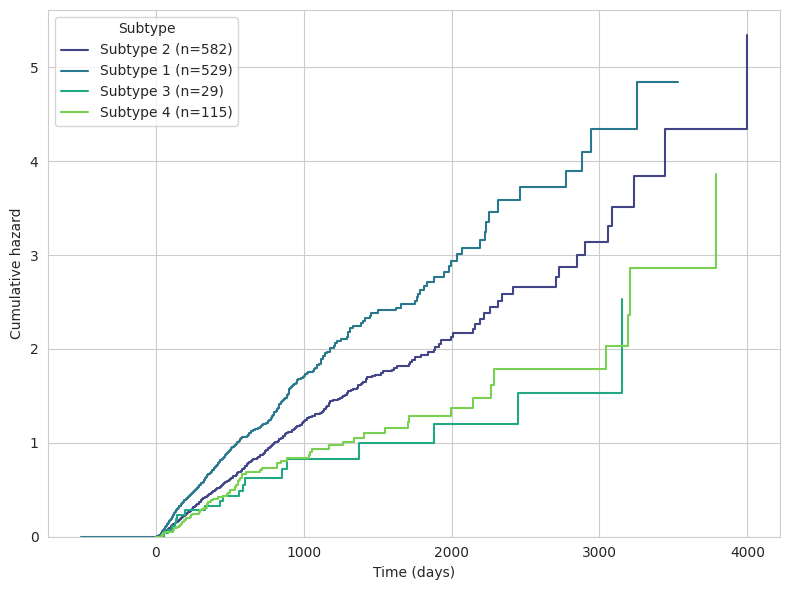

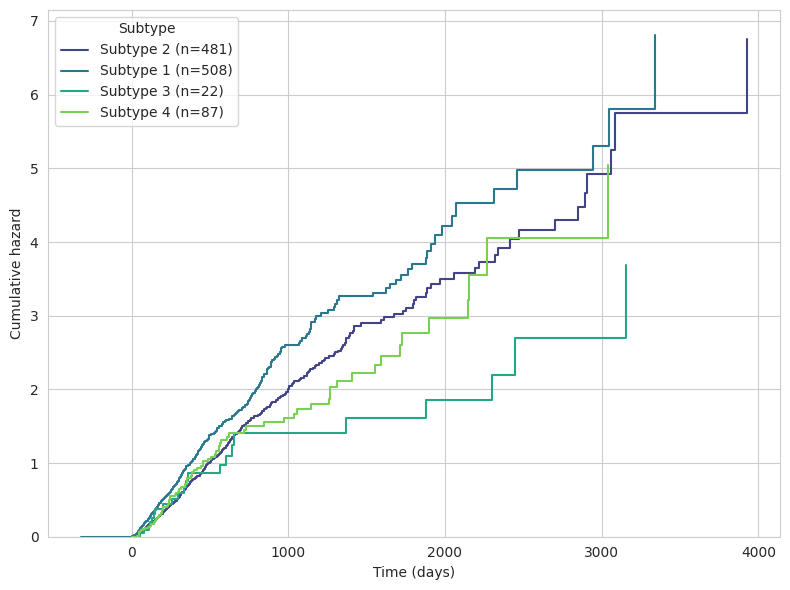

In [ ]:
# ============================================================
# BLOCK C — ADVANCED VISUALIZATION: CUMULATIVE HAZARD + FOREST
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from lifelines import KaplanMeierFitter, NelsonAalenFitter

sns.set_style("whitegrid")

# ---------- 0) BASIC CHECKS ----------
if 'dfB' not in globals():
    raise RuntimeError("dfB not found. Please run Block B first to define dfB, cph_os, cph_pfs.")
if 'Subtype' not in dfB.columns:
    raise RuntimeError("dfB must contain a 'Subtype' column.")
dfB = dfB.copy()
dfB['Subtype'] = dfB['Subtype'].astype('category')
palette = sns.color_palette("viridis", dfB['Subtype'].nunique())

# ---------- 1) CUMULATIVE HAZARD (Nelson–Aalen) ----------
def cumulative_hazard_plot(df, time_col, event_col, title):
    data = df.dropna(subset=[time_col, event_col, "Subtype"]).copy()
    if data.empty:
        print(f"Skipping {title}: no data.")
        return
    data["Subtype"] = data["Subtype"].cat.remove_unused_categories()

    naf = NelsonAalenFitter()
    plt.figure(figsize=(8, 6))
    subs = list(data["Subtype"].cat.categories)
    pal  = sns.color_palette("viridis", len(subs))
    for i, s in enumerate(subs):
        sub = data[data["Subtype"] == s]
        if len(sub) == 0:
            continue
        naf.fit(sub[time_col], event_observed=sub[event_col], label=f"Subtype {s} (n={len(sub)})")
        naf.plot(ci_show=False, color=pal[i])
    #plt.title(f"{title} — Cumulative Hazard by Subtype")
    plt.xlabel("Time (days)")
    plt.ylabel("Cumulative hazard")
    plt.ylim(0)
    plt.legend(title="Subtype")
    plt.tight_layout()
    plt.show()

if {"OS_days","OS_event"} <= set(dfB.columns):
    cumulative_hazard_plot(dfB, "OS_days", "OS_event", "Overall Survival")
if {"PFS_days","PFS_event"} <= set(dfB.columns):
    cumulative_hazard_plot(dfB, "PFS_days", "PFS_event", "Progression-Free Survival")

# ---------- 2) ROBUST COX SUMMARY + FOREST PLOTS ----------
def _cox_summary_df(cph):
    """
    Return a tidy DataFrame with columns:
    ['Variable', 'HR', 'lower', 'upper', 'p']
    Works across different lifelines versions.
    """
    import re
    s = cph.summary.copy()
    s = s.reset_index()

    # pick covariate name column
    if 'covariate' in s.columns:
        cov_col = 'covariate'
    elif 'index' in s.columns:
        cov_col = 'index'
    else:
        cov_col = s.columns[0]

    cols_lower = {c.lower(): c for c in s.columns}

    def find_col(candidates):
        # exact case-insensitive first
        for cand in candidates:
            key = cand.lower()
            if key in cols_lower:
                return cols_lower[key]
        # fallback: fuzzy
        for c in s.columns:
            if any(re.search(fr"\b{cand}\b", c, flags=re.I) for cand in candidates):
                return c
        raise KeyError(f"None of {candidates} found in {list(s.columns)}")

    hr_col  = find_col(["exp(coef)", "hr"])
    lo_col  = find_col(["exp(coef) lower 95%", "lower 95%", "lower ci", "lower"])
    hi_col  = find_col(["exp(coef) upper 95%", "upper 95%", "upper ci", "upper"])
    p_col   = find_col(["p", "p-value", "p value"])

    out = s[[cov_col, hr_col, lo_col, hi_col, p_col]].copy()
    out.columns = ["Variable", "HR", "lower", "upper", "p"]
    out = out[~out["Variable"].str.contains("Intercept", case=False, na=False)]
    return out

def forest_plot(cph, title):
    if cph is None:
        print(f"Skipping {title}: Cox model not available.")
        return
    dfp = _cox_summary_df(cph).sort_values("HR", ascending=False)

    plt.figure(figsize=(8, max(2.5, len(dfp)*0.5 + 1.5)))
    plt.errorbar(
        dfp["HR"], dfp["Variable"],
        xerr=[dfp["HR"] - dfp["lower"], dfp["upper"] - dfp["HR"]],
        fmt='o', color='black', ecolor='gray', capsize=3
    )
    plt.axvline(1.0, color='red', linestyle='--', lw=1)
    plt.xscale("log")
    plt.xlabel("Hazard Ratio (log scale)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Forests for your existing Cox models (from Block B)
if 'cph_os' in globals():
    forest_plot(cph_os, "Cox Model — Overall Survival")
if 'cph_pfs' in globals():
    forest_plot(cph_pfs, "Cox Model — Progression-Free Survival")

# ---------- 3) COMBINED SUMMARY FIGURE (KM + FOREST SIDE BY SIDE) ----------
def combined_summary_plot(df, cph, time_col, event_col, title):
    """
    KM + forest side-by-side using robust Cox summary extraction.
    """
    data = df.dropna(subset=[time_col, event_col, "Subtype"]).copy()
    if data.empty or cph is None:
        print(f"Skipping combined plot for {title}: incomplete data.")
        return

    data["Subtype"] = data["Subtype"].cat.remove_unused_categories()
    subtypes = data["Subtype"].cat.categories
    pal  = sns.color_palette("viridis", len(subtypes))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Left: KM
    kmf = KaplanMeierFitter()
    for i, s in enumerate(subtypes):
        sub = data[data["Subtype"] == s]
        if len(sub) == 0:
            continue
        kmf.fit(sub[time_col], event_observed=sub[event_col], label=f"Subtype {s}")
        kmf.plot_survival_function(ax=axes[0], ci_show=False, color=pal[i])
    axes[0].set_title(f"{title} — Kaplan–Meier")
    axes[0].set_xlabel("Time (days)")
    axes[0].set_ylabel("Survival probability")
    axes[0].legend(title="Subtype")

    # Right: Forest
    dfp = _cox_summary_df(cph).sort_values("HR", ascending=False)
    axes[1].errorbar(
        dfp["HR"], dfp["Variable"],
        xerr=[dfp["HR"] - dfp["lower"], dfp["upper"] - dfp["HR"]],
        fmt='o', color='black', ecolor='gray', capsize=3
    )
    axes[1].axvline(1.0, color='red', linestyle='--', lw=1)
    axes[1].set_xscale("log")
    axes[1].set_xlabel("Hazard Ratio (log scale)")
    axes[1].set_title(f"{title} — Cox Model")

    plt.tight_layout()
    plt.show()

# Combined figures (use your models from Block B)
if {"OS_days","OS_event"} <= set(dfB.columns) and 'cph_os' in globals():
    combined_summary_plot(dfB, cph_os, "OS_days", "OS_event", "Overall Survival")

if {"PFS_days","PFS_event"} <= set(dfB.columns) and 'cph_pfs' in globals():
    combined_summary_plot(dfB, cph_pfs, "PFS_days", "PFS_event", "Progression-Free Survival")


Comparing Model Types

In [ ]:
# ============================================================
# TNM vs Subtype Discrimination — Cox Models A/B/C with C-index
#   Model A: C(Stage_Grouped_Final) + Age + C(Gender)
#   Model B: C(Subtype)             + Age + C(Gender)   (already done before; re-run for side-by-side)
#   Model C: C(Stage) + C(Subtype)  + Age + C(Gender)   (with fallback L1 penalty if needed)
# ============================================================

import pandas as pd
from lifelines import CoxPHFitter
import re

# Choose the working dataframe
if 'df_full' in globals():
    dfD = df_full.copy()
elif 'df_profile' in globals():
    dfD = df_profile.copy()
else:
    raise RuntimeError("No dataframe found. Provide df_full (master+Subtype) or df_profile.")

# Helpers
def qname(col: str) -> str:
    return f"Q('{col}')" if re.search(r'[^A-Za-z0-9_]', col) else col

def _prep(df, time_col, event_col, needed_cols):
    d = df.dropna(subset=[time_col, event_col] + [c for c in needed_cols if c in df.columns]).copy()
    # ensure categorical dtypes
    for cat_col in ["Subtype", "Gender", "Stage_Grouped_Final"]:
        if cat_col in d.columns:
            d[cat_col] = d[cat_col].astype('category').cat.remove_unused_categories()
    # coerce event to 0/1 int
    d[event_col] = (d[event_col].astype(float).fillna(0) > 0).astype(int)
    return d

def _fit_formula(d, time_col, event_col, formula, label, penalized=False):
    cph = CoxPHFitter(penalizer=(0.1 if penalized else 0.0), l1_ratio=(0.9 if penalized else 0.0))
    cph.fit(d, duration_col=time_col, event_col=event_col, formula=formula)
    print(f"{label}: n={len(d):,} | C-index = {cph.concordance_index_:.3f}" + ("  (penalized)" if penalized else ""))
    return cph

def run_models(endpoint_label, time_col, event_col):
    print("\n" + "="*70)
    print(f"{endpoint_label}: Cox discrimination — Models A / B / C")
    print("="*70)

    req_base = ["Age at primary Diagnosis", "Gender"]
    have_stage = "Stage_Grouped_Final" in dfD.columns
    have_subtype = "Subtype" in dfD.columns

    if not all(c in dfD.columns for c in req_base):
        print(f"Missing columns for {endpoint_label}: need {req_base}. Skipping.")
        return

    # Build per-model datasets & formulas
    # Model A needs Stage
    if have_stage:
        dA = _prep(dfD, time_col, event_col, req_base + ["Stage_Grouped_Final"])
        if len(dA) >= 20 and dA["Stage_Grouped_Final"].nunique() >= 2:
            fA = f"{qname('Age at primary Diagnosis')} + C(Gender) + C(Stage_Grouped_Final)"
            try:
                cph_A = _fit_formula(dA, time_col, event_col, fA, "Model A (TNM+Age+Gender)")
            except Exception as e:
                print(f"Model A failed: {e}")
                cph_A = None
        else:
            print("Model A skipped: insufficient data or stage variability.")
            cph_A = None
    else:
        print("Model A skipped: Stage_Grouped_Final not available.")
        cph_A = None

    # Model B needs Subtype
    if have_subtype:
        dB = _prep(dfD, time_col, event_col, req_base + ["Subtype"])
        if len(dB) >= 20 and dB["Subtype"].nunique() >= 2:
            fB = f"{qname('Age at primary Diagnosis')} + C(Gender) + C(Subtype)"
            try:
                cph_B = _fit_formula(dB, time_col, event_col, fB, "Model B (Subtype+Age+Gender)")
            except Exception as e:
                print(f"Model B failed: {e}")
                cph_B = None
        else:
            print("Model B skipped: insufficient data or subtype variability.")
            cph_B = None
    else:
        print("Model B skipped: Subtype not available.")
        cph_B = None

    # Model C needs both
    if have_stage and have_subtype:
        dC = _prep(dfD, time_col, event_col, req_base + ["Subtype", "Stage_Grouped_Final"])
        if len(dC) >= 20 and dC["Subtype"].nunique() >= 2 and dC["Stage_Grouped_Final"].nunique() >= 2:
            fC = f"{qname('Age at primary Diagnosis')} + C(Gender) + C(Stage_Grouped_Final) + C(Subtype)"
            try:
                cph_C = _fit_formula(dC, time_col, event_col, fC, "Model C (TNM+Subtype+Age+Gender)")
            except Exception as e:
                print(f"Model C (unpenalized) failed: {e}")
                # try penalized (helps if collinearity / quasi-separation)
                try:
                    cph_C = _fit_formula(dC, time_col, event_col, fC, "Model C (TNM+Subtype+Age+Gender)", penalized=True)
                except Exception as e2:
                    print(f"Model C (penalized) failed: {e2}")
                    cph_C = None
        else:
            print("Model C skipped: insufficient data or variability.")
            cph_C = None
    else:
        print("Model C skipped: requires both Stage and Subtype.")

    # (Optional) return models if you want to inspect .summary later
    return {"A": locals().get("cph_A"), "B": locals().get("cph_B"), "C": locals().get("cph_C")}

# ---- Run for OS & PFS ----
models_os  = run_models("OVERALL SURVIVAL",          "OS_days",  "OS_event")
models_pfs = run_models("PROGRESSION-FREE SURVIVAL", "PFS_days", "PFS_event")



OVERALL SURVIVAL: Cox discrimination — Models A / B / C
Model A (TNM+Age+Gender): n=1,255 | C-index = 0.644
Model B (Subtype+Age+Gender): n=1,255 | C-index = 0.573
Model C (TNM+Subtype+Age+Gender): n=1,255 | C-index = 0.647

PROGRESSION-FREE SURVIVAL: Cox discrimination — Models A / B / C
Model A (TNM+Age+Gender): n=1,098 | C-index = 0.585
Model B (Subtype+Age+Gender): n=1,098 | C-index = 0.543
Model C (TNM+Subtype+Age+Gender): n=1,098 | C-index = 0.585


Subtype stratification

✅ Data prepared for stratified analysis.
Non-Metastatic (Stages I-III) cohort size: n=788
Metastatic (Stage IV) cohort size: n=691

### Stratified Survival Analysis Plots ###


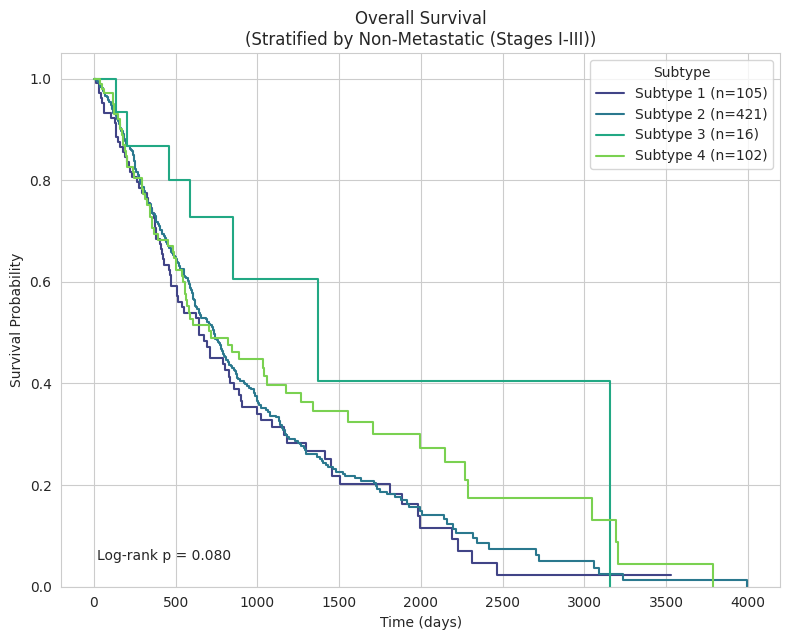

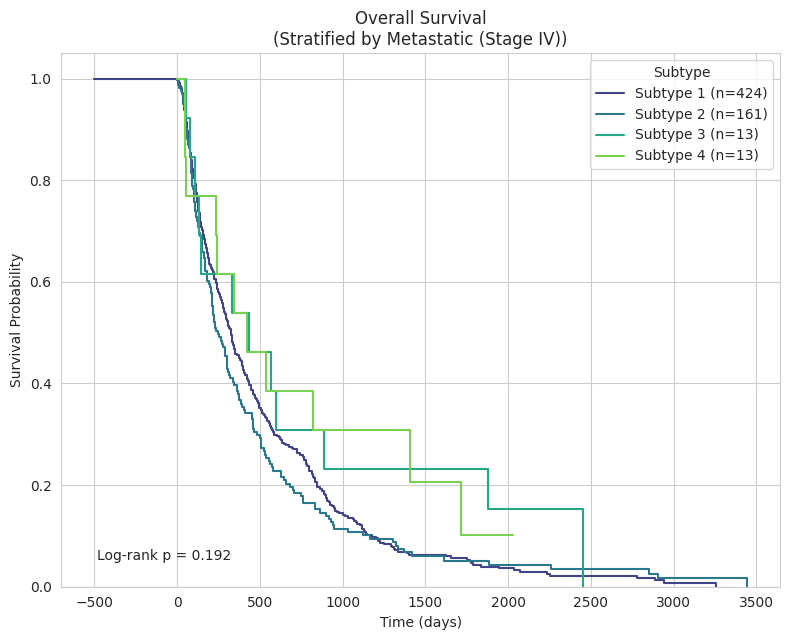


--- Stratified Analysis Complete ---


In [ ]:
# =================================================================
# FINAL SCRIPT: Stratified Survival Analysis (Archetypes within TNM Stage)
# =================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

# --- 1. SETUP: LOAD DATA AND PREPARE ---
# This script assumes 'df_profile' DataFrame from the clustering step is in memory.
if 'df_profile' not in globals():
    raise RuntimeError("❌ ERROR: 'df_profile' not found. Please run the clustering pipeline first.")

df_stratify = df_profile.copy()

# Ensure required columns are present
required_cols = ['Stage_Grouped_Final', 'Subtype', 'OS_days', 'OS_event']
if not all(c in df_stratify.columns for c in required_cols):
    raise RuntimeError(f"❌ ERROR: DataFrame is missing one or more required columns: {required_cols}")

# Set plotting style
sns.set_style("whitegrid")
palette = sns.color_palette("viridis", df_stratify['Subtype'].nunique())

# --- 2. CREATE STAGE GROUPS ---
# Define the non-metastatic and metastatic groups
non_meta_stages = ['Stage I', 'Stage II', 'Stage III']
df_non_meta = df_stratify[df_stratify['Stage_Grouped_Final'].isin(non_meta_stages)]
df_meta = df_stratify[df_stratify['Stage_Grouped_Final'] == 'Stage IV']

print(f"✅ Data prepared for stratified analysis.")
print(f"Non-Metastatic (Stages I-III) cohort size: n={len(df_non_meta)}")
print(f"Metastatic (Stage IV) cohort size: n={len(df_meta)}")


# --- 3. FUNCTION TO CREATE STRATIFIED KM PLOTS ---

def stratified_km_plot(df, time_col, event_col, title_prefix, stratify_group_name):
    """Generates a Kaplan-Meier plot for subtypes within a specific patient group."""

    data = df.dropna(subset=[time_col, event_col, 'Subtype']).copy()
    if data.empty or data['Subtype'].nunique() < 2:
        print(f"\n⚠️ Skipping plot for '{stratify_group_name}': Insufficient data or subtype variation.")
        return

    # Remove any subtype levels that are not present in this subset
    data['Subtype'] = data['Subtype'].astype('category').cat.remove_unused_categories()
    subtypes = list(data['Subtype'].cat.categories)

    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8, 6.5))

    for i, subtype in enumerate(subtypes):
        subset = data[data['Subtype'] == subtype]
        if len(subset) > 0:
            kmf.fit(subset[time_col], event_observed=subset[event_col], label=f"Subtype {subtype} (n={len(subset)})")
            # Re-map the subtype index to the palette index to maintain color consistency
            palette_idx = sorted(df_stratify['Subtype'].unique()).index(subtype)
            kmf.plot_survival_function(ci_show=False, color=palette[palette_idx])

    # Perform log-rank test
    res = multivariate_logrank_test(data[time_col], data['Subtype'], data[event_col])
    p_text = "p < 0.001" if res.p_value < 0.001 else f"p = {res.p_value:.3f}"

    plt.title(f"{title_prefix}\n(Stratified by {stratify_group_name})")
    plt.xlabel("Time (days)")
    plt.ylabel("Survival Probability")
    plt.legend(title="Subtype")
    plt.text(0.05, 0.05, f"Log-rank {p_text}", transform=plt.gca().transAxes)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

# --- 4. GENERATE THE PLOTS ---

print("\n" + "="*70)
print("### Stratified Survival Analysis Plots ###")
print("="*70)

# Plot for Non-Metastatic Group (Stages I-III)
stratified_km_plot(df_non_meta, 'OS_days', 'OS_event', 'Overall Survival', 'Non-Metastatic (Stages I-III)')

# Plot for Metastatic Group (Stage IV)
stratified_km_plot(df_meta, 'OS_days', 'OS_event', 'Overall Survival', 'Metastatic (Stage IV)')

print("\n--- Stratified Analysis Complete ---")

Baseline PCA cohort (complete-case on baseline features): n=1479


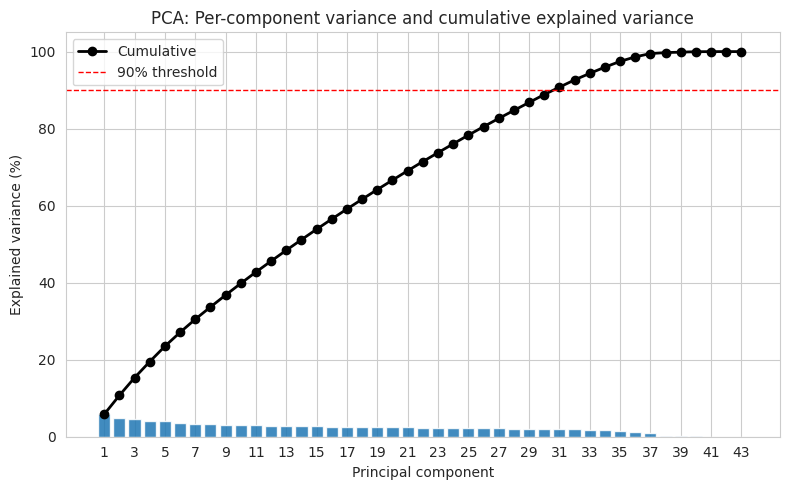

/tmp/ipython-input-2251494865.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centroids = pca_df.groupby('Subtype')[['PC1','PC2']].mean()


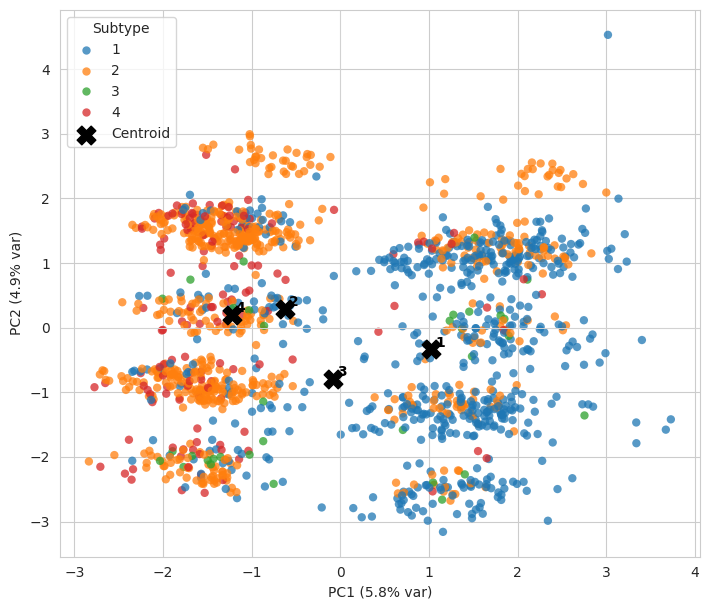

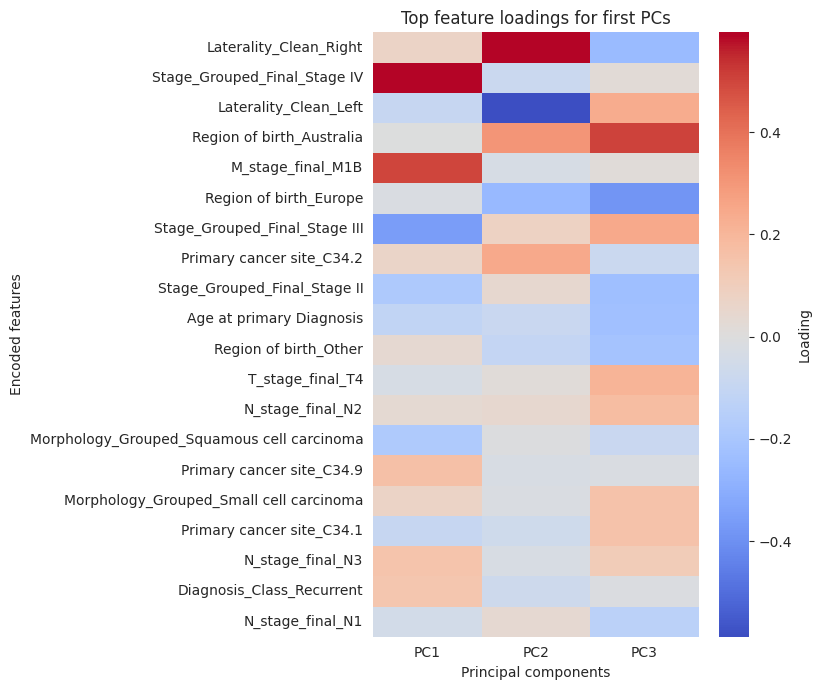

PCA retained 43 components (showing up to 50), explaining 100.0% of variance.
PC1 explains 5.8% and PC2 explains 4.9% of variance.
Include the scree plot (variance bars + cumulative line), the PC1–PC2 scatter with centroids, and the loadings heatmap as Figure/Supplement to document dimensionality reduction and interpretability.


In [ ]:
# ============================================================
# BLOCK D — PCA REPORTING: Scree, PC1–PC2 with Centroids, Loadings Heatmap
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display


sns.set_style("whitegrid")

# -------- 0) Pick the working dataframe (must contain baseline features + Subtype) --------
if 'df_profile' in globals():
    dfP = df_profile.copy()
elif 'df_full' in globals():
    dfP = df_full.copy()
else:
    raise RuntimeError("No dataframe found. Provide df_profile or df_full with Subtype assigned.")

if 'Subtype' not in dfP.columns:
    raise RuntimeError("This block needs a 'Subtype' column (from your clustering step).")

# -------- 1) Define baseline-only features (no treatment/outcome variables) --------
# Add/remove items here if needed; the list is conservative to avoid post-diagnosis info.
candidate_baseline = [
    'Age at primary Diagnosis', 'Gender', 'Country of birth', 'Region of birth',
    'Primary cancer site', 'Diagnosis_Class', 'Morphology_Grouped', 'Laterality_Clean',
    'T_stage_final', 'N_stage_final', 'M_stage_final', 'Stage_Grouped_Final',
    'ECOG_score', 'ECOG_category'
]

# Exclude obviously non-baseline columns just in case they exist:
exclude_cols = {
    'OS_days','OS_event','PFS_days','PFS_event',
    'Progression_Level','Progression_Sites','Recurrence_Site_Grouped',
    'SABR_FLAG','Chemo_FLAG','Surgery_FLAG','RT_FLAG','Immunotherapy_FLAG'
}

features = [c for c in candidate_baseline if c in dfP.columns and c not in exclude_cols]
if not features:
    raise RuntimeError("No baseline features found in the dataframe. Update 'candidate_baseline' if your names differ.")

# Complete-case on **baseline features only** (so PCA matches your clustering policy)
df_base = dfP.dropna(subset=features).copy()
# Keep the Subtype of the retained rows
df_base['Subtype'] = df_base['Subtype'].astype('category')
df_base['Subtype'] = df_base['Subtype'].cat.remove_unused_categories()
print(f"Baseline PCA cohort (complete-case on baseline features): n={len(df_base)}")

# One-hot encode categoricals; scale everything
df_enc = pd.get_dummies(df_base[features], drop_first=True)
scaler = StandardScaler()
X = scaler.fit_transform(df_enc)

# Fit PCA — keep up to 50 components or all if fewer
pca = PCA(n_components=min(50, X.shape[1]))
X_pca = pca.fit_transform(X)

# Explained variance
evr = pca.explained_variance_ratio_
cum = np.cumsum(evr)

# -------- 2) Scree/bar plot with cumulative line --------
plt.figure(figsize=(8, 5))
idx = np.arange(1, len(evr) + 1)
bars = plt.bar(idx, evr * 100, alpha=0.85)
plt.plot(idx, cum * 100, marker='o', lw=2, color='black', label='Cumulative')
plt.axhline(0, color='grey', lw=0.5)
plt.axhline(90, color='red', ls='--', lw=1, label='90% threshold')
plt.xlabel('Principal component')
plt.ylabel('Explained variance (%)')
plt.title('PCA: Per-component variance and cumulative explained variance')
plt.xticks(idx[::max(1, len(idx)//15)])
plt.legend()
plt.tight_layout()
plt.show()

# -------- 3) PC1–PC2 scatter by Subtype + centroids --------
pc1_var = evr[0] * 100 if len(evr) > 0 else 0.0
pc2_var = evr[1] * 100 if len(evr) > 1 else 0.0

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Subtype': df_base['Subtype'].values
})
pca_df['Subtype'] = pca_df['Subtype'].astype('category')
palette = sns.color_palette("tab10", pca_df['Subtype'].nunique())

plt.figure(figsize=(7.2, 6.2))
ax = sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='Subtype',
    palette=palette, alpha=0.75, edgecolor='none'
)

# Centroids per subtype
centroids = pca_df.groupby('Subtype')[['PC1','PC2']].mean()
plt.scatter(centroids['PC1'], centroids['PC2'], s=180, c='black', marker='X', label='Centroid', zorder=5)

# Label centroids (offset a bit to reduce overlap)
for subtype, row in centroids.iterrows():
    plt.text(row['PC1'] + 0.03 * pca_df['PC1'].std(),
             row['PC2'] + 0.03 * pca_df['PC2'].std(),
             f"{subtype}", fontsize=10, weight='bold', color='black')

#plt.title('PCA projection (PC1 vs PC2) by Subtype')
plt.xlabel(f"PC1 ({pc1_var:.1f}% var)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% var)")
plt.legend(title='Subtype', loc='best', frameon=True)
plt.axhline(0, color='lightgrey', lw=0.7)
plt.axvline(0, color='lightgrey', lw=0.7)
plt.tight_layout()
plt.show()

# -------- 4) Loading heatmap (which features drive PCs?) --------
# Build loadings matrix (features × PCs), then pick top |loading| features across PC1–PC3
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_enc.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pcs_to_show = [c for c in loadings.columns[:3]]  # PC1..PC3
# rank features by max absolute loading across the shown PCs
rank = loadings[pcs_to_show].abs().max(axis=1).sort_values(ascending=False)
top_feats = rank.head(min(20, len(rank))).index  # top 20 (or fewer if not available)
heat = loadings.loc[top_feats, pcs_to_show]

plt.figure(figsize=(8, max(4, 0.35 * len(top_feats))))
sns.heatmap(heat, cmap='coolwarm', center=0, annot=False, cbar_kws={'label': 'Loading'})
plt.title('Top feature loadings for first PCs')
plt.xlabel('Principal components')
plt.ylabel('Encoded features')
plt.tight_layout()
plt.show()

# -------- 5) Tiny text summary for manuscript --------
print(f"PCA retained {pca.n_components_} components (showing up to 50), "
      f"explaining {cum[min(len(cum)-1, pca.n_components_-1)]*100:.1f}% of variance.")
print(f"PC1 explains {pc1_var:.1f}% and PC2 explains {pc2_var:.1f}% of variance.")
print("Include the scree plot (variance bars + cumulative line), the PC1–PC2 scatter with centroids, "
      "and the loadings heatmap as Figure/Supplement to document dimensionality reduction and interpretability.")


In [ ]:
# ============================================================
# FINAL: Missingness Analysis (Included vs. Excluded) — MATCHES CLUSTERING
# Produces Table S1B + CSV export
# ============================================================

import os
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency

print("--- Starting Missingness Analysis ---")

# ---------- 1) LOAD FULL DATA ----------
CSV_PATH = "/content/Patient_Master_Table.csv"  # <-- change if needed
if not os.path.exists(CSV_PATH):
    raise SystemExit(f"❌ Could not find data at {CSV_PATH}")
df_master = pd.read_csv(CSV_PATH)
print(f"✅ Loaded: {CSV_PATH} (n={len(df_master)})")

ID_COL = "LINKAGE CODE"
if ID_COL not in df_master.columns:
    raise SystemExit(f"❌ ID column '{ID_COL}' not found in data.")

# ---------- 2) DEFINE BASELINE FEATURES ***EXACTLY AS USED IN CLUSTERING*** ----------
BASELINE_WHITELIST = [
    'Age at primary Diagnosis',
    'Gender',
    'Region of birth',
    'Primary cancer site',      # alias handled below
    'Diagnosis_Class',
    'Morphology_Grouped',
    'Laterality_Clean',
    'T_stage_final',
    'N_stage_final',
    'M_stage_final',
    'Stage_Grouped_Final',
    'ECOG_score'
]

# Alias: handle datasets that use 'Cancer site' instead of 'Primary cancer site'
if ('Primary cancer site' not in df_master.columns) and ('Cancer site' in df_master.columns):
    df_master = df_master.rename(columns={'Cancer site': 'Primary cancer site'})

# Keep only columns that actually exist (after aliasing)
baseline_features = [c for c in BASELINE_WHITELIST if c in df_master.columns]
missing_core = [c for c in BASELINE_WHITELIST if c not in df_master.columns]
if missing_core:
    print("⚠️  Missing expected clustering features in master:", missing_core)
if len(baseline_features) < 10:
    raise SystemExit("❌ Too few baseline clustering features present; check headers and preprocessing.")

# ---------- 3) INCLUDED (complete-case on baseline) vs EXCLUDED ----------
included_df = df_master.dropna(subset=baseline_features).copy()
included_ids = set(included_df[ID_COL])
excluded_df = df_master[~df_master[ID_COL].isin(included_ids)].copy()

print(f"Total patients: {len(df_master)}")
print(f"Included in clustering-style complete-case: {len(included_df)}")
print(f"Excluded: {len(excluded_df)}\n")

# Optional sanity check; adjust if your run differs slightly
EXPECTED_INCLUDED = 1479
if len(included_df) != EXPECTED_INCLUDED:
    print(f"⚠️ Note: included n={len(included_df)} differs from expected {EXPECTED_INCLUDED}. "
          f"Confirm this matches the exact file used for clustering.")

# ---------- 4) HELPERS ----------
def std_mean_diff(x, g):
    """Standardized mean difference (Hedges-like, pooled SD) for continuous var x by binary group g (Included vs Excluded)."""
    x1 = x[g == 'Included'].dropna().astype(float)
    x0 = x[g == 'Excluded'].dropna().astype(float)
    if len(x1) < 2 or len(x0) < 2:
        return np.nan
    m1, m0 = x1.mean(), x0.mean()
    s1, s0 = x1.std(ddof=1), x0.std(ddof=1)
    # pooled SD
    sp = np.sqrt(((len(x1)-1)*s1**2 + (len(x0)-1)*s0**2) / (len(x1)+len(x0)-2)) if (len(x1)+len(x0)-2) > 0 else np.nan
    return (m1 - m0)/sp if sp and sp > 0 else np.nan

def cramers_v(crosstab):
    """Cramér’s V with bias correction (for χ²)."""
    chi2, _, _, _ = chi2_contingency(crosstab)
    n = crosstab.to_numpy().sum()
    if n == 0:
        return np.nan
    r, k = crosstab.shape
    phi2 = chi2 / n
    # bias correction (Bergsma 2013)
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else np.sqrt(phi2 / (min(k-1, r-1) or 1))

def format_median_iqr(series):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if s.empty:
        return "NA"
    return f"{s.median():.1f} ({s.quantile(0.25):.1f}–{s.quantile(0.75):.1f})"

# Group label for convenience
group_label = np.where(df_master[ID_COL].isin(included_ids), 'Included', 'Excluded')

# ---------- 5) BUILD TABLE ----------
VARS_TO_COMPARE = {
    'Age at primary Diagnosis': 'continuous',
    'Gender': 'categorical',
    'Stage_Grouped_Final': 'categorical',
    'Morphology_Grouped': 'categorical'
}

rows = []
header = ["Characteristic",
          f"Included Cohort (n={len(included_df)})",
          f"Excluded Cohort (n={len(excluded_df)})",
          "P-value",
          "Effect size"]

for var, kind in VARS_TO_COMPARE.items():
    if var not in df_master.columns:
        continue

    if kind == 'continuous':
        inc = included_df[var]
        exc = excluded_df[var]
        inc_fmt = format_median_iqr(inc)
        exc_fmt = format_median_iqr(exc)
        # Mann–Whitney U
        x1 = pd.to_numeric(inc, errors='coerce').dropna()
        x0 = pd.to_numeric(exc, errors='coerce').dropna()
        if len(x1) > 0 and len(x0) > 0:
            _, p_val = mannwhitneyu(x1, x0, alternative='two-sided')
        else:
            p_val = np.nan
        # SMD
        smd = std_mean_diff(pd.to_numeric(df_master[var], errors='coerce'), pd.Series(group_label))
        rows.append([f"{var} (median [IQR])", inc_fmt, exc_fmt, f"{p_val:.3g}" if pd.notna(p_val) else "NA",
                     f"SMD={smd:.2f}" if pd.notna(smd) else "SMD=NA"])

    else:
        # Overall χ² with Cramér's V
        ct_overall = pd.crosstab(group_label, df_master[var].fillna('Missing'))
        chi2, p_val, _, _ = chi2_contingency(ct_overall)
        cv = cramers_v(ct_overall)
        rows.append([f"{var}, n (%)", "", "", f"{p_val:.3g}", f"Cramér’s V={cv:.2f}" if pd.notna(cv) else "Cramér’s V=NA"])

        # Level rows (counts and row-% within each cohort)
        # we’ll compute n(%) within Included and within Excluded
        inc_tab = included_df[var].fillna('Missing').value_counts()
        exc_tab = excluded_df[var].fillna('Missing').value_counts()
        inc_den = len(included_df)
        exc_den = len(excluded_df)

        # display levels in a stable order: Included+Excluded union
        levels = pd.Index(sorted(set(ct_overall.columns.astype(str))))
        for lvl in levels:
            inc_n = int(inc_tab.get(lvl, 0))
            exc_n = int(exc_tab.get(lvl, 0))
            inc_pct = 100.0 * inc_n / inc_den if inc_den else 0.0
            exc_pct = 100.0 * exc_n / exc_den if exc_den else 0.0
            rows.append([f"  {lvl}",
                         f"{inc_n} ({inc_pct:.1f}%)",
                         f"{exc_n} ({exc_pct:.1f}%)",
                         "", ""])

df_comparison_table = pd.DataFrame(rows, columns=header)

# ---------- 6) PRINT & EXPORT ----------
title_line = "="*100
print(title_line)
print("### Table S1B: Included vs. Excluded (Baseline Complete-Case Definition) ###")
print(title_line)

# Try to display nicely in notebooks; otherwise print text
try:
    from IPython.display import display
    display(df_comparison_table)
except Exception:
    print(df_comparison_table.to_string(index=False))

# Export CSV for Supplement
out_csv = "Table_S1B_Included_vs_Excluded.csv"
df_comparison_table.to_csv(out_csv, index=False)
print(f"\n✅ Exported: {out_csv}")

# ---------- 7) Brief narrative (for Supplement caption drafting) ----------
n_inc = len(included_df); n_exc = len(excluded_df)
age_smd = [r for r in rows if r[0].startswith("Age at primary Diagnosis")][0][-1]
print("\nNarrative notes:")
print(f"- Complete-case cohort used for clustering: n={n_inc}; excluded due to missing baseline features: n={n_exc}.")
print(f"- Age difference (SMD) {age_smd}; χ² tests for categorical variables reported with Cramér’s V.")
print("- This table corresponds exactly to the complete-case definition used for unsupervised clustering.")


--- Starting Missingness Analysis ---
✅ Loaded: /content/Patient_Master_Table.csv (n=2514)
Total patients: 2514
Included in clustering-style complete-case: 1479
Excluded: 1035

### Table S1B: Included vs. Excluded (Baseline Complete-Case Definition) ###


,Characteristic,Included Cohort (n=1479),Excluded Cohort (n=1035),P-value,Effect size
0,Age at primary Diagnosis (median [IQR]),71.0 (63.0–77.0),74.0 (66.0–80.0),3.57e-12,SMD=-0.26
1,"Gender, n (%)",,,0.844,Cramér’s V=0.00
2,Female,663 (44.8%),459 (44.3%),,
3,Male,816 (55.2%),576 (55.7%),,
4,"Stage_Grouped_Final, n (%)",,,7.41e-74,Cramér’s V=0.37
5,Missing,0 (0.0%),186 (18.0%),,
6,Stage I,295 (19.9%),181 (17.5%),,
7,Stage II,125 (8.5%),55 (5.3%),,
8,Stage III,368 (24.9%),105 (10.1%),,
9,Stage IV,691 (46.7%),508 (49.1%),,



✅ Exported: Table_S1B_Included_vs_Excluded.csv

Narrative notes:
- Complete-case cohort used for clustering: n=1479; excluded due to missing baseline features: n=1035.
- Age difference (SMD) SMD=-0.26; χ² tests for categorical variables reported with Cramér’s V.
- This table corresponds exactly to the complete-case definition used for unsupervised clustering.


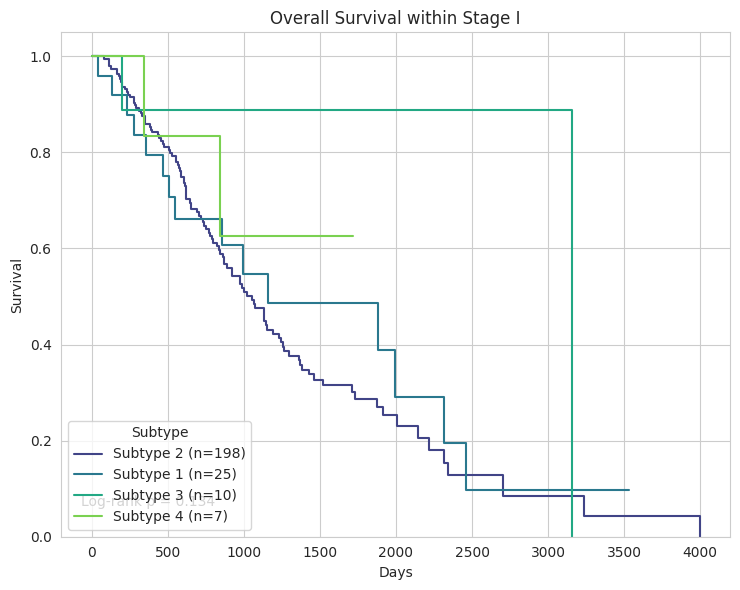

--- Cox within Stage I ---


<lifelines.CoxPHFitter: fitted with 240 total observations, 111 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
      baseline estimation = breslow
   number of observations = 240
number of events observed = 129
   partial log-likelihood = -561.546
         time fit was run = 2025-11-08 01:33:38 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
C(Subtype)[T.1]               -0.329     0.719     0.281          -0.881           0.222               0.414               1.249
C(Subtype)[T.3]               -1.510     0.221     0.735          -2.950          -0.070               0.052               0.933
C(Subtype)[T.4]               -0.234     0.792     0.722          -1.648           1.181               0.192               3.258
Q('Age at primary Diagnosis')  0.030     1.030     0.010           0.009           0.050               1.009               1.052
C(Gender)[T.Male]              0.930     2.534     0.192           0.554           1.306               1.740               3.690

                               cmp to      z       p  -log2(p)
covariate                                                     
C(Subtype)[T.1]                 0.000 -1.171   0.242     2.048
C(Subtype)[T.3]                 0.000 -2.055   0.040     4.648
C(Subtype)[T.4]                 0.000 -0.324   0.746     0.422
Q('Age at primary Diagnosis')   0.000  2.844   0.004     7.811
C(Gender)[T.Male]               0.000  4.850 <0.0005    19.624
---
Concordance = 0.641
Partial AIC = 1133.092
log-likelihood ratio test = 39.377 on 5 df
-log2(p) of ll-ratio test = 22.258

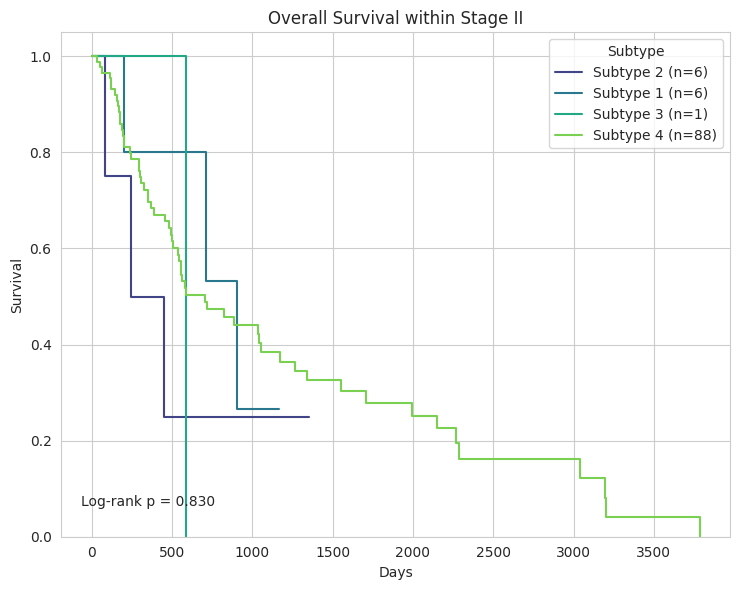

--- Cox within Stage II ---


<lifelines.CoxPHFitter: fitted with 101 total observations, 35 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
      baseline estimation = breslow
   number of observations = 101
number of events observed = 66
   partial log-likelihood = -232.171
         time fit was run = 2025-11-08 01:33:39 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
C(Subtype)[T.1]               -0.278     0.757     0.824          -1.893           1.336               0.151               3.804
C(Subtype)[T.3]                1.183     3.263     1.227          -1.223           3.588               0.294              36.152
C(Subtype)[T.4]               -0.448     0.639     0.598          -1.620           0.724               0.198               2.062
Q('Age at primary Diagnosis')  0.056     1.057     0.015           0.027           0.084               1.028               1.088
C(Gender)[T.Male]              0.083     1.087     0.263          -0.433           0.600               0.649               1.821

                               cmp to      z       p  -log2(p)
covariate                                                     
C(Subtype)[T.1]                 0.000 -0.338   0.735     0.443
C(Subtype)[T.3]                 0.000  0.964   0.335     1.577
C(Subtype)[T.4]                 0.000 -0.750   0.453     1.141
Q('Age at primary Diagnosis')   0.000  3.836 <0.0005    12.967
C(Gender)[T.Male]               0.000  0.317   0.751     0.412
---
Concordance = 0.654
Partial AIC = 474.342
log-likelihood ratio test = 17.393 on 5 df
-log2(p) of ll-ratio test = 8.036

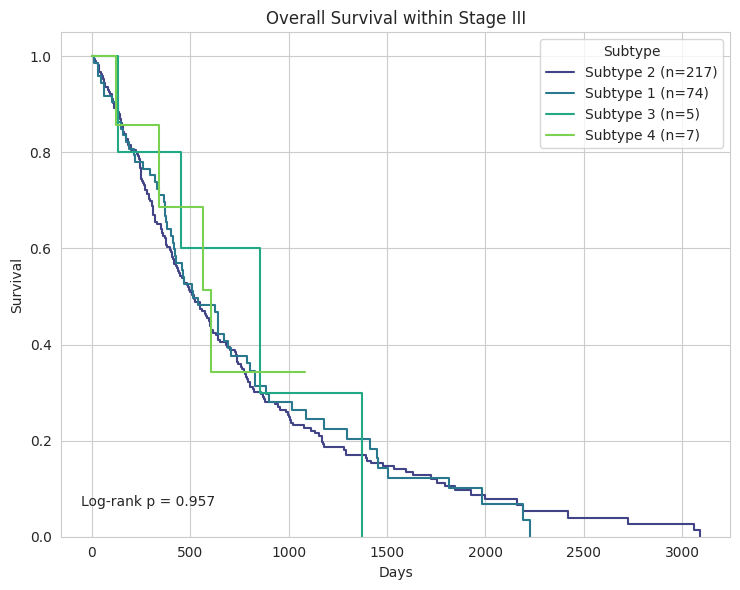

--- Cox within Stage III ---


<lifelines.CoxPHFitter: fitted with 303 total observations, 45 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
      baseline estimation = breslow
   number of observations = 303
number of events observed = 258
   partial log-likelihood = -1237.397
         time fit was run = 2025-11-08 01:33:39 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
C(Subtype)[T.1]               -0.044     0.957     0.148          -0.335           0.247               0.715               1.280
C(Subtype)[T.3]               -0.246     0.782     0.508          -1.242           0.750               0.289               2.117
C(Subtype)[T.4]               -0.243     0.785     0.507          -1.236           0.751               0.291               2.118
Q('Age at primary Diagnosis')  0.009     1.009     0.007          -0.005           0.022               0.995               1.023
C(Gender)[T.Male]              0.097     1.102     0.130          -0.158           0.352               0.854               1.422

                               cmp to      z     p  -log2(p)
covariate                                                   
C(Subtype)[T.1]                 0.000 -0.298 0.765     0.386
C(Subtype)[T.3]                 0.000 -0.484 0.628     0.670
C(Subtype)[T.4]                 0.000 -0.479 0.632     0.662
Q('Age at primary Diagnosis')   0.000  1.256 0.209     2.257
C(Gender)[T.Male]               0.000  0.746 0.456     1.133
---
Concordance = 0.543
Partial AIC = 2484.794
log-likelihood ratio test = 2.470 on 5 df
-log2(p) of ll-ratio test = 0.357

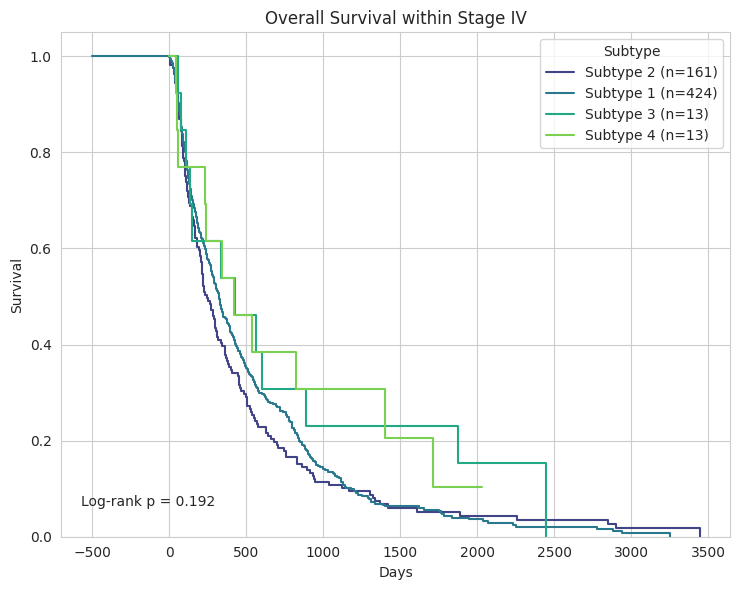

--- Cox within Stage IV ---


<lifelines.CoxPHFitter: fitted with 611 total observations, 40 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
      baseline estimation = breslow
   number of observations = 611
number of events observed = 571
   partial log-likelihood = -3123.380
         time fit was run = 2025-11-08 01:33:39 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
C(Subtype)[T.1]               -0.120     0.886     0.096          -0.308           0.067               0.735               1.069
C(Subtype)[T.3]               -0.399     0.671     0.301          -0.989           0.191               0.372               1.211
C(Subtype)[T.4]               -0.579     0.560     0.314          -1.195           0.037               0.303               1.037
Q('Age at primary Diagnosis')  0.006     1.006     0.004          -0.003           0.014               0.997               1.014
C(Gender)[T.Male]              0.127     1.136     0.087          -0.043           0.297               0.958               1.346

                               cmp to      z     p  -log2(p)
covariate                                                   
C(Subtype)[T.1]                 0.000 -1.260 0.208     2.268
C(Subtype)[T.3]                 0.000 -1.325 0.185     2.432
C(Subtype)[T.4]                 0.000 -1.843 0.065     3.937
Q('Age at primary Diagnosis')   0.000  1.329 0.184     2.443
C(Gender)[T.Male]               0.000  1.469 0.142     2.817
---
Concordance = 0.534
Partial AIC = 6256.760
log-likelihood ratio test = 9.832 on 5 df
-log2(p) of ll-ratio test = 3.642

In [ ]:
# --- Stage-stratified KM + Cox (OS) ---
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import seaborn as sns, matplotlib.pyplot as plt
import pandas as pd

assert 'dfB' in globals(), "Run Block B first to define dfB."

def stage_group(df):
    if 'Stage_Grouped_Final' not in df.columns:
        raise RuntimeError("Need Stage_Grouped_Final.")
    return df['Stage_Grouped_Final'].replace({'Stage I':'I','Stage II':'II','Stage III':'III','Stage IV':'IV'})

def km_by_subtype_within_stage(df, stage_label, time_col='OS_days', event_col='OS_event'):
    d = df[(stage_group(df)==stage_label)].dropna(subset=[time_col,event_col,'Subtype']).copy()
    if d.empty or d['Subtype'].nunique()<2:
        print(f"Skipping {stage_label}: insufficient data."); return
    d['Subtype']=d['Subtype'].cat.remove_unused_categories()
    sns.set_style("whitegrid")
    plt.figure(figsize=(7.5,6))
    pal = sns.color_palette("viridis", d['Subtype'].nunique())
    km = KaplanMeierFitter()
    for i,s in enumerate(d['Subtype'].cat.categories):
        ds = d[d['Subtype']==s]
        km.fit(ds[time_col], event_observed=ds[event_col], label=f"Subtype {s} (n={len(ds)})")
        km.plot(ci_show=False, color=pal[i])
    res = multivariate_logrank_test(d[time_col], d['Subtype'], d[event_col])
    ptxt = "p < 0.001" if res.p_value<1e-3 else f"p = {res.p_value:.3f}"
    plt.title(f"Overall Survival within Stage {stage_label}")
    plt.xlabel("Days"); plt.ylabel("Survival"); plt.text(0.03,0.06,f"Log-rank {ptxt}", transform=plt.gca().transAxes)
    plt.ylim(0,1.05); plt.legend(title="Subtype"); plt.tight_layout(); plt.show()

    # Cox within stage (age/sex adjusted)
    covars = ['Subtype']
    if "Age at primary Diagnosis" in d.columns: covars.append("Age at primary Diagnosis")
    if "Gender" in d.columns: covars.append("Gender")
    use = d.dropna(subset=covars+[time_col,event_col]).copy()
    if len(use)>=30 and use['Subtype'].nunique()>=2:
        cph = CoxPHFitter()
        cph.fit(use, duration_col=time_col, event_col=event_col, formula="C(Subtype)+Q('Age at primary Diagnosis')+C(Gender)")
        print(f"--- Cox within Stage {stage_label} ---"); cph.print_summary(decimals=3)

for st in ['I','II','III','IV']:
    km_by_subtype_within_stage(dfB, st)


In [ ]:
# === Robust Subtype × Treatment interaction (OS) ===
from lifelines import CoxPHFitter

def cox_interaction_robust(df, treat, time_col='OS_days', event_col='OS_event'):
    d = df.dropna(subset=[time_col, event_col, 'Subtype', treat]).copy()
    d[event_col] = (d[event_col].astype(float) > 0).astype(int)
    d['Subtype'] = d['Subtype'].astype('category').cat.remove_unused_categories()
    # skip if any subtype has <5 on either arm (0 or 1)
    tab = pd.crosstab(d['Subtype'], d[treat])
    if (tab.min(axis=1) < 5).any():
        print(f"{treat}: skipped (sparse exposure in ≥1 subtype)."); return None

    # drop zero-variance columns (rare but safe)
    nz = d.nunique()
    drop_cols = [c for c in d.columns if nz.get(c, 2) <= 1]
    d = d.drop(columns=drop_cols)

    covars = []
    if "Age at primary Diagnosis" in d.columns: covars.append("Q('Age at primary Diagnosis')")
    if "Gender" in d.columns:                    covars.append("C(Gender)")
    # main effects + interaction
    formula = " + ".join(covars + [f"C(Subtype)", f"{treat}", f"C(Subtype):{treat}"])

    try:
        cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.0)  # ridge helps convergence
        cph.fit(d, duration_col=time_col, event_col=event_col, formula=formula)
        print(f"\n--- OS Cox with Subtype × {treat} (ridge penalized) ---")
        cph.print_summary(decimals=3)
        return cph
    except Exception as e:
        print(f"{treat}: model failed → {e}")
        return None

for T in [c for c in ['SABR_FLAG','Chemo_FLAG','Surgery_FLAG'] if c in dfB.columns]:
    cox_interaction_robust(dfB, T)



--- OS Cox with Subtype × SABR_FLAG (ridge penalized) ---


<lifelines.CoxPHFitter: fitted with 1255 total observations, 231 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1255
number of events observed = 1024
   partial log-likelihood = -6332.298
         time fit was run = 2025-11-08 01:33:40 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
Q('Age at primary Diagnosis')  0.004     1.004     0.003          -0.002           0.010               0.998               1.010
C(Gender)[T.Male]              0.225     1.252     0.061           0.106           0.344               1.112               1.411
C(Subtype)[T.1]                0.214     1.238     0.070           0.076           0.351               1.079               1.421
C(Subtype)[T.3]               -0.240     0.786     0.240          -0.711           0.231               0.491               1.259
C(Subtype)[T.4]               -0.283     0.753     0.119          -0.516          -0.050               0.597               0.951
SABR_FLAG                      0.229     1.258     0.087           0.060           0.399               1.062               1.490
C(Subtype)[T.1]:SABR_FLAG      0.283     1.327     0.116           0.056           0.510               1.058               1.665
C(Subtype)[T.3]:SABR_FLAG     -0.429     0.651     0.453          -1.318           0.459               0.268               1.583
C(Subtype)[T.4]:SABR_FLAG     -0.055     0.947     0.344          -0.730           0.620               0.482               1.860

                               cmp to      z       p  -log2(p)
covariate                                                     
Q('Age at primary Diagnosis')   0.000  1.350   0.177     2.498
C(Gender)[T.Male]               0.000  3.709 <0.0005    12.228
C(Subtype)[T.1]                 0.000  3.042   0.002     8.733
C(Subtype)[T.3]                 0.000 -1.000   0.317     1.657
C(Subtype)[T.4]                 0.000 -2.381   0.017     5.855
SABR_FLAG                       0.000  2.650   0.008     6.959
C(Subtype)[T.1]:SABR_FLAG       0.000  2.447   0.014     6.118
C(Subtype)[T.3]:SABR_FLAG       0.000 -0.947   0.343     1.542
C(Subtype)[T.4]:SABR_FLAG       0.000 -0.159   0.874     0.194
---
Concordance = 0.590
Partial AIC = 12682.597
log-likelihood ratio test = 98.001 on 9 df
-log2(p) of ll-ratio test = 54.476


--- OS Cox with Subtype × Chemo_FLAG (ridge penalized) ---


<lifelines.CoxPHFitter: fitted with 1255 total observations, 231 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1255
number of events observed = 1024
   partial log-likelihood = -6342.488
         time fit was run = 2025-11-08 01:33:40 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
Q('Age at primary Diagnosis')  0.006     1.006     0.003          -0.000           0.012               1.000               1.012
C(Gender)[T.Male]              0.205     1.227     0.061           0.085           0.324               1.089               1.383
C(Subtype)[T.1]                0.360     1.433     0.086           0.192           0.528               1.212               1.695
C(Subtype)[T.3]               -0.420     0.657     0.307          -1.021           0.182               0.360               1.199
C(Subtype)[T.4]               -0.011     0.989     0.145          -0.296           0.274               0.744               1.315
Chemo_FLAG                     0.200     1.221     0.077           0.048           0.351               1.049               1.421
C(Subtype)[T.1]:Chemo_FLAG    -0.149     0.861     0.102          -0.350           0.052               0.705               1.053
C(Subtype)[T.3]:Chemo_FLAG     0.081     1.085     0.372          -0.647           0.810               0.523               2.247
C(Subtype)[T.4]:Chemo_FLAG    -0.643     0.526     0.198          -1.032          -0.255               0.356               0.775

                               cmp to      z       p  -log2(p)
covariate                                                     
Q('Age at primary Diagnosis')   0.000  1.824   0.068     3.874
C(Gender)[T.Male]               0.000  3.361   0.001    10.333
C(Subtype)[T.1]                 0.000  4.203 <0.0005    15.209
C(Subtype)[T.3]                 0.000 -1.368   0.171     2.546
C(Subtype)[T.4]                 0.000 -0.077   0.939     0.091
Chemo_FLAG                      0.000  2.585   0.010     6.680
C(Subtype)[T.1]:Chemo_FLAG      0.000 -1.456   0.145     2.782
C(Subtype)[T.3]:Chemo_FLAG      0.000  0.218   0.827     0.274
C(Subtype)[T.4]:Chemo_FLAG      0.000 -3.243   0.001     9.726
---
Concordance = 0.578
Partial AIC = 12702.976
log-likelihood ratio test = 77.622 on 9 df
-log2(p) of ll-ratio test = 40.925

Surgery_FLAG: skipped (sparse exposure in ≥1 subtype).


In [ ]:
from lifelines import CoxPHFitter
import pandas as pd, numpy as np

def cox_interaction_ridge(df, treat, time_col='OS_days', event_col='OS_event',
                          min_cell=10, penalizer=0.1):
    d = df[[time_col, event_col, 'Subtype', 'Gender', 'Age at primary Diagnosis', treat]].dropna()
    if d.empty or d['Subtype'].nunique()<2:
        print(f"{treat}: insufficient data.");
        return None

    # Drop rare Subtype×Treatment cells to avoid separation
    ct = pd.crosstab(d['Subtype'], d[treat])
    rare_mask = (ct < min_cell)
    if rare_mask.any().any():
        # identify rows to drop (rare combo rows)
        rare_rows = []
        for s in ct.index:
            for val in ct.columns:
                if ct.loc[s, val] < min_cell:
                    rare_rows.extend(d[(d['Subtype']==s) & (d[treat]==val)].index.tolist())
        d = d.drop(index=set(rare_rows))
        print(f"{treat}: dropped {len(set(rare_rows))} rows with rare Subtype×{treat} cells (<{min_cell}).")

    if len(d) < 50 or d['Subtype'].nunique()<2:
        print(f"{treat}: insufficient data after filtering.");
        return None

    # Standardize age slightly (helps numerics)
    d = d.copy()
    d['Age_std'] = (d['Age at primary Diagnosis'] - d['Age at primary Diagnosis'].mean())/d['Age at primary Diagnosis'].std(ddof=0)

    formula = f"C(Subtype) + C(Gender) + Age_std + {treat} + C(Subtype):{treat}"
    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=0.0)  # ridge
    try:
        cph.fit(d, duration_col=time_col, event_col=event_col, formula=formula)
        print(f"\n--- OS Cox with Subtype×{treat} (ridge) ---  n={len(d)}")
        cph.print_summary(decimals=3)
        return cph
    except Exception as e:
        print(f"{treat}: penalized fit failed — {e}")
        return None

for t in [c for c in ['SABR_FLAG','Chemo_FLAG','Surgery_FLAG'] if c in dfB.columns]:
    cox_interaction_ridge(dfB, t)


SABR_FLAG: dropped 9 rows with rare Subtype×SABR_FLAG cells (<10).
SABR_FLAG: penalized fit failed — Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['C(Subtype)[T.3]:SABR_FLAG'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)



--- OS Cox with Subtype×Chemo_FLAG (ridge) ---  n=1255


<lifelines.CoxPHFitter: fitted with 1255 total observations, 231 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1255
number of events observed = 1024
   partial log-likelihood = -6342.488
         time fit was run = 2025-11-08 01:33:40 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
C(Subtype)[T.1]             0.360     1.433     0.086           0.192           0.528               1.212               1.695
C(Subtype)[T.3]            -0.420     0.657     0.307          -1.021           0.182               0.360               1.199
C(Subtype)[T.4]            -0.011     0.989     0.145          -0.296           0.274               0.744               1.315
C(Gender)[T.Male]           0.205     1.227     0.061           0.085           0.324               1.089               1.383
Age_std                     0.058     1.060     0.032          -0.004           0.120               0.996               1.128
Chemo_FLAG                  0.200     1.221     0.077           0.048           0.351               1.049               1.421
C(Subtype)[T.1]:Chemo_FLAG -0.149     0.861     0.102          -0.350           0.052               0.705               1.053
C(Subtype)[T.3]:Chemo_FLAG  0.081     1.085     0.372          -0.647           0.810               0.523               2.247
C(Subtype)[T.4]:Chemo_FLAG -0.643     0.526     0.198          -1.032          -0.255               0.356               0.775

                            cmp to      z       p  -log2(p)
covariate                                                  
C(Subtype)[T.1]              0.000  4.203 <0.0005    15.209
C(Subtype)[T.3]              0.000 -1.368   0.171     2.546
C(Subtype)[T.4]              0.000 -0.077   0.939     0.091
C(Gender)[T.Male]            0.000  3.361   0.001    10.333
Age_std                      0.000  1.824   0.068     3.874
Chemo_FLAG                   0.000  2.585   0.010     6.680
C(Subtype)[T.1]:Chemo_FLAG   0.000 -1.456   0.145     2.782
C(Subtype)[T.3]:Chemo_FLAG   0.000  0.218   0.827     0.274
C(Subtype)[T.4]:Chemo_FLAG   0.000 -3.243   0.001     9.726
---
Concordance = 0.578
Partial AIC = 12702.976
log-likelihood ratio test = 77.622 on 9 df
-log2(p) of ll-ratio test = 40.925

Surgery_FLAG: dropped 8 rows with rare Subtype×Surgery_FLAG cells (<10).
Surgery_FLAG: penalized fit failed — Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['Surgery_FLAG', 'C(Subtype)[T.1]:Surgery_FLAG', 'C(Subtype)[T.3]:Surgery_FLAG', 'C(Subtype)[T.4]:Surgery_FLAG'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


CV accuracy: 0.930 ± 0.010


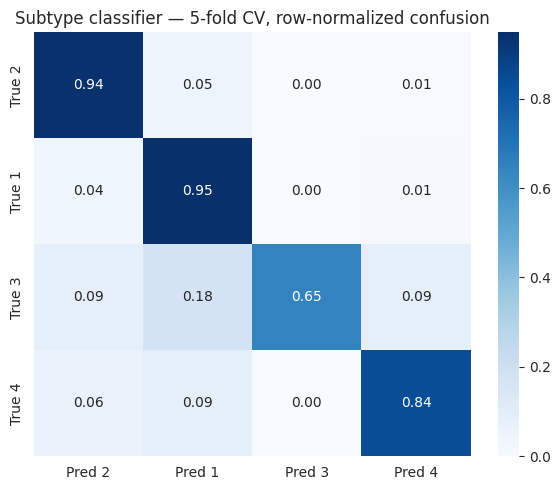

,Importance
Stage_Grouped_Final_Stage IV,0.115696
Stage_Grouped_Final_Stage II,0.093614
T_stage_final_T2B,0.049625
Age at primary Diagnosis,0.046237
T_stage_final_T2,0.041784
Region of birth_Other,0.036625
Region of birth_Pacific,0.036142
T_stage_final_T2A,0.035137
M_stage_final_M1A,0.034428
M_stage_final_M1B,0.032171


In [ ]:
# === CV classifier with proper evaluation (no leakage) ===
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Baseline features you used for clustering:
baseline_cols = [c for c in [
    'Age at primary Diagnosis','Gender','Country of birth','Region of birth',
    'Primary cancer site','Diagnosis_Class','Morphology_Grouped','Laterality_Clean',
    'T_stage_final','N_stage_final','M_stage_final','Stage_Grouped_Final','ECOG_score','ECOG_category'
] if c in dfB.columns]

D = dfB.dropna(subset=baseline_cols+['Subtype']).copy()
X = pd.get_dummies(D[baseline_cols], drop_first=True)
y = D['Subtype'].astype('category')
labels = list(y.cat.categories)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cm_sum = np.zeros((len(labels), len(labels)), dtype=float)
accs = []

for tr, te in skf.split(X, y):
    clf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    clf.fit(X.iloc[tr], y.iloc[tr])
    yhat = clf.predict(X.iloc[te])
    accs.append(accuracy_score(y.iloc[te], yhat))
    cm = confusion_matrix(y.iloc[te], yhat, labels=labels)
    cm_sum += cm

cm_avg = cm_sum / cm_sum.sum(axis=1, keepdims=True)  # row-normalized
print(f"CV accuracy: {np.mean(accs):.3f} ± {np.std(accs):.03f}")

plt.figure(figsize=(6,5))
sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"Pred {c}" for c in labels],
            yticklabels=[f"True {c}" for c in labels])
plt.title("Subtype classifier — 5-fold CV, row-normalized confusion")
plt.tight_layout(); plt.show()

# Optional: fit once on full data and print feature importances
clf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
clf.fit(X, y)
imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
display(imp.to_frame("Importance"))


Subtype prediction (5-fold CV) — Accuracy: 0.930 ± 0.010


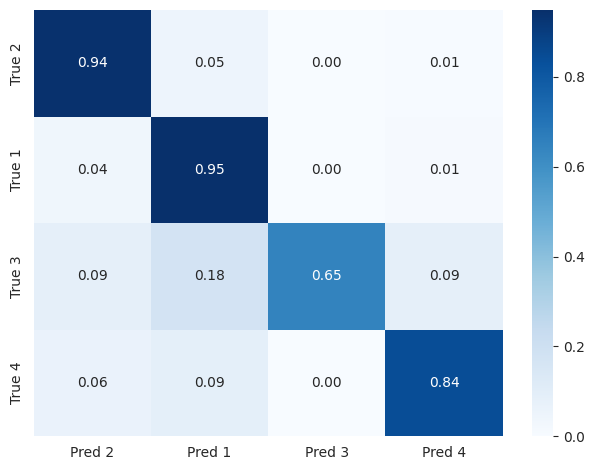


Cross-validated classification report:
              precision    recall  f1-score   support

           1       0.92      0.95      0.93       602
           2       0.95      0.94      0.95       702
           3       1.00      0.65      0.79        34
           4       0.89      0.84      0.87       141

    accuracy                           0.93      1479
   macro avg       0.94      0.85      0.88      1479
weighted avg       0.93      0.93      0.93      1479



In [ ]:
# Cross-validated subtype classifier (no leakage)
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

baseline_cols = [c for c in [
    'Age at primary Diagnosis','Gender','Country of birth','Region of birth',
    'Primary cancer site','Diagnosis_Class','Morphology_Grouped','Laterality_Clean',
    'T_stage_final','N_stage_final','M_stage_final','Stage_Grouped_Final','ECOG_score','ECOG_category'
] if c in dfB.columns]

D = dfB.dropna(subset=baseline_cols+['Subtype']).copy()
X = pd.get_dummies(D[baseline_cols], drop_first=True)
y = D['Subtype'].astype('category')

clf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print(f"Subtype prediction (5-fold CV) — Accuracy: {acc.mean():.3f} ± {acc.std():.03f}")

y_cvpred = cross_val_predict(clf, X, y, cv=cv, method='predict')
cm = confusion_matrix(y, y_cvpred, labels=list(y.cat.categories))
cm_df = pd.DataFrame(cm, index=[f"True {c}" for c in y.cat.categories],
                        columns=[f"Pred {c}" for c in y.cat.categories])
sns.heatmap(cm_df/np.maximum(cm_df.sum(1),1).values[:,None], annot=True, fmt=".2f", cmap="Blues")
#plt.title("Subtype classifier — row-normalized confusion (5-fold CV)")
plt.tight_layout(); plt.show()

print("\nCross-validated classification report:")
print(classification_report(y, y_cvpred))


In [ ]:
# ============================================================
# INTERNAL SPLIT-VALIDATION (70/30)
# - Train: fit scaler+PCA, cluster (Ward, k=4), label train
# - Test: transform with train scaler+PCA, assign to nearest centroid
# - Evaluate on TEST ONLY: Cox (TNM/ECOG) vs +Subtype, C-index, ΔC, LR test
# ============================================================

import numpy as np, pandas as pd, re, warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from lifelines import CoxPHFitter
from sklearn.utils import resample
from scipy.stats import chi2
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min, davies_bouldin_score, calinski_harabasz_score

# ------------ CONFIG ------------
CSV_PATH   = "/content/Patient_Master_Table.csv"   # <- change if needed
K_CLUSTERS = 4
TEST_SIZE  = 0.30
RANDOM_SEED= 42
B_BOOT     = 100   # 300–1000 for final manuscript

BASELINE_WHITELIST = [
    'Age at primary Diagnosis','Gender','Region of birth','Primary cancer site',
    'Diagnosis_Class','Morphology_Grouped','Laterality_Clean',
    'T_stage_final','N_stage_final','M_stage_final','Stage_Grouped_Final','ECOG_score'
]
OUTCOME_COLS = ['OS_days','OS_event']  # PFS optional (not used here)

# ------------ HELPERS ------------
def q(col):  # quote for Patsy if spaces/symbols
    return f"Q('{col}')" if any(ch in col for ch in " -+/()[]") else col

def ensure_binary(series):
    return (series.astype(float).fillna(0) > 0).astype(int)

def build_design(df, features):
    # one-hot encode categoricals but keep ECOG_score numeric
    keep = [c for c in features if c in df.columns]
    X = df[keep].copy()
    cat = [c for c in keep if (X[c].dtype=='object' or str(X[c].dtype).startswith('category')) and c!='ECOG_score']
    X_enc = pd.get_dummies(X, columns=cat, drop_first=True)
    return X_enc

def cindex(model, data, tcol, ecol):
    ph = model.predict_partial_hazard(data)
    return model._concordance_index(data[tcol].values, -ph.values, data[ecol].values)

# ------------ LOAD & FILTER ------------
dfm = pd.read_csv(CSV_PATH)
missing_req = [c for c in OUTCOME_COLS+['Stage_Grouped_Final','Gender','Age at primary Diagnosis'] if c not in dfm.columns]
if missing_req:
    raise RuntimeError(f"Missing required columns: {missing_req}")

# Complete-case on *baseline* features only (matches derivation philosophy)
exists = [c for c in BASELINE_WHITELIST if c in dfm.columns]
df0 = dfm.dropna(subset=exists).copy()

# Keep rows with OS info for evaluation (we will evaluate on test with OS present)
# (We don't drop them now to avoid leakage in clustering composition)
n_all = len(df0)
print(f"Complete-case baseline cohort: n={n_all}")

# ------------ TRAIN/TEST SPLIT (stratify by Stage to preserve case-mix) ------------
strata = df0['Stage_Grouped_Final'].astype(str).fillna('UNK')
train_idx, test_idx = train_test_split(
    df0.index, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=strata
)
df_train = df0.loc[train_idx].copy()
df_test  = df0.loc[test_idx].copy()
print(f"Train n={len(df_train)} | Test n={len(df_test)} (stratified by Stage)")

# ------------ TRAIN: scale, PCA (90% var), Ward clustering, labels ------------
Xtr = build_design(df_train, BASELINE_WHITELIST)
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)

pca_full = PCA().fit(Xtr_s)
cum = np.cumsum(pca_full.explained_variance_ratio_)
ncomp = int(np.searchsorted(cum, 0.90) + 1)
pca = PCA(n_components=ncomp).fit(Xtr_s)
Xtr_p = pca.transform(Xtr_s)

Z = linkage(Xtr_p, method='ward')
labels_tr = fcluster(Z, t=K_CLUSTERS, criterion='maxclust')

# Silhouette on TRAIN (diagnostic)
try:
    sil = silhouette_score(Xtr_p, labels_tr, metric="euclidean")
    print(f"Train silhouette (k={K_CLUSTERS}, PCA space): {sil:.3f}")
except Exception as e:
    print(f"Silhouette unavailable: {e}")
# --- ADD THIS SNIPPET ---

# Davies-Bouldin on TRAIN (diagnostic)
try:
    db_score = davies_bouldin_score(Xtr_p, labels_tr)
    print(f"Train Davies-Bouldin (k={K_CLUSTERS}, PCA space): {db_score:.3f} (closer to 0 is better)")
except Exception as e:
    print(f"Davies-Bouldin unavailable: {e}")

# Calinski-Harabasz on TRAIN (diagnostic)
try:
    ch_score = calinski_harabasz_score(Xtr_p, labels_tr)
    print(f"Train Calinski-Harabasz (k={K_CLUSTERS}, PCA space): {ch_score:.3f} (higher is better)")
except Exception as e:
    print(f"Calinski-Harabasz unavailable: {e}")

# --- END OF SNIPPET ---

# Compute centroids in PCA space
centroids = []
for k in range(1, K_CLUSTERS+1):
    centroids.append(Xtr_p[labels_tr==k].mean(axis=0))
centroids = np.vstack(centroids)

# ------------ TEST: transform and assign to nearest centroid ------------
Xte = build_design(df_test, BASELINE_WHITELIST)

# align columns to training design
missing_cols = [c for c in Xtr.columns if c not in Xte.columns]
for c in missing_cols:
    Xte[c] = 0
extra_cols = [c for c in Xte.columns if c not in Xtr.columns]
if extra_cols:
    Xte = Xte.drop(columns=extra_cols)

Xte = Xte[Xtr.columns]  # same order
Xte_s = scaler.transform(Xte)
Xte_p = pca.transform(Xte_s)

assign_idx, dists = pairwise_distances_argmin_min(Xte_p, centroids)
labels_te = assign_idx + 1  # 1..K to match training labels

# Attach labels
df_train = df_train.copy()
df_test  = df_test.copy()
df_train["Subtype_SPLIT"] = labels_tr
df_test["Subtype_SPLIT"]  = labels_te

print("Train subtype sizes:", pd.Series(labels_tr).value_counts().sort_index().to_dict())
print("Test subtype sizes :", pd.Series(labels_te).value_counts().sort_index().to_dict())

# ------------ EVALUATE ON TEST ONLY (OS) ------------
# Keep only complete rows for OS evaluation
eval_cols = ["OS_days","OS_event","Subtype_SPLIT","Stage_Grouped_Final","Gender","Age at primary Diagnosis","ECOG_score"]
eval_cols = [c for c in eval_cols if c in df_test.columns]
dte = df_test.dropna(subset=[c for c in ["OS_days","OS_event","Subtype_SPLIT","Stage_Grouped_Final","Gender","Age at primary Diagnosis"] if c in df_test.columns]).copy()

# event cleaning
dte["OS_event"] = ensure_binary(dte["OS_event"])
dte["Subtype_SPLIT"] = dte["Subtype_SPLIT"].astype("category")

print(f"TEST set for Cox (OS): n={len(dte)}; subtypes={list(dte['Subtype_SPLIT'].cat.categories)}")

# Build formulas (TNM/ECOG may be missing -> handle gracefully)
cov_base = []
if "Age at primary Diagnosis" in dte.columns: cov_base.append(q("Age at primary Diagnosis"))
if "Gender" in dte.columns:                   cov_base.append("C(Gender)")
cov_tnm  = ["C(Stage_Grouped_Final)"] if "Stage_Grouped_Final" in dte.columns else []
cov_ecog = [q("ECOG_score")] if "ECOG_score" in dte.columns else []

formula_null = " + ".join(cov_base + cov_tnm + cov_ecog) if (cov_base or cov_tnm or cov_ecog) else "1"
formula_full = formula_null + " + C(Subtype_SPLIT)"

cph_null = CoxPHFitter(penalizer=0.01).fit(dte, duration_col="OS_days", event_col="OS_event", formula=formula_null)
cph_full = CoxPHFitter(penalizer=0.01).fit(dte, duration_col="OS_days", event_col="OS_event", formula=formula_full)

print("\n--- TEST Cox (TNM/ECOG without Subtype) ---")
cph_null.print_summary(decimals=3)
print(f"Test C-index (apparent): {cph_null.concordance_index_:.3f}")

print("\n--- TEST Cox (TNM/ECOG + Subtype) ---")
cph_full.print_summary(decimals=3)
print(f"Test C-index (apparent): {cph_full.concordance_index_:.3f}")

# Likelihood-ratio test on TEST set
lr_stat = 2*(cph_full.log_likelihood_ - cph_null.log_likelihood_)
df_diff = cph_full.params_.shape[0] - cph_null.params_.shape[0]
p_lr = 1 - chi2.cdf(lr_stat, df_diff)
print(f"\nTEST LR test (Subtype added): χ²={lr_stat:.3f} on {df_diff} df, p={p_lr:.4g}")

# ------------ Bootstrap CIs for TEST C-index & ΔC ------------
def safe_fit_cindex(formula, data):
    m = CoxPHFitter(penalizer=0.01).fit(data, duration_col="OS_days", event_col="OS_event", formula=formula)
    return cindex(m, data, "OS_days", "OS_event")

rng = np.random.RandomState(RANDOM_SEED)
C0, C1, dC = [], [], []
for _ in range(B_BOOT):
    dd = dte.sample(len(dte), replace=True, random_state=rng.randint(0, 10**9))
    try:
        c0 = safe_fit_cindex(formula_null, dd)
        c1 = safe_fit_cindex(formula_full, dd)
        C0.append(c0); C1.append(c1); dC.append(c1 - c0)
    except Exception:
        pass

def ci(a):
    a = np.array(a)
    return a.mean(), np.percentile(a, 2.5), np.percentile(a, 97.5)

if len(C0) and len(C1) and len(dC):
    m0, lo0, hi0 = ci(C0)
    m1, lo1, hi1 = ci(C1)
    md, lod, hid = ci(dC)
    print(f"\nTEST C-index (TNM/ECOG): {m0:.3f} [{lo0:.3f}, {hi0:.3f}]")
    print(f"TEST C-index (TNM/ECOG + Subtype): {m1:.3f} [{lo1:.3f}, {hi1:.3f}]")
    print(f"TEST ΔC-index: {md:.3f} [{lod:.3f}, {hid:.3f}]")
else:
    print("Bootstrap CIs unavailable (all resamples failed).")

print("\n✅ Split-validation complete.")


Complete-case baseline cohort: n=1479
Train n=1035 | Test n=444 (stratified by Stage)
Train silhouette (k=4, PCA space): 0.055
Train Davies-Bouldin (k=4, PCA space): 3.717 (closer to 0 is better)
Train Calinski-Harabasz (k=4, PCA space): 35.870 (higher is better)
Train subtype sizes: {1: 78, 2: 352, 3: 504, 4: 101}
Test subtype sizes : {1: 38, 2: 163, 3: 206, 4: 37}
TEST set for Cox (OS): n=375; subtypes=[1, 2, 3, 4]

--- TEST Cox (TNM/ECOG without Subtype) ---


<lifelines.CoxPHFitter: fitted with 375 total observations, 71 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 375
number of events observed = 304
   partial log-likelihood = -1491.769
         time fit was run = 2025-11-08 01:33:55 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
Q('Age at primary Diagnosis')       0.014     1.014     0.006           0.003           0.026               1.003               1.026
C(Gender)[T.Male]                   0.250     1.284     0.119           0.016           0.484               1.016               1.622
C(Stage_Grouped_Final)[T.Stage II]  0.418     1.520     0.266          -0.102           0.939               0.903               2.557
C(Stage_Grouped_Final)[T.Stage III] 0.468     1.596     0.194           0.088           0.847               1.092               2.333
C(Stage_Grouped_Final)[T.Stage IV]  1.161     3.192     0.175           0.817           1.505               2.263               4.502
ECOG_score                          0.135     1.144     0.066           0.004           0.265               1.004               1.303

                                     cmp to     z       p  -log2(p)
covariate                                                          
Q('Age at primary Diagnosis')         0.000 2.392   0.017     5.900
C(Gender)[T.Male]                     0.000 2.094   0.036     4.785
C(Stage_Grouped_Final)[T.Stage II]    0.000 1.576   0.115     3.119
C(Stage_Grouped_Final)[T.Stage III]   0.000 2.413   0.016     5.984
C(Stage_Grouped_Final)[T.Stage IV]    0.000 6.615 <0.0005    34.648
ECOG_score                            0.000 2.027   0.043     4.552
---
Concordance = 0.667
Partial AIC = 2995.537
log-likelihood ratio test = 74.315 on 6 df
-log2(p) of ll-ratio test = 44.098

Test C-index (apparent): 0.667

--- TEST Cox (TNM/ECOG + Subtype) ---


<lifelines.CoxPHFitter: fitted with 375 total observations, 71 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 375
number of events observed = 304
   partial log-likelihood = -1487.691
         time fit was run = 2025-11-08 01:33:55 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
Q('Age at primary Diagnosis')        0.015     1.015     0.006           0.003           0.026               1.003               1.027
C(Gender)[T.Male]                    0.237     1.267     0.121          -0.000           0.474               1.000               1.606
C(Stage_Grouped_Final)[T.Stage II]   0.390     1.478     0.267          -0.132           0.913               0.876               2.492
C(Stage_Grouped_Final)[T.Stage III]  0.441     1.554     0.194           0.060           0.822               1.062               2.274
C(Stage_Grouped_Final)[T.Stage IV]   1.363     3.910     0.285           0.805           1.922               2.236               6.835
ECOG_score                           0.165     1.180     0.068           0.032           0.298               1.033               1.347
C(Subtype_SPLIT)[T.2]               -0.661     0.516     0.228          -1.107          -0.215               0.331               0.807
C(Subtype_SPLIT)[T.3]               -0.378     0.685     0.259          -0.886           0.130               0.412               1.139
C(Subtype_SPLIT)[T.4]               -0.627     0.534     0.289          -1.193          -0.060               0.303               0.942

                                     cmp to      z       p  -log2(p)
covariate                                                           
Q('Age at primary Diagnosis')         0.000  2.430   0.015     6.049
C(Gender)[T.Male]                     0.000  1.956   0.050     4.308
C(Stage_Grouped_Final)[T.Stage II]    0.000  1.464   0.143     2.804
C(Stage_Grouped_Final)[T.Stage III]   0.000  2.271   0.023     5.431
C(Stage_Grouped_Final)[T.Stage IV]    0.000  4.784 <0.0005    19.150
ECOG_score                            0.000  2.434   0.015     6.066
C(Subtype_SPLIT)[T.2]                 0.000 -2.904   0.004     8.084
C(Subtype_SPLIT)[T.3]                 0.000 -1.458   0.145     2.788
C(Subtype_SPLIT)[T.4]                 0.000 -2.166   0.030     5.046
---
Concordance = 0.674
Partial AIC = 2993.381
log-likelihood ratio test = 82.471 on 9 df
-log2(p) of ll-ratio test = 44.125

Test C-index (apparent): 0.674

TEST LR test (Subtype added): χ²=8.156 on 3 df, p=0.04289
Bootstrap CIs unavailable (all resamples failed).

✅ Split-validation complete.


In [ ]:
# Install once per session (Colab-friendly):
!pip -q install scikit-survival --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.4 MB/s eta 0:00:00


[OS_days] cleaned: total=1479, dropped_negatives=1, bumped_zero_to_1d=3
N used — Model A: 1254, B: 1254, C: 1254


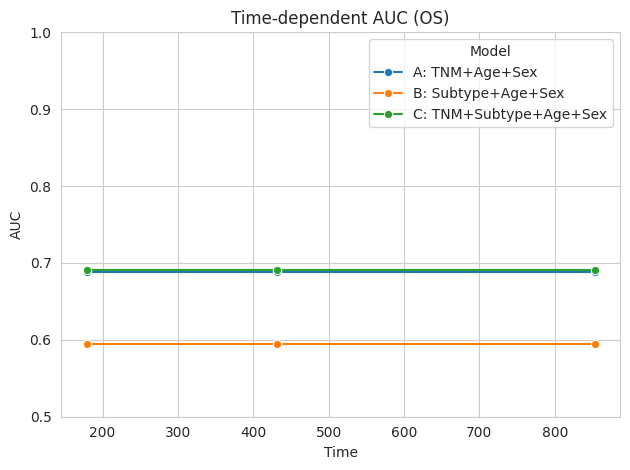

In [ ]:
# ============================================================
# Fix survival times (<=0), then re-run time-dependent AUC (A/B/C)
# ============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# --- 0) pick working dataframe (from earlier blocks) ---
if 'dfB' in globals():
    d0 = dfB.copy()
elif 'df_profile' in globals():
    d0 = df_profile.copy()
else:
    raise RuntimeError("Need dfB or df_profile in memory.")

# --- 1) cleaning helper ---
def clean_survival(df, time_col, event_col, min_day=1):
    d = df.copy()
    # coerce types
    d[time_col]  = pd.to_numeric(d[time_col], errors='coerce')
    d[event_col] = (pd.to_numeric(d[event_col], errors='coerce').fillna(0) > 0).astype(int)

    n_total = len(d)
    n_neg   = (d[time_col] < 0).sum()
    n_zero  = (d[time_col] == 0).sum()

    # drop negatives (data errors)
    d = d[d[time_col] >= 0].copy()

    # bump zeros to min_day (keeps same-day events/censoring but satisfies sksurv)
    zero_mask = d[time_col] == 0
    d.loc[zero_mask, time_col] = min_day

    print(f"[{time_col}] cleaned: total={n_total}, dropped_negatives={n_neg}, bumped_zero_to_{min_day}d={n_zero}")
    return d

# --- 2) choose endpoint (OS) and clean ---
need = ['OS_days','OS_event','Age at primary Diagnosis','Gender','Stage_Grouped_Final','Subtype']
have = [c for c in need if c in d0.columns]
if not all(c in d0.columns for c in ['OS_days','OS_event']):
    raise RuntimeError("OS_days/OS_event not found.")

d = clean_survival(d0, 'OS_days', 'OS_event', min_day=1)

# keep only rows with complete predictors for each model
def mk_design_A(df):
    cols = ['Stage_Grouped_Final','Gender','Age at primary Diagnosis']
    dd = df.dropna(subset=['OS_days','OS_event'] + [c for c in cols if c in df.columns]).copy()
    X  = pd.get_dummies(dd[['Stage_Grouped_Final','Gender']], drop_first=True, dtype=int)
    X  = X.assign(**{"Age at primary Diagnosis": dd['Age at primary Diagnosis']})
    y_struct = np.array(list(zip(dd['OS_event'].astype(bool).values, dd['OS_days'].values)),
                        dtype=[('event', bool), ('time', float)])
    return X, y_struct

def mk_design_B(df):
    cols = ['Subtype','Gender','Age at primary Diagnosis']
    dd = df.dropna(subset=['OS_days','OS_event'] + [c for c in cols if c in df.columns]).copy()
    X  = pd.get_dummies(dd[['Subtype','Gender']], drop_first=True, dtype=int)
    X  = X.assign(**{"Age at primary Diagnosis": dd['Age at primary Diagnosis']})
    y_struct = np.array(list(zip(dd['OS_event'].astype(bool).values, dd['OS_days'].values)),
                        dtype=[('event', bool), ('time', float)])
    return X, y_struct

def mk_design_C(df):
    cols = ['Stage_Grouped_Final','Subtype','Gender','Age at primary Diagnosis']
    dd = df.dropna(subset=['OS_days','OS_event'] + [c for c in cols if c in df.columns]).copy()
    X  = pd.get_dummies(dd[['Stage_Grouped_Final','Subtype','Gender']], drop_first=True, dtype=int)
    X  = X.assign(**{"Age at primary Diagnosis": dd['Age at primary Diagnosis']})
    y_struct = np.array(list(zip(dd['OS_event'].astype(bool).values, dd['OS_days'].values)),
                        dtype=[('event', bool), ('time', float)])
    return X, y_struct

XA, yA = mk_design_A(d)
XB, yB = mk_design_B(d)
XC, yC = mk_design_C(d)

print(f"N used — Model A: {len(yA)}, B: {len(yB)}, C: {len(yC)}")

# --- 3) time-dependent AUC with scikit-survival ---
try:
    from sksurv.metrics import cumulative_dynamic_auc
    from sksurv.linear_model import CoxPHSurvivalAnalysis

    def time_auc(X, y, label):
        # Use quantiles from this y for evaluation times
        times = np.percentile(y['time'], [25, 50, 75])
        # Train and evaluate on the same set (if you want a holdout split, add train_test_split)
        model = CoxPHSurvivalAnalysis().fit(X, y)
        _, aucs = cumulative_dynamic_auc(y, y, model.predict(X), times)
        return pd.DataFrame({"Model": label, "Time": times, "AUC": aucs})

    aucs_A = time_auc(XA, yA, "A: TNM+Age+Sex")
    aucs_B = time_auc(XB, yB, "B: Subtype+Age+Sex")
    aucs_C = time_auc(XC, yC, "C: TNM+Subtype+Age+Sex")
    aucs_all = pd.concat([aucs_A, aucs_B, aucs_C], ignore_index=True)

    sns.lineplot(data=aucs_all, x="Time", y="AUC", hue="Model", marker="o")
    plt.ylim(0.5, 1.0)
    plt.title("Time-dependent AUC (OS)")
    plt.tight_layout()
    plt.show()

except ModuleNotFoundError:
    print("scikit-survival is not installed; showing C-index + simple calibration fallback is recommended.")


,Decile,Observed,Predicted,N
0,1,0.358802,0.445928,127
1,2,0.573815,0.538996,126
2,3,0.725625,0.635119,123
3,4,0.782663,0.734930,127
4,5,0.720815,0.787172,125
5,6,0.869908,0.828665,125
6,7,0.860055,0.857924,125
7,8,0.915152,0.885028,125
8,9,0.884122,0.909401,125
9,10,0.904102,0.934396,126


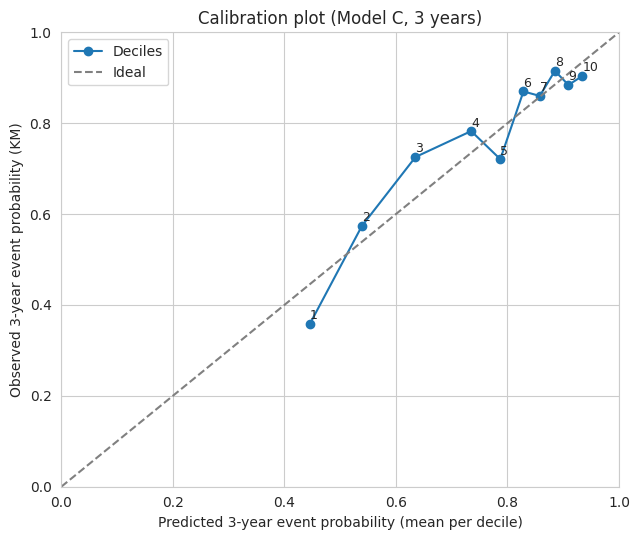

Approx. (uncensored) Brier at 3y: 0.176  [use IPCW for exact]


In [ ]:
# ================= Calibration at 3 years for Model C =================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter

sns.set_style("whitegrid")

# --- pick/clean data ---
if 'dfB' in globals(): d0 = dfB.copy()
elif 'df_profile' in globals(): d0 = df_profile.copy()
else: raise RuntimeError("Need dfB or df_profile in memory.")

def clean_surv(df, time_col, event_col, min_day=1):
    d = df.copy()
    d[time_col] = pd.to_numeric(d[time_col], errors='coerce')
    d[event_col] = (pd.to_numeric(d[event_col], errors='coerce').fillna(0) > 0).astype(int)
    d = d[d[time_col] >= 0].copy()
    d.loc[d[time_col]==0, time_col] = min_day
    return d

d = clean_surv(d0, "OS_days", "OS_event")
need = ["OS_days","OS_event","Stage_Grouped_Final","Subtype","Age at primary Diagnosis","Gender"]
d = d.dropna(subset=[c for c in need if c in d.columns]).copy()

T_y = 3
T_days = int(round(T_y*365.25))

# --- fit Model C Cox and get predicted 3y risk ---
formulaC = "C(Stage_Grouped_Final) + C(Subtype) + Q('Age at primary Diagnosis') + C(Gender)"
cphC = CoxPHFitter().fit(d, duration_col="OS_days", event_col="OS_event", formula=formulaC)

sf = cphC.predict_survival_function(d, times=[T_days])
d["pred3y_risk"] = 1 - sf.iloc[0].values

# --- deciles & observed event probability at 3y (KM within each decile) ---
d["risk_decile"] = pd.qcut(d["pred3y_risk"], 10, labels=False, duplicates="drop")
km = KaplanMeierFitter()
obs, pred = [], []
ns = []

for dec in sorted(d["risk_decile"].dropna().unique()):
    g = d[d["risk_decile"]==dec]
    km.fit(g["OS_days"], event_observed=g["OS_event"])
    # observed event prob at 3y ≈ 1 - KM(3y) (linear interp on the step function)
    t = km.survival_function_.index.values
    s = km.survival_function_["KM_estimate"].values
    s_at = np.interp(T_days, t, s, left=1.0, right=s[-1] if len(s) else 1.0)
    obs.append(1 - s_at)
    pred.append(g["pred3y_risk"].mean())
    ns.append(len(g))

cal = pd.DataFrame({"Decile":range(1,len(obs)+1), "Observed":obs, "Predicted":pred, "N":ns})
display(cal)

# --- plot calibration ---
plt.figure(figsize=(6.5,5.5))
plt.plot(pred, obs, "o-", label="Deciles")
plt.plot([0,1],[0,1],"--", color="gray", label="Ideal")
for i,(x,y,n) in enumerate(zip(pred,obs,ns), start=1):
    plt.text(x, y+0.01, str(i), fontsize=9)
plt.xlabel("Predicted 3-year event probability (mean per decile)")
plt.ylabel("Observed 3-year event probability (KM)")
plt.title("Calibration plot (Model C, 3 years)")
plt.ylim(0,1); plt.xlim(0,1); plt.legend(); plt.tight_layout(); plt.show()

# optional: Brier score at 3y (approximate, ignores IPCW)
brier = np.mean((d["pred3y_risk"] - ( (d["OS_event"]==1) & (d["OS_days"]<=T_days) ).astype(int))**2)
print(f"Approx. (uncensored) Brier at 3y: {brier:.3f}  [use IPCW for exact]")


In [ ]:
# ========== Cox with Subtype × Treatment interaction (robust) ==========
import pandas as pd
from lifelines import CoxPHFitter

# assumes d from calibration block is in memory; otherwise rebuild d like above
D_INTER = d.copy()

TREAT_FLAGS = [c for c in ["SABR_FLAG","Chemo_FLAG","Surgery_FLAG"] if c in D_INTER.columns]

def cox_interaction(df, treat, by_stage=False):
    dd = df.dropna(subset=["OS_days","OS_event","Subtype",treat,"Age at primary Diagnosis","Gender"]).copy()
    dd["OS_event"] = dd["OS_event"].astype(int)
    dd["Subtype"]  = dd["Subtype"].astype("category").cat.remove_unused_categories()

    # skip sparse exposure: need >=5 treated and >=5 untreated within each subtype
    tab = pd.crosstab(dd["Subtype"], dd[treat])
    if (tab.min(axis=1) < 5).any():
        print(f"{treat}: skipped (sparse exposure in ≥1 subtype):\n{tab}")
        return

    def fit_one(df_in, stage_label=None):
        f_terms = [
            "Q('Age at primary Diagnosis')",
            "C(Gender)",
            "C(Subtype)",
            f"{treat}",
            f"C(Subtype):{treat}"
        ]
        # include Stage term unless running a within-stage model
        if not stage_label:
            if "Stage_Grouped_Final" in df_in.columns:
                f_terms.insert(0,"C(Stage_Grouped_Final)")
        formula = " + ".join(f_terms)
        cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.0)  # ridge for stability
        cph.fit(df_in, duration_col="OS_days", event_col="OS_event", formula=formula)
        print(f"\n--- Cox OS: Subtype × {treat}" + (f" | Stage={stage_label}" if stage_label else " (all stages)") + " ---")
        cph.print_summary(decimals=3)
        return cph

    if by_stage and "Stage_Grouped_Final" in dd.columns:
        for st in ["Stage I","Stage II","Stage III","Stage IV"]:
            d_st = dd[dd["Stage_Grouped_Final"]==st]
            if len(d_st) >= 60 and d_st["Subtype"].nunique()>=2 and d_st[treat].nunique()>=2:
                fit_one(d_st, stage_label=st)
            else:
                print(f"{treat} | {st}: insufficient data (n={len(d_st)})")
    else:
        fit_one(dd)

for t in TREAT_FLAGS:
    cox_interaction(D_INTER, t, by_stage=False)   # set True for per-stage analyses



--- Cox OS: Subtype × SABR_FLAG (all stages) ---


<lifelines.CoxPHFitter: fitted with 1254 total observations, 230 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1254
number of events observed = 1024
   partial log-likelihood = -6282.797
         time fit was run = 2025-11-08 01:34:14 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
C(Stage_Grouped_Final)[T.Stage II]   0.284     1.328     0.175          -0.060           0.627               0.942               1.873
C(Stage_Grouped_Final)[T.Stage III]  0.477     1.612     0.089           0.304           0.651               1.355               1.918
C(Stage_Grouped_Final)[T.Stage IV]   0.819     2.268     0.084           0.654           0.983               1.924               2.673
Q('Age at primary Diagnosis')        0.008     1.008     0.003           0.002           0.014               1.002               1.014
C(Gender)[T.Male]                    0.195     1.215     0.061           0.075           0.314               1.078               1.369
C(Subtype)[T.1]                     -0.032     0.969     0.076          -0.181           0.118               0.834               1.125
C(Subtype)[T.3]                     -0.217     0.805     0.242          -0.691           0.257               0.501               1.293
C(Subtype)[T.4]                     -0.241     0.786     0.162          -0.558           0.077               0.573               1.080
SABR_FLAG                            0.234     1.263     0.089           0.058           0.409               1.060               1.505
C(Subtype)[T.1]:SABR_FLAG            0.159     1.173     0.116          -0.069           0.387               0.934               1.473
C(Subtype)[T.3]:SABR_FLAG           -0.624     0.536     0.450          -1.507           0.258               0.222               1.295
C(Subtype)[T.4]:SABR_FLAG            0.004     1.004     0.347          -0.677           0.684               0.508               1.982

                                     cmp to      z       p  -log2(p)
covariate                                                           
C(Stage_Grouped_Final)[T.Stage II]    0.000  1.618   0.106     3.243
C(Stage_Grouped_Final)[T.Stage III]   0.000  5.391 <0.0005    23.764
C(Stage_Grouped_Final)[T.Stage IV]    0.000  9.763 <0.0005    72.378
Q('Age at primary Diagnosis')         0.000  2.679   0.007     7.080
C(Gender)[T.Male]                     0.000  3.195   0.001     9.482
C(Subtype)[T.1]                       0.000 -0.414   0.679     0.559
C(Subtype)[T.3]                       0.000 -0.897   0.370     1.436
C(Subtype)[T.4]                       0.000 -1.486   0.137     2.865
SABR_FLAG                             0.000  2.614   0.009     6.805
C(Subtype)[T.1]:SABR_FLAG             0.000  1.370   0.171     2.550
C(Subtype)[T.3]:SABR_FLAG             0.000 -1.386   0.166     2.594
C(Subtype)[T.4]:SABR_FLAG             0.000  0.010   0.992     0.012
---
Concordance = 0.654
Partial AIC = 12589.593
log-likelihood ratio test = 197.005 on 12 df
-log2(p) of ll-ratio test = 115.831


--- Cox OS: Subtype × Chemo_FLAG (all stages) ---


<lifelines.CoxPHFitter: fitted with 1254 total observations, 230 right-censored observations>
             duration col = 'OS_days'
                event col = 'OS_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1254
number of events observed = 1024
   partial log-likelihood = -6289.775
         time fit was run = 2025-11-08 01:34:14 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
C(Stage_Grouped_Final)[T.Stage II]   0.341     1.406     0.175          -0.003           0.685               0.997               1.983
C(Stage_Grouped_Final)[T.Stage III]  0.435     1.545     0.092           0.254           0.615               1.290               1.850
C(Stage_Grouped_Final)[T.Stage IV]   0.861     2.365     0.086           0.693           1.028               1.999               2.796
Q('Age at primary Diagnosis')        0.008     1.008     0.003           0.002           0.014               1.002               1.014
C(Gender)[T.Male]                    0.198     1.219     0.061           0.079           0.318               1.082               1.374
C(Subtype)[T.1]                      0.063     1.065     0.090          -0.114           0.239               0.893               1.270
C(Subtype)[T.3]                     -0.332     0.717     0.316          -0.952           0.287               0.386               1.333
C(Subtype)[T.4]                     -0.049     0.952     0.171          -0.384           0.286               0.681               1.332
Chemo_FLAG                           0.014     1.014     0.082          -0.148           0.176               0.863               1.192
C(Subtype)[T.1]:Chemo_FLAG          -0.113     0.893     0.103          -0.315           0.089               0.730               1.093
C(Subtype)[T.3]:Chemo_FLAG          -0.118     0.888     0.377          -0.856           0.620               0.425               1.858
C(Subtype)[T.4]:Chemo_FLAG          -0.545     0.580     0.202          -0.941          -0.149               0.390               0.861

                                     cmp to      z       p  -log2(p)
covariate                                                           
C(Stage_Grouped_Final)[T.Stage II]    0.000  1.943   0.052     4.264
C(Stage_Grouped_Final)[T.Stage III]   0.000  4.724 <0.0005    18.722
C(Stage_Grouped_Final)[T.Stage IV]    0.000 10.056 <0.0005    76.618
Q('Age at primary Diagnosis')         0.000  2.494   0.013     6.307
C(Gender)[T.Male]                     0.000  3.250   0.001     9.761
C(Subtype)[T.1]                       0.000  0.698   0.485     1.044
C(Subtype)[T.3]                       0.000 -1.052   0.293     1.771
C(Subtype)[T.4]                       0.000 -0.286   0.775     0.367
Chemo_FLAG                            0.000  0.168   0.866     0.207
C(Subtype)[T.1]:Chemo_FLAG            0.000 -1.100   0.271     1.883
C(Subtype)[T.3]:Chemo_FLAG            0.000 -0.315   0.753     0.409
C(Subtype)[T.4]:Chemo_FLAG            0.000 -2.699   0.007     7.169
---
Concordance = 0.649
Partial AIC = 12603.551
log-likelihood ratio test = 183.047 on 12 df
-log2(p) of ll-ratio test = 106.287

Surgery_FLAG: skipped (sparse exposure in ≥1 subtype):
Surgery_FLAG    0  1
Subtype             
2             580  2
1             524  4
3              28  1
4             114  1


,beta
covariate,
C(Stage_Grouped_Final)[T.Stage IV],1.248188
C(Stage_Grouped_Final)[T.Stage II],0.791161
C(Stage_Grouped_Final)[T.Stage III],0.757834
C(Subtype)[T.4],-0.530209
C(Subtype)[T.3],-0.472888
C(Gender)[T.Male],0.199549
C(Subtype)[T.1],-0.113745
Q('Age at primary Diagnosis'),0.011656


,Points
covariate,
C(Stage_Grouped_Final)[T.Stage IV],100.0
C(Stage_Grouped_Final)[T.Stage II],63.4
C(Stage_Grouped_Final)[T.Stage III],60.7
C(Subtype)[T.4],-42.5
C(Subtype)[T.3],-37.9
C(Gender)[T.Male],16.0
C(Subtype)[T.1],-9.1
Q('Age at primary Diagnosis'),0.9


/tmp/ipython-input-4169293288.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_table["Points"].abs(), y=score_table.index, orient="h", palette="viridis")


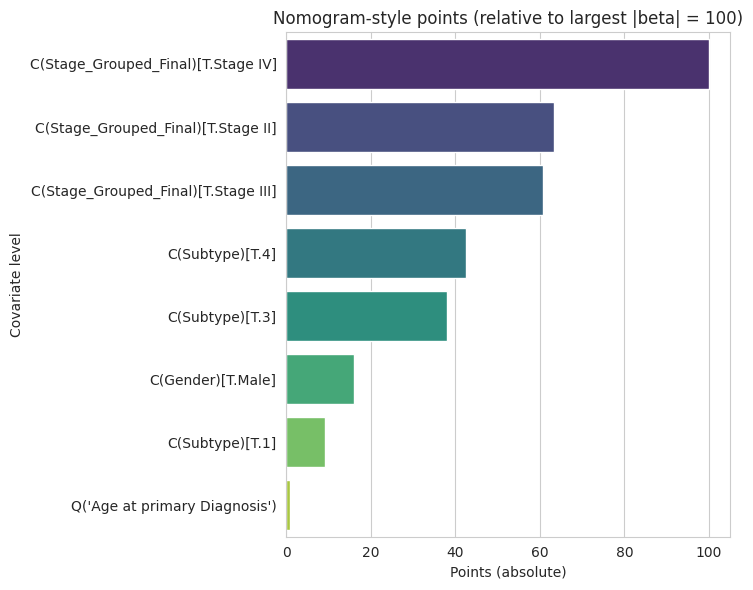


Example risks (edit inputs below):
• Baseline-ish patient: 0.929410079782573
• Higher-risk profile : 0.9455218199225799


In [ ]:
# ================= Nomogram-style risk score (Model C) =================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# Reuse cphC (Model C) from calibration block. If not present, fit it again:
try:
    cphC
except NameError:
    formulaC = "C(Stage_Grouped_Final) + C(Subtype) + Q('Age at primary Diagnosis') + C(Gender)"
    cphC = CoxPHFitter().fit(d, duration_col="OS_days", event_col="OS_event", formula=formulaC)

# --- extract betas (coefficients) ---
coefs = cphC.params_.copy()
coefs = coefs.sort_values(key=lambda s: s.abs(), ascending=False)
display(coefs.to_frame("beta").head(20))

# --- convert to points (linear scaling) ---
max_abs = coefs.abs().max()
points = (coefs / max_abs * 100).round(1)   # largest abs(beta) = 100 points
score_table = points.rename("Points").to_frame()
display(score_table)

plt.figure(figsize=(7.5,6))
sns.barplot(x=score_table["Points"].abs(), y=score_table.index, orient="h", palette="viridis")
plt.title("Nomogram-style points (relative to largest |beta| = 100)")
plt.xlabel("Points (absolute)"); plt.ylabel("Covariate level"); plt.tight_layout(); plt.show()

# --- simple risk calculator at 3 years ---
T_days = int(round(3*365.25))

def predict_risk_3y_from_profile(age, gender, stage, subtype):
    """
    age: numeric
    gender: category exactly as in data (e.g., 'Male'/'Female')
    stage: category exactly as in data (e.g., 'Stage I'..'Stage IV')
    subtype: cluster label exactly as in data (e.g., 1,2,3,4 or strings if you relabeled)
    """
    # build one-row dataframe with same encoding columns as training data
    row = pd.DataFrame({
        "OS_days":[1], "OS_event":[0],
        "Age at primary Diagnosis":[age],
        "Gender":[gender],
        "Stage_Grouped_Final":[stage],
        "Subtype":[subtype]
    })
    # survival prob at 3y then convert to risk
    sf = cphC.predict_survival_function(row, times=[T_days])
    risk = 1 - sf.iloc[0].values[0]
    return float(risk)

# --- demo: compute risk for two hypothetical patients (edit as you wish) ---
try:
    # infer mode values for legal categories
    g0 = d["Gender"].mode()[0]
    st0 = d["Stage_Grouped_Final"].mode()[0]
    sub0 = d["Subtype"].mode()[0]
except Exception:
    g0, st0, sub0 = "Male", "Stage II", 1

print("\nExample risks (edit inputs below):")
print("• Baseline-ish patient:", predict_risk_3y_from_profile(age=70, gender=g0, stage=st0, subtype=sub0))
print("• Higher-risk profile :", predict_risk_3y_from_profile(age=78, gender=g0, stage='Stage IV' if 'Stage IV' in d['Stage_Grouped_Final'].unique() else st0, subtype=sub0))


Using scaled matrix: X_scaled  shape=(1479, 43)
Fitting PCA on current X_scaled to ~90% variance…
PCA components retained: 31 (≈0.908 variance)  |  X_pca shape: (1479, 31)

>> Computing consensus for k=2
  bootstrap 100/200 (k=2)
  bootstrap 200/200 (k=2)

>> Computing consensus for k=3
  bootstrap 100/200 (k=3)
  bootstrap 200/200 (k=3)

>> Computing consensus for k=4
  bootstrap 100/200 (k=4)
  bootstrap 200/200 (k=4)

>> Computing consensus for k=5
  bootstrap 100/200 (k=5)
  bootstrap 200/200 (k=5)

>> Computing consensus for k=6
  bootstrap 100/200 (k=6)
  bootstrap 200/200 (k=6)

AUC by k: {2: 0.2408, 3: 0.2665, 4: 0.3624, 5: 0.443, 6: 0.4897}
Delta-area: {3: 0.0257, 4: 0.0958, 5: 0.0807, 6: 0.0467}

Validation (k=4) on PCA space  |  Silhouette=0.053  DB=3.662  CH=45.849


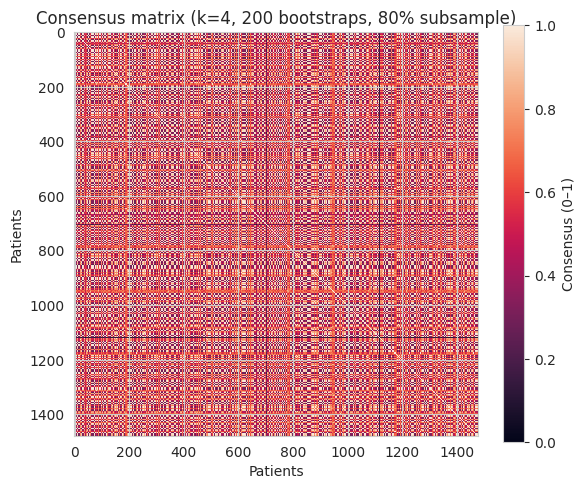

Saved: Figure_S4A_consensus_k4.png


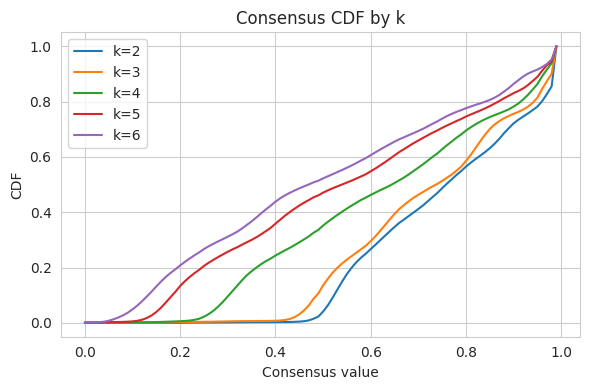

Saved: Figure_S4B_cdf.png


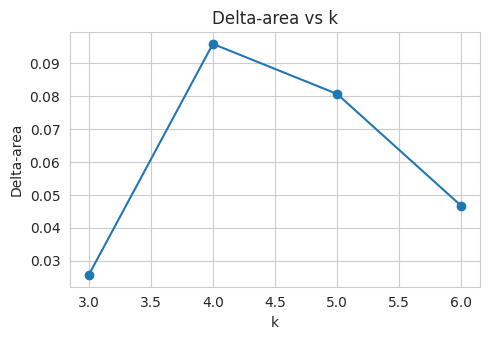

Saved: Figure_S4B_delta_area.png


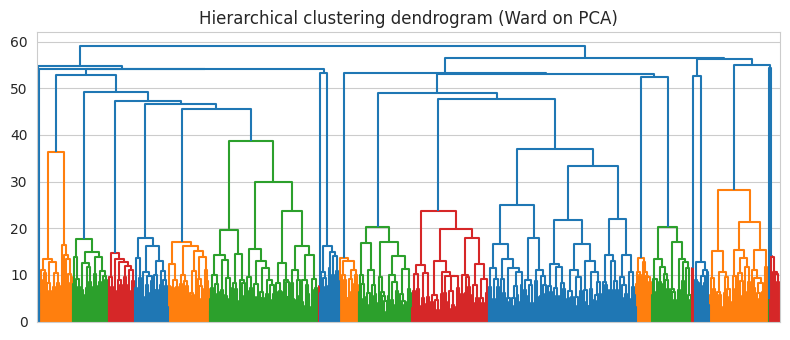

Saved: Figure_S4C_dendrogram.png


In [ ]:
# ================================================
# Appendix S4: Consensus matrix + CDF + Delta-area + Dendrogram
# - Auto-detects your X_scaled / PCA
# - Re-fits PCA to ~90% variance if feature counts changed
# - Saves figures: S4A/S4B/S4C
# ================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram

# -------- Parameters (tweak if you like) --------
RANDOM_STATE = 42
K_RANGE = [2,3,4,5,6]
N_BOOT = 200      # set to 200 for a quick test; 1000 for final SI
SUBSAMPLE = 0.80
K_STAR = 4         # your chosen k
SAVE_PREFIX = "Figure_S4"

rng = np.random.default_rng(RANDOM_STATE)

# -------- 0) Find a scaled matrix --------
X_scaled_used = None
for name in ["X_cc_scaled", "X_scaled", "Xz"]:
    if name in globals():
        X_scaled_used = globals()[name]
        print(f"Using scaled matrix: {name}  shape={X_scaled_used.shape}")
        break

# Fallback: try to scale a likely encoded DataFrame
if X_scaled_used is None:
    for df_name in ["df_enc", "X_cc", "X_complete_df"]:
        if df_name in globals():
            _df = globals()[df_name]
            if hasattr(_df, "values"):
                print(f"Scaling from DataFrame: {df_name} -> StandardScaler")
                X_scaled_used = StandardScaler().fit_transform(_df.values)
                print("Scaled shape:", X_scaled_used.shape)
                break
if X_scaled_used is None:
    raise NameError("No scaled matrix found. Expected one of: X_cc_scaled, X_scaled, Xz, "
                    "or a DataFrame df_enc/X_cc/X_complete_df.")

# -------- 1) Find or (re)fit PCA to ~90% variance --------
pca_used = None
for name in ["pca_cc", "pca"]:
    if name in globals():
        cand = globals()[name]
        if hasattr(cand, "explained_variance_ratio_"):
            pca_used = cand
            break

def get_pca_projection(X_scaled, pca_existing=None, var_threshold=0.90, random_state=42):
    if pca_existing is not None and hasattr(pca_existing, "n_features_in_") \
       and pca_existing.n_features_in_ == X_scaled.shape[1]:
        cumvar = np.cumsum(pca_existing.explained_variance_ratio_)
        n_comp = int(np.searchsorted(cumvar, var_threshold) + 1)
        try:
            X_pca_try = pca_existing.transform(X_scaled)[:, :n_comp]
            print(f"Reusing existing PCA ({pca_existing.n_features_in_} features).")
            return X_pca_try, pca_existing, n_comp, cumvar[n_comp-1]
        except Exception as e:
            print(f"Reusing PCA failed ({e}). Will refit.")

    print("Fitting PCA on current X_scaled to ~90% variance…")
    pca_full = PCA(random_state=random_state).fit(X_scaled)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = int(np.searchsorted(cumvar, var_threshold) + 1)
    pca_new = PCA(n_components=n_comp, random_state=random_state).fit(X_scaled)
    X_pca = pca_new.transform(X_scaled)
    return X_pca, pca_new, n_comp, cumvar[n_comp-1]

X_pca, pca_used, n_comp, cum_at = get_pca_projection(X_scaled_used, pca_existing=pca_used, var_threshold=0.90)
print(f"PCA components retained: {n_comp} (≈{cum_at:.3f} variance)  |  X_pca shape: {X_pca.shape}")

# -------- 2) Consensus matrix helper --------
def consensus_matrix(X, k, n_boot=N_BOOT, subsample=SUBSAMPLE):
    n = X.shape[0]
    C = np.zeros((n, n), dtype=float)
    I = np.zeros((n, n), dtype=float)
    for b in range(n_boot):
        idx = rng.choice(n, size=int(subsample*n), replace=False)
        Xb = X[idx]
        labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(Xb)
        # update co-occur / consensus
        for ci in range(len(idx)):
            i = idx[ci]
            for cj in range(ci+1, len(idx)):
                j = idx[cj]
                I[i, j] += 1; I[j, i] += 1
                if labels[ci] == labels[cj]:
                    C[i, j] += 1; C[j, i] += 1
        if (b+1) % max(100, n_boot//10) == 0:
            print(f"  bootstrap {b+1}/{n_boot} (k={k})")
    mask = I > 0
    C[mask] = C[mask] / I[mask]
    np.fill_diagonal(C, 1.0)
    return C

# -------- 3) Run consensus across K_RANGE + build CDFs --------
consensus_by_k = {}
cdf_x = np.linspace(0, 1, 101)
cdf_by_k = {}

for k in K_RANGE:
    print(f"\n>> Computing consensus for k={k}")
    C = consensus_matrix(X_pca, k=k)
    consensus_by_k[k] = C
    vals = C[np.triu_indices_from(C, k=1)]
    hist, _ = np.histogram(vals, bins=cdf_x, range=(0,1), density=True)
    cdf = np.cumsum(hist) / np.sum(hist)
    cdf_by_k[k] = cdf

# Delta-area
def auc_from_cdf(cdf, xgrid):
    dx = 1.0 / (len(xgrid)-1)
    return float(np.sum(cdf) * dx)

auc = {k: auc_from_cdf(cdf_by_k[k], cdf_x) for k in K_RANGE}
delta_area = {k: (auc[k] - auc[k-1]) for k in K_RANGE if k != min(K_RANGE)}
print("\nAUC by k:", {k: round(v,4) for k,v in auc.items()})
print("Delta-area:", {k: round(v,4) for k,v in delta_area.items()})

# -------- 4) Internal validation at k=4 on PCA space --------
k = K_STAR
model_labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X_pca)
try:
    sil = silhouette_score(X_pca, model_labels, metric="euclidean")
except Exception:
    sil = np.nan
try:
    db  = davies_bouldin_score(X_pca, model_labels)
except Exception:
    db = np.nan
try:
    ch  = calinski_harabasz_score(X_pca, model_labels)
except Exception:
    ch = np.nan
print(f"\nValidation (k={k}) on PCA space  |  Silhouette={sil:.3f}  DB={db:.3f}  CH={ch:.3f}")

# -------- 5) PLOTS + SAVE --------
# S4A: Consensus heatmap for k=4
plt.figure(figsize=(6,5))
plt.imshow(consensus_by_k[K_STAR], vmin=0, vmax=1, interpolation='nearest')
plt.colorbar(label='Consensus (0–1)')
plt.title(f'Consensus matrix (k={K_STAR}, {N_BOOT} bootstraps, {int(SUBSAMPLE*100)}% subsample)')
plt.xlabel('Patients'); plt.ylabel('Patients')
plt.tight_layout()
fn_a = f"{SAVE_PREFIX}A_consensus_k{K_STAR}.png"
plt.savefig(fn_a, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", fn_a)

# S4B: CDF curves + delta-area points
plt.figure(figsize=(6,4))
for k in K_RANGE:
    plt.plot(cdf_x[:-1], cdf_by_k[k], label=f'k={k}')
plt.xlabel('Consensus value'); plt.ylabel('CDF'); plt.title('Consensus CDF by k')
plt.legend()
plt.tight_layout()
fn_b1 = f"{SAVE_PREFIX}B_cdf.png"
plt.savefig(fn_b1, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", fn_b1)

plt.figure(figsize=(5,3.5))
plt.plot(list(delta_area.keys()), list(delta_area.values()), marker='o')
plt.xlabel('k'); plt.ylabel('Delta-area'); plt.title('Delta-area vs k')
plt.tight_layout()
fn_b2 = f"{SAVE_PREFIX}B_delta_area.png"
plt.savefig(fn_b2, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", fn_b2)

# S4C: Dendrogram (Ward on PCA)
Z = linkage(X_pca, method='ward', metric='euclidean')
plt.figure(figsize=(8,3.5))
dendrogram(Z, no_labels=True, color_threshold=None)
plt.title('Hierarchical clustering dendrogram (Ward on PCA)')
plt.tight_layout()
fn_c = f"{SAVE_PREFIX}C_dendrogram.png"
plt.savefig(fn_c, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", fn_c)
